%%html
<style>
.nbviewer div.output_area {
  overflow-y: auto;
  max-height: 500px; /* or value of your choosing */
}
</style>

# Implementation and Comparison of three deep learning architectures in anomaly detection 

Security has always been of paramount importance in cyber and cyber-physical systems. On the other hand, integration of cyber systems with more sensitive infrastructures has incentivized hackers to trigger more and more attacks in recent years. This has resulted in more global investment on cybersecurity. Moreover, the amount of data flow is beyond human supervision capabilities. Hence, machine learning algorithms can be good candidates to build Intrusion Detection Systems (IDS).
<p>
In general, there are two types of IDS. Misuse-based in which the attacks signatures are known and anomaly-based that attempt to capture deviation from normal behaviour. In this project, our focus is on anomaly-based detection. The main idea of anomaly-based intrusion detection is to measure the deviation from normal behaviour. In case of network intrusion detection, we can use sequential traffic data to learn behaviours of the system. 
</p>
<p>
In this project we want to implement three well-known deep learning architectures, and compare their performance in intrusion detection task. The main question that this project is supposed to address is, which of these three architectures works better in detecting anomalies. 
</p>

##### Three Architectures:
<ol>
    <li>
        <b>Fully Connected Auto-Encoders:</b>
        Autoencoders try to model the distribution of normal data (without intrusion). The main idea is to feed the normal sequence of data into autoencoder. In this case, we expect to be able to reconstruct the data with low error. Otherwise, the error of reconstruction will be high, because the network is not trained on data in case of intrusion. 
        <figure text="center" style="text-align:center">
            <img src="images/fully_connected_autoencoder.png" width="300px"/>
            <figcaption>Figure 1 Fully Connected Auto-encoder network</figcaption>
        </figure>
    </li>
    <li>
        <b>LSTM:</b>
        The idea here is the same as Auto-encoder, i.e. we try to encode and then reconstruct the sequence with an architecture like Fig. 2.
        <figure text="center" style="text-align:center">
            <img src="images/LSTM_many_to_many.png" width="120px"/>
            <figcaption>Figure 2 Encoder-Decoder LSTM network</figcaption>
        </figure>
    </li>
    <li>
        <b>1-D Convolutional Network:</b>
        We know that 2D-CNN Models work well for image related tasks. But here as we are working on sequential statistical data, we should use 1D-CNN Models. Here first we encode the sequence using a convolutional encoder, then using de-convolution layers try to reconstruct the sequence. Idea is very similar to Fully connected auto-encoder but here we are using convolutional encoder and decoder.
    </li>
</ol>
In this notebook, we first try to find the best structure in each of three aforementioned architectures by tuning the parameters with respect to their power in reconstructing the sequences. Then we evaluate them in detecting the anomalies.

In rest of this notebook you can see the implementation of tuning, training and evaluation in more details and in the end we conclude which architecture works the best with our dataset.

##### Dataset:
We are using the synthetic data generated in [1] which contains 1000 normal sequences, each with length of 100. We use 900 of this data set for training and 100 for validation. For testing we have 142 labled sequences, that 50 of them are labled as anomalous sequences.

##### Anomally detection evaluation:
As usually the data in anomally detection tasks are heavily imbalanced, also, we care more to most suspicous sequences, we will use top-k ranked recall and precision to evaluate models power in anomaly detection. 

### Import packages

In [1]:
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, ZeroPadding1D, Cropping1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
import gc
import tensorflow as tf


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10823129447438044971
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1420898713
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8208876367481353555
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Load data

In [5]:
with open('data_a.pickle', 'rb') as handle1:
    data = pickle.load(handle1)
    
training_data = data['training_data_A']
test_data = data['test_data_A']
test_labels = data['test_labels_A']
print(data.keys())

dict_keys(['training_data_A', 'test_data_A', 'anomalous_data_A', 'test_labels_A'])


### Data preparation

In [6]:
sequenceLen = training_data.shape[1]
trainDataSize = training_data.shape[0]
testDataSize = test_data.shape[0]
LSTMTraining_data = np.reshape(training_data, (trainDataSize,sequenceLen,1), order='C')
LSTMTest_data = np.reshape(test_data, (testDataSize,sequenceLen,1), order='C')

### Functions
Here we defined rankedPrecision() and rankedRecal() functions which are our evaluation functions in anomaly detection. The overall idea here is that, we first sort the samples loss from highest to lowest. Then, calculate precision and recall in top-K samples using definitions below:<br>
<p style="text-align:center">
$Precision=\frac{True Positive}{True Positive + False Positive}$<br/><br/>
$Recall=\frac{True Positive}{True Positive + False Negative}$<br/><br/>
</p>
As we know the number of anomalies in our test set, we pick K to be that number.

In [7]:
def rankedPrecision(mse_labels):
    sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
    totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
    TP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 1)
    FP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 0)
    TN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 0)
    FN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 1)
    precision = TP/(TP+FP)
    return precision
    
    
def rankedRecall(mse_labels):
    sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
    totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
    TP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 1)
    FP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 0)
    TN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 0)
    FN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 1)
    recall = TP/(TP+FN)
    return recall

# show_curve() is for plotting training and validation losses
def show_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### LSTM
Here we defined a function to train LSTM using different parameters, later we try to tune them. In this notebook, we tuned number of LSTM layers and number of neurons.

In [27]:
def trainLSTM(numOfLayers, numOfNeurons, printSummary = 1, vrbs = 1, return_best = 0):
    
        print('Training model.')
        model = Sequential()

        model.add(LSTM(numOfNeurons, input_shape=(sequenceLen, 1), return_sequences=True))
        for j in range(0, numOfLayers - 1):
            model.add(LSTM(numOfNeurons, return_sequences=True))

        model.add(Dense(1))
        model.add(Activation("linear"))

        if(printSummary == True):
            model.summary()

        model.compile(optimizer='adam', # rmsprop
                  loss='mean_squared_error',
                  )

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
        callbacksArray = [es]
        if(return_best):
            mc = ModelCheckpoint('best_lstm.h5', monitor='val_loss', mode='min')
            callbacksArray = [es, mc]

        history=model.fit(LSTMTraining_data, LSTMTraining_data,
                        batch_size=180,
                        shuffle=True,
                        epochs=1000, 
                        validation_split=0.1,
                        callbacks=callbacksArray,
                        verbose = vrbs,
                        )

        if(return_best):
            best_model = load_model('best_lstm.h5')
        returnModel = model
        if(return_best):
            returnModel = best_model
        return [returnModel,min(history.history['val_loss']),len(history.history['val_loss']),history]

### Tuning number of neurons
First we tune the number of neurons in LSTM layer. In basic model we considerd 1 LSTM layer and a Dense layer on top. We tried the range of 1 to 10 for the number of neurons:

Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 1)            12        
_________________________________________________________________
dense_3 (Dense)              (None, 100, 1)            2         
_________________________________________________________________
activation_3 (Activation)    (None, 100, 1)            0         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 1s 2ms/step - loss: 0.1293 - val_loss: 0.1280
Epoch 2/1000
900/900 [==============================] - 1s 758us/step - loss: 0.1272 - val_loss: 0.1259
Epoch 3/1000
900/900 [==============================] - 1s 746us/step - loss: 0.1251 - val_loss: 0.1240
Epoch 4/1000
900/900 [================

900/900 [==============================] - 1s 757us/step - loss: 0.0538 - val_loss: 0.0534
Epoch 149/1000
900/900 [==============================] - 1s 747us/step - loss: 0.0534 - val_loss: 0.0530
Epoch 150/1000
900/900 [==============================] - 1s 746us/step - loss: 0.0529 - val_loss: 0.0526
Epoch 151/1000
900/900 [==============================] - 1s 758us/step - loss: 0.0525 - val_loss: 0.0522
Epoch 152/1000
900/900 [==============================] - 1s 765us/step - loss: 0.0521 - val_loss: 0.0517
Epoch 153/1000
900/900 [==============================] - 1s 752us/step - loss: 0.0517 - val_loss: 0.0513
Epoch 154/1000
900/900 [==============================] - 1s 759us/step - loss: 0.0513 - val_loss: 0.0509
Epoch 155/1000
900/900 [==============================] - 1s 752us/step - loss: 0.0508 - val_loss: 0.0505
Epoch 156/1000
900/900 [==============================] - 1s 746us/step - loss: 0.0504 - val_loss: 0.0500
Epoch 157/1000
900/900 [==============================] - 1s 

900/900 [==============================] - 1s 749us/step - loss: 0.0108 - val_loss: 0.0105
Epoch 303/1000
900/900 [==============================] - 1s 755us/step - loss: 0.0107 - val_loss: 0.0103
Epoch 304/1000
900/900 [==============================] - 1s 738us/step - loss: 0.0105 - val_loss: 0.0102
Epoch 305/1000
900/900 [==============================] - 1s 783us/step - loss: 0.0104 - val_loss: 0.0101
Epoch 306/1000
900/900 [==============================] - 1s 760us/step - loss: 0.0103 - val_loss: 0.0099
Epoch 307/1000
900/900 [==============================] - 1s 756us/step - loss: 0.0101 - val_loss: 0.0098
Epoch 308/1000
900/900 [==============================] - 1s 735us/step - loss: 0.0100 - val_loss: 0.0097
Epoch 309/1000
900/900 [==============================] - 1s 762us/step - loss: 0.0099 - val_loss: 0.0095
Epoch 310/1000
900/900 [==============================] - 1s 763us/step - loss: 0.0097 - val_loss: 0.0094
Epoch 311/1000
900/900 [==============================] - 1s 

900/900 [==============================] - 1s 758us/step - loss: 0.0013 - val_loss: 9.4194e-04
Epoch 457/1000
900/900 [==============================] - 1s 749us/step - loss: 0.0013 - val_loss: 9.2857e-04
Epoch 458/1000
900/900 [==============================] - 1s 740us/step - loss: 0.0012 - val_loss: 9.1564e-04
Epoch 459/1000
900/900 [==============================] - 1s 755us/step - loss: 0.0012 - val_loss: 9.0316e-04
Epoch 460/1000
900/900 [==============================] - 1s 771us/step - loss: 0.0012 - val_loss: 8.9056e-04
Epoch 461/1000
900/900 [==============================] - 1s 747us/step - loss: 0.0012 - val_loss: 8.7854e-04
Epoch 462/1000
900/900 [==============================] - 1s 740us/step - loss: 0.0012 - val_loss: 8.6669e-04
Epoch 463/1000
900/900 [==============================] - 1s 740us/step - loss: 0.0012 - val_loss: 8.5487e-04
Epoch 464/1000
900/900 [==============================] - 1s 756us/step - loss: 0.0012 - val_loss: 8.4334e-04
Epoch 465/1000
900/900 [=

Epoch 529/1000
900/900 [==============================] - 1s 760us/step - loss: 7.1562e-04 - val_loss: 4.1823e-04
Epoch 530/1000
900/900 [==============================] - 1s 745us/step - loss: 7.1177e-04 - val_loss: 4.1481e-04
Epoch 531/1000
900/900 [==============================] - 1s 750us/step - loss: 7.0795e-04 - val_loss: 4.1141e-04
Epoch 532/1000
900/900 [==============================] - 1s 726us/step - loss: 7.0421e-04 - val_loss: 4.0809e-04
Epoch 533/1000
900/900 [==============================] - 1s 738us/step - loss: 7.0050e-04 - val_loss: 4.0481e-04
Epoch 534/1000
900/900 [==============================] - 1s 761us/step - loss: 6.9686e-04 - val_loss: 4.0157e-04
Epoch 535/1000
900/900 [==============================] - 1s 777us/step - loss: 6.9323e-04 - val_loss: 3.9838e-04
Epoch 536/1000
900/900 [==============================] - 1s 771us/step - loss: 6.8967e-04 - val_loss: 3.9524e-04
Epoch 537/1000
900/900 [==============================] - 1s 756us/step - loss: 6.8615e-

Epoch 601/1000
900/900 [==============================] - 1s 761us/step - loss: 5.2526e-04 - val_loss: 2.5859e-04
Epoch 602/1000
900/900 [==============================] - 1s 759us/step - loss: 5.2335e-04 - val_loss: 2.5714e-04
Epoch 603/1000
900/900 [==============================] - 1s 765us/step - loss: 5.2151e-04 - val_loss: 2.5571e-04
Epoch 604/1000
900/900 [==============================] - 1s 777us/step - loss: 5.1967e-04 - val_loss: 2.5430e-04
Epoch 605/1000
900/900 [==============================] - 1s 735us/step - loss: 5.1787e-04 - val_loss: 2.5290e-04
Epoch 606/1000
900/900 [==============================] - 1s 745us/step - loss: 5.1603e-04 - val_loss: 2.5151e-04
Epoch 607/1000
900/900 [==============================] - 1s 746us/step - loss: 5.1426e-04 - val_loss: 2.5013e-04
Epoch 608/1000
900/900 [==============================] - 1s 760us/step - loss: 5.1245e-04 - val_loss: 2.4877e-04
Epoch 609/1000
900/900 [==============================] - 1s 773us/step - loss: 5.1069e-

Epoch 673/1000
900/900 [==============================] - 1s 747us/step - loss: 4.1673e-04 - val_loss: 1.7891e-04
Epoch 674/1000
900/900 [==============================] - 1s 740us/step - loss: 4.1550e-04 - val_loss: 1.7806e-04
Epoch 675/1000
900/900 [==============================] - 1s 756us/step - loss: 4.1429e-04 - val_loss: 1.7721e-04
Epoch 676/1000
900/900 [==============================] - 1s 756us/step - loss: 4.1306e-04 - val_loss: 1.7636e-04
Epoch 677/1000
900/900 [==============================] - 1s 780us/step - loss: 4.1187e-04 - val_loss: 1.7553e-04
Epoch 678/1000
900/900 [==============================] - 1s 748us/step - loss: 4.1066e-04 - val_loss: 1.7470e-04
Epoch 679/1000
900/900 [==============================] - 1s 726us/step - loss: 4.0948e-04 - val_loss: 1.7388e-04
Epoch 680/1000
900/900 [==============================] - 1s 748us/step - loss: 4.0829e-04 - val_loss: 1.7306e-04
Epoch 681/1000
900/900 [==============================] - 1s 737us/step - loss: 4.0708e-

Epoch 745/1000
900/900 [==============================] - 1s 724us/step - loss: 3.4157e-04 - val_loss: 1.2876e-04
Epoch 746/1000
900/900 [==============================] - 1s 768us/step - loss: 3.4069e-04 - val_loss: 1.2819e-04
Epoch 747/1000
900/900 [==============================] - 1s 752us/step - loss: 3.3979e-04 - val_loss: 1.2762e-04
Epoch 748/1000
900/900 [==============================] - 1s 741us/step - loss: 3.3890e-04 - val_loss: 1.2705e-04
Epoch 749/1000
900/900 [==============================] - 1s 726us/step - loss: 3.3803e-04 - val_loss: 1.2650e-04
Epoch 750/1000
900/900 [==============================] - 1s 727us/step - loss: 3.3716e-04 - val_loss: 1.2596e-04
Epoch 751/1000
900/900 [==============================] - 1s 740us/step - loss: 3.3631e-04 - val_loss: 1.2542e-04
Epoch 752/1000
900/900 [==============================] - 1s 744us/step - loss: 3.3545e-04 - val_loss: 1.2487e-04
Epoch 753/1000
900/900 [==============================] - 1s 750us/step - loss: 3.3457e-

Epoch 817/1000
900/900 [==============================] - 1s 725us/step - loss: 2.8584e-04 - val_loss: 9.4649e-05
Epoch 818/1000
900/900 [==============================] - 1s 721us/step - loss: 2.8517e-04 - val_loss: 9.4254e-05
Epoch 819/1000
900/900 [==============================] - 1s 751us/step - loss: 2.8451e-04 - val_loss: 9.3864e-05
Epoch 820/1000
900/900 [==============================] - 1s 764us/step - loss: 2.8383e-04 - val_loss: 9.3466e-05
Epoch 821/1000
900/900 [==============================] - 1s 760us/step - loss: 2.8315e-04 - val_loss: 9.3070e-05
Epoch 822/1000
900/900 [==============================] - 1s 771us/step - loss: 2.8250e-04 - val_loss: 9.2690e-05
Epoch 823/1000
900/900 [==============================] - 1s 744us/step - loss: 2.8183e-04 - val_loss: 9.2308e-05
Epoch 824/1000
900/900 [==============================] - 1s 780us/step - loss: 2.8118e-04 - val_loss: 9.1930e-05
Epoch 825/1000
900/900 [==============================] - 1s 757us/step - loss: 2.8052e-

Epoch 889/1000
900/900 [==============================] - 1s 739us/step - loss: 2.4275e-04 - val_loss: 7.0489e-05
Epoch 890/1000
900/900 [==============================] - 1s 754us/step - loss: 2.4223e-04 - val_loss: 7.0217e-05
Epoch 891/1000
900/900 [==============================] - 1s 745us/step - loss: 2.4170e-04 - val_loss: 6.9933e-05
Epoch 892/1000
900/900 [==============================] - 1s 758us/step - loss: 2.4119e-04 - val_loss: 6.9649e-05
Epoch 893/1000
900/900 [==============================] - 1s 736us/step - loss: 2.4064e-04 - val_loss: 6.9352e-05
Epoch 894/1000
900/900 [==============================] - 1s 764us/step - loss: 2.4012e-04 - val_loss: 6.9078e-05
Epoch 895/1000
900/900 [==============================] - 1s 751us/step - loss: 2.3961e-04 - val_loss: 6.8816e-05
Epoch 896/1000
900/900 [==============================] - 1s 784us/step - loss: 2.3909e-04 - val_loss: 6.8544e-05
Epoch 897/1000
900/900 [==============================] - 1s 750us/step - loss: 2.3856e-

Epoch 961/1000
900/900 [==============================] - 1s 760us/step - loss: 2.1290e-04 - val_loss: 5.6737e-05
Epoch 962/1000
900/900 [==============================] - 1s 736us/step - loss: 2.1258e-04 - val_loss: 5.6625e-05
Epoch 963/1000
900/900 [==============================] - 1s 773us/step - loss: 2.1225e-04 - val_loss: 5.6499e-05
Epoch 964/1000
900/900 [==============================] - 1s 776us/step - loss: 2.1195e-04 - val_loss: 5.6399e-05
Epoch 965/1000
900/900 [==============================] - 1s 751us/step - loss: 2.1164e-04 - val_loss: 5.6290e-05
Epoch 966/1000
900/900 [==============================] - 1s 751us/step - loss: 2.1131e-04 - val_loss: 5.6159e-05
Epoch 967/1000
900/900 [==============================] - 1s 770us/step - loss: 2.1099e-04 - val_loss: 5.6033e-05
Epoch 968/1000
900/900 [==============================] - 1s 732us/step - loss: 2.1067e-04 - val_loss: 5.5919e-05
Epoch 969/1000
900/900 [==============================] - 1s 734us/step - loss: 2.1035e-

Epoch 106/1000
900/900 [==============================] - 1s 756us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 107/1000
900/900 [==============================] - 1s 762us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 108/1000
900/900 [==============================] - 1s 759us/step - loss: 0.0041 - val_loss: 0.0042
Epoch 109/1000
900/900 [==============================] - 1s 745us/step - loss: 0.0039 - val_loss: 0.0040
Epoch 110/1000
900/900 [==============================] - 1s 767us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 111/1000
900/900 [==============================] - 1s 752us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 112/1000
900/900 [==============================] - 1s 752us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 113/1000
900/900 [==============================] - 1s 778us/step - loss: 0.0034 - val_loss: 0.0035
Epoch 114/1000
900/900 [==============================] - 1s 732us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 115/1000
900/900 [======================

900/900 [==============================] - 1s 770us/step - loss: 2.9253e-04 - val_loss: 3.0786e-04
Epoch 256/1000
900/900 [==============================] - 1s 769us/step - loss: 2.8685e-04 - val_loss: 3.0182e-04
Epoch 257/1000
900/900 [==============================] - 1s 759us/step - loss: 2.8130e-04 - val_loss: 2.9589e-04
Epoch 258/1000
900/900 [==============================] - 1s 764us/step - loss: 2.7588e-04 - val_loss: 2.9005e-04
Epoch 259/1000
900/900 [==============================] - 1s 748us/step - loss: 2.7050e-04 - val_loss: 2.8432e-04
Epoch 260/1000
900/900 [==============================] - 1s 741us/step - loss: 2.6526e-04 - val_loss: 2.7867e-04
Epoch 261/1000
900/900 [==============================] - 1s 759us/step - loss: 2.6007e-04 - val_loss: 2.7313e-04
Epoch 262/1000
900/900 [==============================] - 1s 735us/step - loss: 2.5502e-04 - val_loss: 2.6767e-04
Epoch 263/1000
900/900 [==============================] - 1s 764us/step - loss: 2.4999e-04 - val_loss: 

Epoch 327/1000
900/900 [==============================] - 1s 750us/step - loss: 7.1514e-05 - val_loss: 6.9628e-05
Epoch 328/1000
900/900 [==============================] - 1s 761us/step - loss: 7.0283e-05 - val_loss: 6.8275e-05
Epoch 329/1000
900/900 [==============================] - 1s 739us/step - loss: 6.9077e-05 - val_loss: 6.6957e-05
Epoch 330/1000
900/900 [==============================] - 1s 747us/step - loss: 6.7904e-05 - val_loss: 6.5670e-05
Epoch 331/1000
900/900 [==============================] - 1s 752us/step - loss: 6.6753e-05 - val_loss: 6.4416e-05
Epoch 332/1000
900/900 [==============================] - 1s 738us/step - loss: 6.5637e-05 - val_loss: 6.3192e-05
Epoch 333/1000
900/900 [==============================] - 1s 746us/step - loss: 6.4559e-05 - val_loss: 6.1991e-05
Epoch 334/1000
900/900 [==============================] - 1s 738us/step - loss: 6.3483e-05 - val_loss: 6.0828e-05
Epoch 335/1000
900/900 [==============================] - 1s 758us/step - loss: 6.2447e-

Epoch 399/1000
900/900 [==============================] - 1s 757us/step - loss: 3.0625e-05 - val_loss: 2.4331e-05
Epoch 400/1000
900/900 [==============================] - 1s 764us/step - loss: 3.0440e-05 - val_loss: 2.4122e-05
Epoch 401/1000
900/900 [==============================] - 1s 742us/step - loss: 3.0260e-05 - val_loss: 2.3918e-05
Epoch 402/1000
900/900 [==============================] - 1s 750us/step - loss: 3.0083e-05 - val_loss: 2.3721e-05
Epoch 403/1000
900/900 [==============================] - 1s 757us/step - loss: 2.9912e-05 - val_loss: 2.3526e-05
Epoch 404/1000
900/900 [==============================] - 1s 739us/step - loss: 2.9746e-05 - val_loss: 2.3337e-05
Epoch 405/1000
900/900 [==============================] - 1s 767us/step - loss: 2.9581e-05 - val_loss: 2.3155e-05
Epoch 406/1000
900/900 [==============================] - 1s 782us/step - loss: 2.9423e-05 - val_loss: 2.2975e-05
Epoch 407/1000
900/900 [==============================] - 1s 738us/step - loss: 2.9269e-

Epoch 471/1000
900/900 [==============================] - 1s 737us/step - loss: 2.3832e-05 - val_loss: 1.6848e-05
Epoch 472/1000
900/900 [==============================] - 1s 754us/step - loss: 2.3781e-05 - val_loss: 1.6797e-05
Epoch 473/1000
900/900 [==============================] - 1s 751us/step - loss: 2.3731e-05 - val_loss: 1.6746e-05
Epoch 474/1000
900/900 [==============================] - 1s 739us/step - loss: 2.3682e-05 - val_loss: 1.6697e-05
Epoch 475/1000
900/900 [==============================] - 1s 761us/step - loss: 2.3633e-05 - val_loss: 1.6649e-05
Epoch 476/1000
900/900 [==============================] - 1s 779us/step - loss: 2.3584e-05 - val_loss: 1.6600e-05
Epoch 477/1000
900/900 [==============================] - 1s 771us/step - loss: 2.3536e-05 - val_loss: 1.6552e-05
Epoch 478/1000
900/900 [==============================] - 1s 754us/step - loss: 2.3488e-05 - val_loss: 1.6506e-05
Epoch 479/1000
900/900 [==============================] - 1s 764us/step - loss: 2.3440e-

Epoch 614/1000
900/900 [==============================] - 1s 754us/step - loss: 1.8324e-05 - val_loss: 1.2051e-05
Epoch 615/1000
900/900 [==============================] - 1s 764us/step - loss: 1.8290e-05 - val_loss: 1.2025e-05
Epoch 616/1000
900/900 [==============================] - 1s 770us/step - loss: 1.8257e-05 - val_loss: 1.1998e-05
Epoch 617/1000
900/900 [==============================] - 1s 750us/step - loss: 1.8224e-05 - val_loss: 1.1973e-05
Epoch 618/1000
900/900 [==============================] - 1s 750us/step - loss: 1.8190e-05 - val_loss: 1.1946e-05
Epoch 619/1000
900/900 [==============================] - 1s 757us/step - loss: 1.8156e-05 - val_loss: 1.1920e-05
Epoch 620/1000
900/900 [==============================] - 1s 742us/step - loss: 1.8124e-05 - val_loss: 1.1894e-05
Epoch 621/1000
900/900 [==============================] - 1s 752us/step - loss: 1.8090e-05 - val_loss: 1.1868e-05
Epoch 622/1000
900/900 [==============================] - 1s 758us/step - loss: 1.8057e-

Epoch 686/1000
900/900 [==============================] - 1s 770us/step - loss: 1.6022e-05 - val_loss: 1.0284e-05
Epoch 687/1000
900/900 [==============================] - 1s 767us/step - loss: 1.5992e-05 - val_loss: 1.0261e-05
Epoch 688/1000
900/900 [==============================] - 1s 772us/step - loss: 1.5961e-05 - val_loss: 1.0238e-05
Epoch 689/1000
900/900 [==============================] - 1s 766us/step - loss: 1.5931e-05 - val_loss: 1.0215e-05
Epoch 690/1000
900/900 [==============================] - 1s 769us/step - loss: 1.5901e-05 - val_loss: 1.0193e-05
Epoch 691/1000
900/900 [==============================] - 1s 754us/step - loss: 1.5871e-05 - val_loss: 1.0170e-05
Epoch 692/1000
900/900 [==============================] - 1s 745us/step - loss: 1.5841e-05 - val_loss: 1.0149e-05
Epoch 693/1000
900/900 [==============================] - 1s 740us/step - loss: 1.5810e-05 - val_loss: 1.0125e-05
Epoch 694/1000
900/900 [==============================] - 1s 761us/step - loss: 1.5780e-

Epoch 758/1000
900/900 [==============================] - 1s 759us/step - loss: 1.3942e-05 - val_loss: 8.7457e-06
Epoch 759/1000
900/900 [==============================] - 1s 757us/step - loss: 1.3914e-05 - val_loss: 8.7264e-06
Epoch 760/1000
900/900 [==============================] - 1s 768us/step - loss: 1.3886e-05 - val_loss: 8.7052e-06
Epoch 761/1000
900/900 [==============================] - 1s 730us/step - loss: 1.3858e-05 - val_loss: 8.6864e-06
Epoch 762/1000
900/900 [==============================] - 1s 768us/step - loss: 1.3831e-05 - val_loss: 8.6651e-06
Epoch 763/1000
900/900 [==============================] - 1s 756us/step - loss: 1.3803e-05 - val_loss: 8.6461e-06
Epoch 764/1000
900/900 [==============================] - 1s 756us/step - loss: 1.3776e-05 - val_loss: 8.6258e-06
Epoch 765/1000
900/900 [==============================] - 1s 751us/step - loss: 1.3748e-05 - val_loss: 8.6055e-06
Epoch 766/1000
900/900 [==============================] - 1s 756us/step - loss: 1.3721e-

Epoch 830/1000
900/900 [==============================] - 1s 756us/step - loss: 1.2052e-05 - val_loss: 7.4023e-06
Epoch 831/1000
900/900 [==============================] - 1s 778us/step - loss: 1.2028e-05 - val_loss: 7.3854e-06
Epoch 832/1000
900/900 [==============================] - 1s 764us/step - loss: 1.2003e-05 - val_loss: 7.3680e-06
Epoch 833/1000
900/900 [==============================] - 1s 764us/step - loss: 1.1979e-05 - val_loss: 7.3501e-06
Epoch 834/1000
900/900 [==============================] - 1s 750us/step - loss: 1.1954e-05 - val_loss: 7.3338e-06
Epoch 835/1000
900/900 [==============================] - 1s 754us/step - loss: 1.1929e-05 - val_loss: 7.3170e-06
Epoch 836/1000
900/900 [==============================] - 1s 747us/step - loss: 1.1905e-05 - val_loss: 7.3001e-06
Epoch 837/1000
900/900 [==============================] - 1s 748us/step - loss: 1.1881e-05 - val_loss: 7.2826e-06
Epoch 838/1000
900/900 [==============================] - 1s 781us/step - loss: 1.1856e-

Epoch 902/1000
900/900 [==============================] - 1s 769us/step - loss: 1.0379e-05 - val_loss: 6.2503e-06
Epoch 903/1000
900/900 [==============================] - 1s 756us/step - loss: 1.0358e-05 - val_loss: 6.2372e-06
Epoch 904/1000
900/900 [==============================] - 1s 759us/step - loss: 1.0335e-05 - val_loss: 6.2220e-06
Epoch 905/1000
900/900 [==============================] - 1s 741us/step - loss: 1.0314e-05 - val_loss: 6.2074e-06
Epoch 906/1000
900/900 [==============================] - 1s 750us/step - loss: 1.0292e-05 - val_loss: 6.1926e-06
Epoch 907/1000
900/900 [==============================] - 1s 767us/step - loss: 1.0270e-05 - val_loss: 6.1783e-06
Epoch 908/1000
900/900 [==============================] - 1s 761us/step - loss: 1.0249e-05 - val_loss: 6.1644e-06
Epoch 909/1000
900/900 [==============================] - 1s 762us/step - loss: 1.0227e-05 - val_loss: 6.1490e-06
Epoch 910/1000
900/900 [==============================] - 1s 765us/step - loss: 1.0206e-

Epoch 974/1000
900/900 [==============================] - 1s 761us/step - loss: 8.9066e-06 - val_loss: 5.2701e-06
Epoch 975/1000
900/900 [==============================] - 1s 750us/step - loss: 8.8872e-06 - val_loss: 5.2581e-06
Epoch 976/1000
900/900 [==============================] - 1s 765us/step - loss: 8.8694e-06 - val_loss: 5.2459e-06
Epoch 977/1000
900/900 [==============================] - 1s 768us/step - loss: 8.8498e-06 - val_loss: 5.2348e-06
Epoch 978/1000
900/900 [==============================] - 1s 754us/step - loss: 8.8306e-06 - val_loss: 5.2199e-06
Epoch 979/1000
900/900 [==============================] - 1s 746us/step - loss: 8.8119e-06 - val_loss: 5.2093e-06
Epoch 980/1000
900/900 [==============================] - 1s 765us/step - loss: 8.7927e-06 - val_loss: 5.1968e-06
Epoch 981/1000
900/900 [==============================] - 1s 755us/step - loss: 8.7734e-06 - val_loss: 5.1832e-06
Epoch 982/1000
900/900 [==============================] - 1s 765us/step - loss: 8.7548e-

Epoch 120/1000
900/900 [==============================] - 1s 746us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 121/1000
900/900 [==============================] - 1s 773us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 122/1000
900/900 [==============================] - 1s 756us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 123/1000
900/900 [==============================] - 1s 740us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 124/1000
900/900 [==============================] - 1s 757us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 125/1000
900/900 [==============================] - 1s 758us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 126/1000
900/900 [==============================] - 1s 765us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 127/1000
900/900 [==============================] - 1s 754us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 128/1000
900/900 [==============================] - 1s 737us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 129/1000
900/900 [======================

Epoch 265/1000
900/900 [==============================] - 1s 778us/step - loss: 2.4509e-04 - val_loss: 1.3992e-04
Epoch 266/1000
900/900 [==============================] - 1s 748us/step - loss: 2.4329e-04 - val_loss: 1.3823e-04
Epoch 267/1000
900/900 [==============================] - 1s 759us/step - loss: 2.4152e-04 - val_loss: 1.3657e-04
Epoch 268/1000
900/900 [==============================] - 1s 736us/step - loss: 2.3978e-04 - val_loss: 1.3493e-04
Epoch 269/1000
900/900 [==============================] - 1s 752us/step - loss: 2.3808e-04 - val_loss: 1.3334e-04
Epoch 270/1000
900/900 [==============================] - 1s 747us/step - loss: 2.3639e-04 - val_loss: 1.3175e-04
Epoch 271/1000
900/900 [==============================] - 1s 742us/step - loss: 2.3474e-04 - val_loss: 1.3019e-04
Epoch 272/1000
900/900 [==============================] - 1s 754us/step - loss: 2.3311e-04 - val_loss: 1.2865e-04
Epoch 273/1000
900/900 [==============================] - 1s 751us/step - loss: 2.3150e-

Epoch 408/1000
900/900 [==============================] - 1s 760us/step - loss: 1.2298e-04 - val_loss: 2.8937e-05
Epoch 409/1000
900/900 [==============================] - 1s 750us/step - loss: 1.2256e-04 - val_loss: 2.8672e-05
Epoch 410/1000
900/900 [==============================] - 1s 761us/step - loss: 1.2214e-04 - val_loss: 2.8413e-05
Epoch 411/1000
900/900 [==============================] - 1s 760us/step - loss: 1.2172e-04 - val_loss: 2.8153e-05
Epoch 412/1000
900/900 [==============================] - 1s 766us/step - loss: 1.2130e-04 - val_loss: 2.7886e-05
Epoch 413/1000
900/900 [==============================] - 1s 762us/step - loss: 1.2089e-04 - val_loss: 2.7616e-05
Epoch 414/1000
900/900 [==============================] - 1s 755us/step - loss: 1.2049e-04 - val_loss: 2.7386e-05
Epoch 415/1000
900/900 [==============================] - 1s 765us/step - loss: 1.2009e-04 - val_loss: 2.7152e-05
Epoch 416/1000
900/900 [==============================] - 1s 770us/step - loss: 1.1967e-

Epoch 480/1000
900/900 [==============================] - 1s 760us/step - loss: 9.6932e-05 - val_loss: 1.6385e-05
Epoch 481/1000
900/900 [==============================] - 1s 747us/step - loss: 9.6594e-05 - val_loss: 1.6256e-05
Epoch 482/1000
900/900 [==============================] - 1s 754us/step - loss: 9.6273e-05 - val_loss: 1.6144e-05
Epoch 483/1000
900/900 [==============================] - 1s 750us/step - loss: 9.5947e-05 - val_loss: 1.6028e-05
Epoch 484/1000
900/900 [==============================] - 1s 745us/step - loss: 9.5627e-05 - val_loss: 1.5921e-05
Epoch 485/1000
900/900 [==============================] - 1s 730us/step - loss: 9.5314e-05 - val_loss: 1.5832e-05
Epoch 486/1000
900/900 [==============================] - 1s 755us/step - loss: 9.4973e-05 - val_loss: 1.5708e-05
Epoch 487/1000
900/900 [==============================] - 1s 756us/step - loss: 9.4652e-05 - val_loss: 1.5594e-05
Epoch 488/1000
900/900 [==============================] - 1s 754us/step - loss: 9.4346e-

Epoch 552/1000
900/900 [==============================] - 1s 760us/step - loss: 7.4418e-05 - val_loss: 1.0384e-05
Epoch 553/1000
900/900 [==============================] - 1s 758us/step - loss: 7.4113e-05 - val_loss: 1.0318e-05
Epoch 554/1000
900/900 [==============================] - 1s 760us/step - loss: 7.3805e-05 - val_loss: 1.0244e-05
Epoch 555/1000
900/900 [==============================] - 1s 728us/step - loss: 7.3503e-05 - val_loss: 1.0172e-05
Epoch 556/1000
900/900 [==============================] - 1s 744us/step - loss: 7.3216e-05 - val_loss: 1.0129e-05
Epoch 557/1000
900/900 [==============================] - 1s 760us/step - loss: 7.2911e-05 - val_loss: 1.0071e-05
Epoch 558/1000
900/900 [==============================] - 1s 759us/step - loss: 7.2603e-05 - val_loss: 9.9980e-06
Epoch 559/1000
900/900 [==============================] - 1s 761us/step - loss: 7.2318e-05 - val_loss: 9.9513e-06
Epoch 560/1000
900/900 [==============================] - 1s 767us/step - loss: 7.2022e-

Epoch 624/1000
900/900 [==============================] - 1s 749us/step - loss: 5.3569e-05 - val_loss: 6.8800e-06
Epoch 625/1000
900/900 [==============================] - 1s 756us/step - loss: 5.3295e-05 - val_loss: 6.8395e-06
Epoch 626/1000
900/900 [==============================] - 1s 755us/step - loss: 5.3034e-05 - val_loss: 6.8162e-06
Epoch 627/1000
900/900 [==============================] - 1s 757us/step - loss: 5.2756e-05 - val_loss: 6.7823e-06
Epoch 628/1000
900/900 [==============================] - 1s 754us/step - loss: 5.2473e-05 - val_loss: 6.7311e-06
Epoch 629/1000
900/900 [==============================] - 1s 734us/step - loss: 5.2205e-05 - val_loss: 6.6939e-06
Epoch 630/1000
900/900 [==============================] - 1s 752us/step - loss: 5.1949e-05 - val_loss: 6.6752e-06
Epoch 631/1000
900/900 [==============================] - 1s 740us/step - loss: 5.1669e-05 - val_loss: 6.6407e-06
Epoch 632/1000
900/900 [==============================] - 1s 748us/step - loss: 5.1388e-

Epoch 696/1000
900/900 [==============================] - 1s 764us/step - loss: 3.5396e-05 - val_loss: 4.6885e-06
Epoch 697/1000
900/900 [==============================] - 1s 761us/step - loss: 3.5170e-05 - val_loss: 4.6684e-06
Epoch 698/1000
900/900 [==============================] - 1s 735us/step - loss: 3.4945e-05 - val_loss: 4.6483e-06
Epoch 699/1000
900/900 [==============================] - 1s 740us/step - loss: 3.4703e-05 - val_loss: 4.6088e-06
Epoch 700/1000
900/900 [==============================] - 1s 755us/step - loss: 3.4479e-05 - val_loss: 4.5783e-06
Epoch 701/1000
900/900 [==============================] - 1s 754us/step - loss: 3.4252e-05 - val_loss: 4.5415e-06
Epoch 702/1000
900/900 [==============================] - 1s 750us/step - loss: 3.4033e-05 - val_loss: 4.5149e-06
Epoch 703/1000
900/900 [==============================] - 1s 767us/step - loss: 3.3816e-05 - val_loss: 4.4992e-06
Epoch 704/1000
900/900 [==============================] - 1s 759us/step - loss: 3.3586e-

Epoch 768/1000
900/900 [==============================] - 1s 760us/step - loss: 2.1033e-05 - val_loss: 3.0241e-06
Epoch 769/1000
900/900 [==============================] - 1s 738us/step - loss: 2.0864e-05 - val_loss: 3.0028e-06
Epoch 770/1000
900/900 [==============================] - 1s 742us/step - loss: 2.0703e-05 - val_loss: 2.9860e-06
Epoch 771/1000
900/900 [==============================] - 1s 740us/step - loss: 2.0543e-05 - val_loss: 2.9697e-06
Epoch 772/1000
900/900 [==============================] - 1s 752us/step - loss: 2.0384e-05 - val_loss: 2.9569e-06
Epoch 773/1000
900/900 [==============================] - 1s 752us/step - loss: 2.0212e-05 - val_loss: 2.9327e-06
Epoch 774/1000
900/900 [==============================] - 1s 748us/step - loss: 2.0054e-05 - val_loss: 2.9136e-06
Epoch 775/1000
900/900 [==============================] - 1s 748us/step - loss: 1.9902e-05 - val_loss: 2.8989e-06
Epoch 776/1000
900/900 [==============================] - 1s 735us/step - loss: 1.9740e-

Epoch 840/1000
900/900 [==============================] - 1s 745us/step - loss: 1.1949e-05 - val_loss: 2.0069e-06
Epoch 841/1000
900/900 [==============================] - 1s 755us/step - loss: 1.1860e-05 - val_loss: 1.9952e-06
Epoch 842/1000
900/900 [==============================] - 1s 772us/step - loss: 1.1779e-05 - val_loss: 1.9843e-06
Epoch 843/1000
900/900 [==============================] - 1s 757us/step - loss: 1.1696e-05 - val_loss: 1.9741e-06
Epoch 844/1000
900/900 [==============================] - 1s 759us/step - loss: 1.1615e-05 - val_loss: 1.9658e-06
Epoch 845/1000
900/900 [==============================] - 1s 758us/step - loss: 1.1535e-05 - val_loss: 1.9557e-06
Epoch 846/1000
900/900 [==============================] - 1s 760us/step - loss: 1.1457e-05 - val_loss: 1.9476e-06
Epoch 847/1000
900/900 [==============================] - 1s 764us/step - loss: 1.1378e-05 - val_loss: 1.9388e-06
Epoch 848/1000
900/900 [==============================] - 1s 759us/step - loss: 1.1298e-

Epoch 912/1000
900/900 [==============================] - 1s 756us/step - loss: 7.9788e-06 - val_loss: 1.5241e-06
Epoch 913/1000
900/900 [==============================] - 1s 748us/step - loss: 7.9445e-06 - val_loss: 1.5194e-06
Epoch 914/1000
900/900 [==============================] - 1s 765us/step - loss: 7.9105e-06 - val_loss: 1.5146e-06
Epoch 915/1000
900/900 [==============================] - 1s 750us/step - loss: 7.8788e-06 - val_loss: 1.5113e-06
Epoch 916/1000
900/900 [==============================] - 1s 736us/step - loss: 7.8442e-06 - val_loss: 1.5049e-06
Epoch 917/1000
900/900 [==============================] - 1s 756us/step - loss: 7.8115e-06 - val_loss: 1.5010e-06
Epoch 918/1000
900/900 [==============================] - 1s 752us/step - loss: 7.7809e-06 - val_loss: 1.4974e-06
Epoch 919/1000
900/900 [==============================] - 1s 752us/step - loss: 7.7465e-06 - val_loss: 1.4918e-06
Epoch 920/1000
900/900 [==============================] - 1s 747us/step - loss: 7.7152e-

Epoch 984/1000
900/900 [==============================] - 1s 747us/step - loss: 6.1222e-06 - val_loss: 1.2592e-06
Epoch 985/1000
900/900 [==============================] - 1s 754us/step - loss: 6.1020e-06 - val_loss: 1.2548e-06
Epoch 986/1000
900/900 [==============================] - 1s 767us/step - loss: 6.0812e-06 - val_loss: 1.2513e-06
Epoch 987/1000
900/900 [==============================] - 1s 761us/step - loss: 6.0603e-06 - val_loss: 1.2490e-06
Epoch 988/1000
900/900 [==============================] - 1s 764us/step - loss: 6.0397e-06 - val_loss: 1.2474e-06
Epoch 989/1000
900/900 [==============================] - 1s 758us/step - loss: 6.0209e-06 - val_loss: 1.2438e-06
Epoch 990/1000
900/900 [==============================] - 1s 772us/step - loss: 6.0008e-06 - val_loss: 1.2397e-06
Epoch 991/1000
900/900 [==============================] - 1s 761us/step - loss: 5.9817e-06 - val_loss: 1.2365e-06
Epoch 992/1000
900/900 [==============================] - 1s 767us/step - loss: 5.9628e-

Epoch 130/1000
900/900 [==============================] - 1s 750us/step - loss: 7.4598e-04 - val_loss: 7.6118e-04
Epoch 131/1000
900/900 [==============================] - 1s 767us/step - loss: 7.3211e-04 - val_loss: 7.4713e-04
Epoch 132/1000
900/900 [==============================] - 1s 765us/step - loss: 7.1907e-04 - val_loss: 7.3400e-04
Epoch 133/1000
900/900 [==============================] - 1s 756us/step - loss: 7.0692e-04 - val_loss: 7.2163e-04
Epoch 134/1000
900/900 [==============================] - 1s 778us/step - loss: 6.9546e-04 - val_loss: 7.0993e-04
Epoch 135/1000
900/900 [==============================] - 1s 756us/step - loss: 6.8461e-04 - val_loss: 6.9886e-04
Epoch 136/1000
900/900 [==============================] - 1s 765us/step - loss: 6.7439e-04 - val_loss: 6.8843e-04
Epoch 137/1000
900/900 [==============================] - 1s 766us/step - loss: 6.6473e-04 - val_loss: 6.7858e-04
Epoch 138/1000
900/900 [==============================] - 1s 749us/step - loss: 6.5563e-

Epoch 202/1000
900/900 [==============================] - 1s 738us/step - loss: 3.0017e-04 - val_loss: 2.8708e-04
Epoch 203/1000
900/900 [==============================] - 1s 766us/step - loss: 2.9633e-04 - val_loss: 2.8288e-04
Epoch 204/1000
900/900 [==============================] - 1s 776us/step - loss: 2.9252e-04 - val_loss: 2.7872e-04
Epoch 205/1000
900/900 [==============================] - 1s 779us/step - loss: 2.8871e-04 - val_loss: 2.7463e-04
Epoch 206/1000
900/900 [==============================] - 1s 760us/step - loss: 2.8502e-04 - val_loss: 2.7060e-04
Epoch 207/1000
900/900 [==============================] - 1s 773us/step - loss: 2.8135e-04 - val_loss: 2.6652e-04
Epoch 208/1000
900/900 [==============================] - 1s 770us/step - loss: 2.7768e-04 - val_loss: 2.6257e-04
Epoch 209/1000
900/900 [==============================] - 1s 765us/step - loss: 2.7404e-04 - val_loss: 2.5863e-04
Epoch 210/1000
900/900 [==============================] - 1s 748us/step - loss: 2.7047e-

Epoch 345/1000
900/900 [==============================] - 1s 762us/step - loss: 5.4424e-05 - val_loss: 2.3770e-05
Epoch 346/1000
900/900 [==============================] - 1s 775us/step - loss: 5.4021e-05 - val_loss: 2.3390e-05
Epoch 347/1000
900/900 [==============================] - 1s 757us/step - loss: 5.3622e-05 - val_loss: 2.3022e-05
Epoch 348/1000
900/900 [==============================] - 1s 735us/step - loss: 5.3230e-05 - val_loss: 2.2658e-05
Epoch 349/1000
900/900 [==============================] - 1s 742us/step - loss: 5.2845e-05 - val_loss: 2.2297e-05
Epoch 350/1000
900/900 [==============================] - 1s 759us/step - loss: 5.2468e-05 - val_loss: 2.1950e-05
Epoch 351/1000
900/900 [==============================] - 1s 746us/step - loss: 5.2094e-05 - val_loss: 2.1612e-05
Epoch 352/1000
900/900 [==============================] - 1s 765us/step - loss: 5.1723e-05 - val_loss: 2.1283e-05
Epoch 353/1000
900/900 [==============================] - 1s 769us/step - loss: 5.1362e-

Epoch 417/1000
900/900 [==============================] - 1s 746us/step - loss: 3.5684e-05 - val_loss: 9.0863e-06
Epoch 418/1000
900/900 [==============================] - 1s 762us/step - loss: 3.5521e-05 - val_loss: 8.9944e-06
Epoch 419/1000
900/900 [==============================] - 1s 731us/step - loss: 3.5349e-05 - val_loss: 8.9009e-06
Epoch 420/1000
900/900 [==============================] - 1s 755us/step - loss: 3.5180e-05 - val_loss: 8.8053e-06
Epoch 421/1000
900/900 [==============================] - 1s 754us/step - loss: 3.5019e-05 - val_loss: 8.7107e-06
Epoch 422/1000
900/900 [==============================] - 1s 755us/step - loss: 3.4856e-05 - val_loss: 8.6200e-06
Epoch 423/1000
900/900 [==============================] - 1s 759us/step - loss: 3.4696e-05 - val_loss: 8.5321e-06
Epoch 424/1000
900/900 [==============================] - 1s 766us/step - loss: 3.4535e-05 - val_loss: 8.4432e-06
Epoch 425/1000
900/900 [==============================] - 1s 748us/step - loss: 3.4375e-

Epoch 489/1000
900/900 [==============================] - 1s 767us/step - loss: 2.6138e-05 - val_loss: 4.8433e-06
Epoch 490/1000
900/900 [==============================] - 1s 759us/step - loss: 2.6030e-05 - val_loss: 4.8109e-06
Epoch 491/1000
900/900 [==============================] - 1s 761us/step - loss: 2.5920e-05 - val_loss: 4.7792e-06
Epoch 492/1000
900/900 [==============================] - 1s 759us/step - loss: 2.5816e-05 - val_loss: 4.7468e-06
Epoch 493/1000
900/900 [==============================] - 1s 761us/step - loss: 2.5713e-05 - val_loss: 4.7124e-06
Epoch 494/1000
900/900 [==============================] - 1s 773us/step - loss: 2.5607e-05 - val_loss: 4.6794e-06
Epoch 495/1000
900/900 [==============================] - 1s 764us/step - loss: 2.5499e-05 - val_loss: 4.6507e-06
Epoch 496/1000
900/900 [==============================] - 1s 760us/step - loss: 2.5398e-05 - val_loss: 4.6146e-06
Epoch 497/1000
900/900 [==============================] - 1s 740us/step - loss: 2.5294e-

Epoch 561/1000
900/900 [==============================] - 1s 742us/step - loss: 1.9492e-05 - val_loss: 3.0962e-06
Epoch 562/1000
900/900 [==============================] - 1s 757us/step - loss: 1.9410e-05 - val_loss: 3.0831e-06
Epoch 563/1000
900/900 [==============================] - 1s 752us/step - loss: 1.9333e-05 - val_loss: 3.0727e-06
Epoch 564/1000
900/900 [==============================] - 1s 758us/step - loss: 1.9248e-05 - val_loss: 3.0528e-06
Epoch 565/1000
900/900 [==============================] - 1s 773us/step - loss: 1.9175e-05 - val_loss: 3.0329e-06
Epoch 566/1000
900/900 [==============================] - 1s 757us/step - loss: 1.9096e-05 - val_loss: 3.0188e-06
Epoch 567/1000
900/900 [==============================] - 1s 740us/step - loss: 1.9018e-05 - val_loss: 3.0034e-06
Epoch 568/1000
900/900 [==============================] - ETA: 0s - loss: 1.8557e-0 - 1s 736us/step - loss: 1.8933e-05 - val_loss: 2.9923e-06
Epoch 569/1000
900/900 [==============================] - 1s

Epoch 704/1000
900/900 [==============================] - 1s 744us/step - loss: 1.0394e-05 - val_loss: 1.5100e-06
Epoch 705/1000
900/900 [==============================] - 1s 750us/step - loss: 1.0343e-05 - val_loss: 1.5021e-06
Epoch 706/1000
900/900 [==============================] - 1s 740us/step - loss: 1.0294e-05 - val_loss: 1.4943e-06
Epoch 707/1000
900/900 [==============================] - 1s 746us/step - loss: 1.0245e-05 - val_loss: 1.4921e-06
Epoch 708/1000
900/900 [==============================] - 1s 742us/step - loss: 1.0194e-05 - val_loss: 1.4903e-06
Epoch 709/1000
900/900 [==============================] - 1s 740us/step - loss: 1.0148e-05 - val_loss: 1.4735e-06
Epoch 710/1000
900/900 [==============================] - 1s 762us/step - loss: 1.0097e-05 - val_loss: 1.4665e-06
Epoch 711/1000
900/900 [==============================] - 1s 762us/step - loss: 1.0048e-05 - val_loss: 1.4619e-06
Epoch 712/1000
900/900 [==============================] - 1s 769us/step - loss: 1.0002e-

Epoch 776/1000
900/900 [==============================] - 1s 731us/step - loss: 7.2361e-06 - val_loss: 1.0811e-06
Epoch 777/1000
900/900 [==============================] - 1s 758us/step - loss: 7.1959e-06 - val_loss: 1.0774e-06
Epoch 778/1000
900/900 [==============================] - 1s 751us/step - loss: 7.1595e-06 - val_loss: 1.0746e-06
Epoch 779/1000
900/900 [==============================] - 1s 767us/step - loss: 7.1208e-06 - val_loss: 1.0678e-06
Epoch 780/1000
900/900 [==============================] - 1s 756us/step - loss: 7.0836e-06 - val_loss: 1.0620e-06
Epoch 781/1000
900/900 [==============================] - 1s 765us/step - loss: 7.0447e-06 - val_loss: 1.0560e-06
Epoch 782/1000
900/900 [==============================] - 1s 754us/step - loss: 7.0081e-06 - val_loss: 1.0513e-06
Epoch 783/1000
900/900 [==============================] - 1s 764us/step - loss: 6.9699e-06 - val_loss: 1.0473e-06
Epoch 784/1000
900/900 [==============================] - 1s 737us/step - loss: 6.9346e-

Epoch 848/1000
900/900 [==============================] - 1s 740us/step - loss: 4.8681e-06 - val_loss: 7.8733e-07
Epoch 849/1000
900/900 [==============================] - 1s 778us/step - loss: 4.8419e-06 - val_loss: 7.8407e-07
Epoch 850/1000
900/900 [==============================] - 1s 775us/step - loss: 4.8153e-06 - val_loss: 7.8281e-07
Epoch 851/1000
900/900 [==============================] - 1s 757us/step - loss: 4.7870e-06 - val_loss: 7.7604e-07
Epoch 852/1000
900/900 [==============================] - 1s 749us/step - loss: 4.7569e-06 - val_loss: 7.7155e-07
Epoch 853/1000
900/900 [==============================] - 1s 746us/step - loss: 4.7305e-06 - val_loss: 7.6895e-07
Epoch 854/1000
900/900 [==============================] - 1s 759us/step - loss: 4.7027e-06 - val_loss: 7.6630e-07
Epoch 855/1000
900/900 [==============================] - 1s 762us/step - loss: 4.6760e-06 - val_loss: 7.6450e-07
Epoch 856/1000
900/900 [==============================] - 1s 757us/step - loss: 4.6482e-

Epoch 991/1000
900/900 [==============================] - 1s 766us/step - loss: 2.0703e-06 - val_loss: 4.4009e-07
Epoch 992/1000
900/900 [==============================] - 1s 754us/step - loss: 2.0584e-06 - val_loss: 4.3791e-07
Epoch 993/1000
900/900 [==============================] - 1s 761us/step - loss: 2.0461e-06 - val_loss: 4.3579e-07
Epoch 994/1000
900/900 [==============================] - 1s 757us/step - loss: 2.0337e-06 - val_loss: 4.3442e-07
Epoch 995/1000
900/900 [==============================] - 1s 740us/step - loss: 2.0218e-06 - val_loss: 4.3383e-07
Epoch 996/1000
900/900 [==============================] - 1s 761us/step - loss: 2.0101e-06 - val_loss: 4.3239e-07
Epoch 997/1000
900/900 [==============================] - 1s 765us/step - loss: 1.9978e-06 - val_loss: 4.3103e-07
Epoch 998/1000
900/900 [==============================] - 1s 757us/step - loss: 1.9859e-06 - val_loss: 4.2982e-07
Epoch 999/1000
900/900 [==============================] - 1s 768us/step - loss: 1.9743e-

Epoch 61/1000
900/900 [==============================] - 1s 747us/step - loss: 0.0437 - val_loss: 0.0429
Epoch 62/1000
900/900 [==============================] - 1s 738us/step - loss: 0.0421 - val_loss: 0.0412
Epoch 63/1000
900/900 [==============================] - 1s 771us/step - loss: 0.0404 - val_loss: 0.0396
Epoch 64/1000
900/900 [==============================] - 1s 755us/step - loss: 0.0388 - val_loss: 0.0379
Epoch 65/1000
900/900 [==============================] - 1s 778us/step - loss: 0.0371 - val_loss: 0.0363
Epoch 66/1000
900/900 [==============================] - 1s 757us/step - loss: 0.0355 - val_loss: 0.0346
Epoch 67/1000
900/900 [==============================] - 1s 762us/step - loss: 0.0338 - val_loss: 0.0329
Epoch 68/1000
900/900 [==============================] - 1s 769us/step - loss: 0.0321 - val_loss: 0.0313
Epoch 69/1000
900/900 [==============================] - 1s 762us/step - loss: 0.0305 - val_loss: 0.0296
Epoch 70/1000
900/900 [==============================] 

Epoch 212/1000
900/900 [==============================] - 1s 766us/step - loss: 3.7583e-04 - val_loss: 3.3538e-04
Epoch 213/1000
900/900 [==============================] - 1s 770us/step - loss: 3.6762e-04 - val_loss: 3.2645e-04
Epoch 214/1000
900/900 [==============================] - 1s 768us/step - loss: 3.5952e-04 - val_loss: 3.1773e-04
Epoch 215/1000
900/900 [==============================] - 1s 761us/step - loss: 3.5162e-04 - val_loss: 3.0922e-04
Epoch 216/1000
900/900 [==============================] - 1s 750us/step - loss: 3.4396e-04 - val_loss: 3.0086e-04
Epoch 217/1000
900/900 [==============================] - 1s 742us/step - loss: 3.3641e-04 - val_loss: 2.9273e-04
Epoch 218/1000
900/900 [==============================] - 1s 781us/step - loss: 3.2905e-04 - val_loss: 2.8482e-04
Epoch 219/1000
900/900 [==============================] - 1s 762us/step - loss: 3.2194e-04 - val_loss: 2.7706e-04
Epoch 220/1000
900/900 [==============================] - 1s 769us/step - loss: 3.1496e-

Epoch 284/1000
900/900 [==============================] - 1s 759us/step - loss: 1.0444e-04 - val_loss: 4.0994e-05
Epoch 285/1000
900/900 [==============================] - 1s 739us/step - loss: 1.0331e-04 - val_loss: 3.9823e-05
Epoch 286/1000
900/900 [==============================] - 1s 747us/step - loss: 1.0222e-04 - val_loss: 3.8701e-05
Epoch 287/1000
900/900 [==============================] - 1s 775us/step - loss: 1.0115e-04 - val_loss: 3.7609e-05
Epoch 288/1000
900/900 [==============================] - 1s 747us/step - loss: 1.0013e-04 - val_loss: 3.6548e-05
Epoch 289/1000
900/900 [==============================] - 1s 749us/step - loss: 9.9134e-05 - val_loss: 3.5519e-05
Epoch 290/1000
900/900 [==============================] - 1s 752us/step - loss: 9.8168e-05 - val_loss: 3.4525e-05
Epoch 291/1000
900/900 [==============================] - 1s 754us/step - loss: 9.7234e-05 - val_loss: 3.3556e-05
Epoch 292/1000
900/900 [==============================] - 1s 759us/step - loss: 9.6315e-

Epoch 356/1000
900/900 [==============================] - 1s 752us/step - loss: 6.6499e-05 - val_loss: 7.9546e-06
Epoch 357/1000
900/900 [==============================] - 1s 757us/step - loss: 6.6230e-05 - val_loss: 7.8350e-06
Epoch 358/1000
900/900 [==============================] - 1s 762us/step - loss: 6.5975e-05 - val_loss: 7.7159e-06
Epoch 359/1000
900/900 [==============================] - 1s 735us/step - loss: 6.5719e-05 - val_loss: 7.6105e-06
Epoch 360/1000
900/900 [==============================] - 1s 750us/step - loss: 6.5458e-05 - val_loss: 7.5079e-06
Epoch 361/1000
900/900 [==============================] - 1s 762us/step - loss: 6.5207e-05 - val_loss: 7.3962e-06
Epoch 362/1000
900/900 [==============================] - 1s 760us/step - loss: 6.4938e-05 - val_loss: 7.2810e-06
Epoch 363/1000
900/900 [==============================] - 1s 760us/step - loss: 6.4698e-05 - val_loss: 7.2009e-06
Epoch 364/1000
900/900 [==============================] - 1s 740us/step - loss: 6.4443e-

Epoch 428/1000
900/900 [==============================] - 1s 761us/step - loss: 5.0855e-05 - val_loss: 3.8559e-06
Epoch 429/1000
900/900 [==============================] - 1s 761us/step - loss: 5.0668e-05 - val_loss: 3.8316e-06
Epoch 430/1000
900/900 [==============================] - 1s 744us/step - loss: 5.0480e-05 - val_loss: 3.8100e-06
Epoch 431/1000
900/900 [==============================] - 1s 744us/step - loss: 5.0295e-05 - val_loss: 3.7794e-06
Epoch 432/1000
900/900 [==============================] - 1s 746us/step - loss: 5.0110e-05 - val_loss: 3.7551e-06
Epoch 433/1000
900/900 [==============================] - 1s 752us/step - loss: 4.9933e-05 - val_loss: 3.7549e-06
Epoch 434/1000
900/900 [==============================] - 1s 748us/step - loss: 4.9741e-05 - val_loss: 3.7103e-06
Epoch 435/1000
900/900 [==============================] - 1s 735us/step - loss: 4.9555e-05 - val_loss: 3.6845e-06
Epoch 436/1000
900/900 [==============================] - 1s 748us/step - loss: 4.9379e-

Epoch 500/1000
900/900 [==============================] - 1s 755us/step - loss: 3.8527e-05 - val_loss: 2.6830e-06
Epoch 501/1000
900/900 [==============================] - 1s 771us/step - loss: 3.8366e-05 - val_loss: 2.6706e-06
Epoch 502/1000
900/900 [==============================] - 1s 758us/step - loss: 3.8207e-05 - val_loss: 2.6441e-06
Epoch 503/1000
900/900 [==============================] - 1s 748us/step - loss: 3.8070e-05 - val_loss: 2.6513e-06
Epoch 504/1000
900/900 [==============================] - 1s 766us/step - loss: 3.7907e-05 - val_loss: 2.6658e-06
Epoch 505/1000
900/900 [==============================] - 1s 766us/step - loss: 3.7746e-05 - val_loss: 2.6462e-06
Epoch 506/1000
900/900 [==============================] - 1s 756us/step - loss: 3.7608e-05 - val_loss: 2.6522e-06
Epoch 507/1000
900/900 [==============================] - 1s 736us/step - loss: 3.7454e-05 - val_loss: 2.6356e-06
Epoch 508/1000
900/900 [==============================] - 1s 755us/step - loss: 3.7293e-

Epoch 572/1000
900/900 [==============================] - 1s 764us/step - loss: 2.8227e-05 - val_loss: 2.0116e-06
Epoch 573/1000
900/900 [==============================] - 1s 758us/step - loss: 2.8102e-05 - val_loss: 2.0104e-06
Epoch 574/1000
900/900 [==============================] - 1s 770us/step - loss: 2.7967e-05 - val_loss: 1.9929e-06
Epoch 575/1000
900/900 [==============================] - 1s 801us/step - loss: 2.7834e-05 - val_loss: 1.9903e-06
Epoch 576/1000
900/900 [==============================] - 1s 861us/step - loss: 2.7704e-05 - val_loss: 1.9713e-06
Epoch 577/1000
900/900 [==============================] - 1s 811us/step - loss: 2.7577e-05 - val_loss: 1.9668e-06
Epoch 578/1000
900/900 [==============================] - 1s 768us/step - loss: 2.7449e-05 - val_loss: 1.9613e-06
Epoch 579/1000
900/900 [==============================] - 1s 779us/step - loss: 2.7322e-05 - val_loss: 1.9564e-06
Epoch 580/1000
900/900 [==============================] - 1s 739us/step - loss: 2.7194e-

Epoch 644/1000
900/900 [==============================] - 1s 750us/step - loss: 1.9906e-05 - val_loss: 1.5232e-06
Epoch 645/1000
900/900 [==============================] - 1s 752us/step - loss: 1.9804e-05 - val_loss: 1.5777e-06
Epoch 646/1000
900/900 [==============================] - 1s 773us/step - loss: 1.9728e-05 - val_loss: 1.5245e-06
Epoch 647/1000
900/900 [==============================] - 1s 737us/step - loss: 1.9605e-05 - val_loss: 1.4875e-06
Epoch 648/1000
900/900 [==============================] - 1s 745us/step - loss: 1.9519e-05 - val_loss: 1.4905e-06
Epoch 649/1000
900/900 [==============================] - 1s 735us/step - loss: 1.9407e-05 - val_loss: 1.5135e-06
Epoch 650/1000
900/900 [==============================] - 1s 780us/step - loss: 1.9304e-05 - val_loss: 1.4771e-06
Epoch 651/1000
900/900 [==============================] - 1s 738us/step - loss: 1.9196e-05 - val_loss: 1.4791e-06
Epoch 652/1000
900/900 [==============================] - 1s 760us/step - loss: 1.9095e-

Epoch 716/1000
900/900 [==============================] - 1s 744us/step - loss: 1.3613e-05 - val_loss: 1.1312e-06
Epoch 717/1000
900/900 [==============================] - 1s 749us/step - loss: 1.3550e-05 - val_loss: 1.1532e-06
Epoch 718/1000
900/900 [==============================] - 1s 738us/step - loss: 1.3475e-05 - val_loss: 1.1328e-06
Epoch 719/1000
900/900 [==============================] - 1s 778us/step - loss: 1.3410e-05 - val_loss: 1.1410e-06
Epoch 720/1000
900/900 [==============================] - 1s 759us/step - loss: 1.3339e-05 - val_loss: 1.1551e-06
Epoch 721/1000
900/900 [==============================] - 1s 748us/step - loss: 1.3266e-05 - val_loss: 1.1202e-06
Epoch 722/1000
900/900 [==============================] - 1s 760us/step - loss: 1.3189e-05 - val_loss: 1.1048e-06
Epoch 723/1000
900/900 [==============================] - 1s 749us/step - loss: 1.3102e-05 - val_loss: 1.0944e-06
Epoch 724/1000
900/900 [==============================] - 1s 745us/step - loss: 1.3026e-

Epoch 788/1000
900/900 [==============================] - 1s 769us/step - loss: 9.1161e-06 - val_loss: 8.4821e-07
Epoch 789/1000
900/900 [==============================] - 1s 758us/step - loss: 9.0557e-06 - val_loss: 8.2809e-07
Epoch 790/1000
900/900 [==============================] - 1s 777us/step - loss: 8.9931e-06 - val_loss: 8.1922e-07
Epoch 791/1000
900/900 [==============================] - 1s 751us/step - loss: 8.9445e-06 - val_loss: 8.2375e-07
Epoch 792/1000
900/900 [==============================] - 1s 745us/step - loss: 8.8993e-06 - val_loss: 8.1505e-07
Epoch 793/1000
900/900 [==============================] - 1s 756us/step - loss: 8.8532e-06 - val_loss: 8.4747e-07
Epoch 794/1000
900/900 [==============================] - 1s 730us/step - loss: 8.8952e-06 - val_loss: 9.3668e-07
Epoch 795/1000
900/900 [==============================] - 1s 737us/step - loss: 8.7838e-06 - val_loss: 8.3188e-07
Epoch 796/1000
900/900 [==============================] - 1s 739us/step - loss: 8.7510e-

Epoch 860/1000
900/900 [==============================] - 1s 748us/step - loss: 6.2453e-06 - val_loss: 6.3413e-07
Epoch 861/1000
900/900 [==============================] - 1s 767us/step - loss: 6.1537e-06 - val_loss: 7.0768e-07
Epoch 862/1000
900/900 [==============================] - 1s 765us/step - loss: 6.1386e-06 - val_loss: 6.3185e-07
Epoch 863/1000
900/900 [==============================] - 1s 749us/step - loss: 6.0773e-06 - val_loss: 6.4670e-07
Epoch 864/1000
900/900 [==============================] - 1s 746us/step - loss: 6.0539e-06 - val_loss: 6.4170e-07
Epoch 865/1000
900/900 [==============================] - 1s 752us/step - loss: 6.0137e-06 - val_loss: 6.5415e-07
Epoch 866/1000
900/900 [==============================] - 1s 748us/step - loss: 6.0494e-06 - val_loss: 7.0531e-07
Epoch 867/1000
900/900 [==============================] - 1s 751us/step - loss: 5.9851e-06 - val_loss: 6.2342e-07
Epoch 868/1000
900/900 [==============================] - 1s 726us/step - loss: 5.9517e-

Epoch 932/1000
900/900 [==============================] - 1s 745us/step - loss: 4.3935e-06 - val_loss: 5.4719e-07
Epoch 933/1000
900/900 [==============================] - 1s 739us/step - loss: 4.4268e-06 - val_loss: 6.0554e-07
Epoch 934/1000
900/900 [==============================] - 1s 741us/step - loss: 4.3954e-06 - val_loss: 5.2872e-07
Epoch 935/1000
900/900 [==============================] - 1s 744us/step - loss: 4.3335e-06 - val_loss: 5.4096e-07
Epoch 936/1000
900/900 [==============================] - 1s 755us/step - loss: 4.3376e-06 - val_loss: 5.4792e-07
Epoch 937/1000
900/900 [==============================] - 1s 757us/step - loss: 4.3131e-06 - val_loss: 5.2740e-07
Epoch 938/1000
900/900 [==============================] - 1s 760us/step - loss: 4.2794e-06 - val_loss: 5.2135e-07
Epoch 939/1000
900/900 [==============================] - 1s 757us/step - loss: 4.2586e-06 - val_loss: 5.1909e-07
Epoch 940/1000
900/900 [==============================] - 1s 768us/step - loss: 4.2394e-

Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.1031 - val_loss: 0.1009
Epoch 2/1000
900/900 [==============================] - 1s 760us/step - loss: 0.0994 - val_loss: 0.0973
Epoch 3/1000
900/900 [==============================] - 1s 772us/step - loss: 0.0959 - val_loss: 0.0941
Epoch 4/1000
900/900 [==============================] - 1s 764us/step - loss: 0.0930 - val_loss: 0.0915
Epoch 5/1000
900/900 [==============================] - 1s 778us/step - loss: 0.0906 - val_loss: 0.0894
Epoch 6/1000
900/900 [==============================] - 1s 765us/step - loss: 0.0887 - val_loss: 0.0877
Epoch 7/1000
900/900 [==============================] - 1s 756us/step - loss: 0.0871 - val_loss: 0.0862
Epoch 8/1000
900/900 [==============================] - 1s 756us/step - loss: 0.0856 - val_loss: 0.0849
Epoch 9/1000
900/900 [==============================] - 1s 764us/step - loss: 0.0843 - val_loss: 0.0836
Epoch 10/1000
900/90

900/900 [==============================] - 1s 781us/step - loss: 9.4209e-04 - val_loss: 9.1810e-04
Epoch 156/1000
900/900 [==============================] - 1s 765us/step - loss: 9.2700e-04 - val_loss: 9.0189e-04
Epoch 157/1000
900/900 [==============================] - 1s 771us/step - loss: 9.1192e-04 - val_loss: 8.8588e-04
Epoch 158/1000
900/900 [==============================] - 1s 771us/step - loss: 8.9709e-04 - val_loss: 8.6999e-04
Epoch 159/1000
900/900 [==============================] - 1s 755us/step - loss: 8.8226e-04 - val_loss: 8.5433e-04
Epoch 160/1000
900/900 [==============================] - 1s 749us/step - loss: 8.6780e-04 - val_loss: 8.3875e-04
Epoch 161/1000
900/900 [==============================] - 1s 758us/step - loss: 8.5333e-04 - val_loss: 8.2337e-04
Epoch 162/1000
900/900 [==============================] - 1s 760us/step - loss: 8.3904e-04 - val_loss: 8.0816e-04
Epoch 163/1000
900/900 [==============================] - 1s 738us/step - loss: 8.2497e-04 - val_loss: 

Epoch 227/1000
900/900 [==============================] - 1s 765us/step - loss: 2.4704e-04 - val_loss: 1.7243e-04
Epoch 228/1000
900/900 [==============================] - 1s 762us/step - loss: 2.4264e-04 - val_loss: 1.6766e-04
Epoch 229/1000
900/900 [==============================] - 1s 747us/step - loss: 2.3833e-04 - val_loss: 1.6302e-04
Epoch 230/1000
900/900 [==============================] - 1s 778us/step - loss: 2.3416e-04 - val_loss: 1.5849e-04
Epoch 231/1000
900/900 [==============================] - 1s 745us/step - loss: 2.3009e-04 - val_loss: 1.5408e-04
Epoch 232/1000
900/900 [==============================] - 1s 761us/step - loss: 2.2612e-04 - val_loss: 1.4977e-04
Epoch 233/1000
900/900 [==============================] - 1s 758us/step - loss: 2.2227e-04 - val_loss: 1.4555e-04
Epoch 234/1000
900/900 [==============================] - 1s 747us/step - loss: 2.1847e-04 - val_loss: 1.4148e-04
Epoch 235/1000
900/900 [==============================] - 1s 751us/step - loss: 2.1482e-

Epoch 299/1000
900/900 [==============================] - 1s 748us/step - loss: 1.0814e-04 - val_loss: 2.6114e-05
Epoch 300/1000
900/900 [==============================] - 1s 756us/step - loss: 1.0751e-04 - val_loss: 2.5591e-05
Epoch 301/1000
900/900 [==============================] - 1s 757us/step - loss: 1.0690e-04 - val_loss: 2.5078e-05
Epoch 302/1000
900/900 [==============================] - 1s 770us/step - loss: 1.0630e-04 - val_loss: 2.4586e-05
Epoch 303/1000
900/900 [==============================] - 1s 773us/step - loss: 1.0571e-04 - val_loss: 2.4108e-05
Epoch 304/1000
900/900 [==============================] - 1s 754us/step - loss: 1.0514e-04 - val_loss: 2.3660e-05
Epoch 305/1000
900/900 [==============================] - 1s 766us/step - loss: 1.0456e-04 - val_loss: 2.3198e-05
Epoch 306/1000
900/900 [==============================] - 1s 760us/step - loss: 1.0401e-04 - val_loss: 2.2765e-05
Epoch 307/1000
900/900 [==============================] - 1s 767us/step - loss: 1.0346e-

Epoch 371/1000
900/900 [==============================] - 1s 745us/step - loss: 7.9254e-05 - val_loss: 9.7911e-06
Epoch 372/1000
900/900 [==============================] - 1s 738us/step - loss: 7.8954e-05 - val_loss: 9.6942e-06
Epoch 373/1000
900/900 [==============================] - 1s 735us/step - loss: 7.8670e-05 - val_loss: 9.6169e-06
Epoch 374/1000
900/900 [==============================] - 1s 768us/step - loss: 7.8380e-05 - val_loss: 9.5446e-06
Epoch 375/1000
900/900 [==============================] - 1s 737us/step - loss: 7.8086e-05 - val_loss: 9.4689e-06
Epoch 376/1000
900/900 [==============================] - 1s 757us/step - loss: 7.7794e-05 - val_loss: 9.3896e-06
Epoch 377/1000
900/900 [==============================] - 1s 757us/step - loss: 7.7504e-05 - val_loss: 9.3116e-06
Epoch 378/1000
900/900 [==============================] - 1s 759us/step - loss: 7.7213e-05 - val_loss: 9.2289e-06
Epoch 379/1000
900/900 [==============================] - 1s 750us/step - loss: 7.6936e-

Epoch 514/1000
900/900 [==============================] - 1s 745us/step - loss: 4.5268e-05 - val_loss: 4.4255e-06
Epoch 515/1000
900/900 [==============================] - 1s 764us/step - loss: 4.5063e-05 - val_loss: 4.4084e-06
Epoch 516/1000
900/900 [==============================] - 1s 765us/step - loss: 4.4865e-05 - val_loss: 4.3861e-06
Epoch 517/1000
900/900 [==============================] - 1s 764us/step - loss: 4.4676e-05 - val_loss: 4.3661e-06
Epoch 518/1000
900/900 [==============================] - 1s 741us/step - loss: 4.4479e-05 - val_loss: 4.3481e-06
Epoch 519/1000
900/900 [==============================] - 1s 757us/step - loss: 4.4279e-05 - val_loss: 4.3187e-06
Epoch 520/1000
900/900 [==============================] - 1s 755us/step - loss: 4.4085e-05 - val_loss: 4.2908e-06
Epoch 521/1000
900/900 [==============================] - 1s 746us/step - loss: 4.3892e-05 - val_loss: 4.2665e-06
Epoch 522/1000
900/900 [==============================] - 1s 755us/step - loss: 4.3706e-

Epoch 586/1000
900/900 [==============================] - 1s 754us/step - loss: 3.2412e-05 - val_loss: 3.1746e-06
Epoch 587/1000
900/900 [==============================] - 1s 757us/step - loss: 3.2255e-05 - val_loss: 3.1611e-06
Epoch 588/1000
900/900 [==============================] - 1s 766us/step - loss: 3.2095e-05 - val_loss: 3.1476e-06
Epoch 589/1000
900/900 [==============================] - 1s 761us/step - loss: 3.1933e-05 - val_loss: 3.1307e-06
Epoch 590/1000
900/900 [==============================] - 1s 760us/step - loss: 3.1777e-05 - val_loss: 3.1202e-06
Epoch 591/1000
900/900 [==============================] - 1s 762us/step - loss: 3.1613e-05 - val_loss: 3.0983e-06
Epoch 592/1000
900/900 [==============================] - 1s 763us/step - loss: 3.1459e-05 - val_loss: 3.0863e-06
Epoch 593/1000
900/900 [==============================] - 1s 767us/step - loss: 3.1309e-05 - val_loss: 3.0771e-06
Epoch 594/1000
900/900 [==============================] - 1s 773us/step - loss: 3.1149e-

Epoch 658/1000
900/900 [==============================] - 1s 754us/step - loss: 2.2193e-05 - val_loss: 2.2743e-06
Epoch 659/1000
900/900 [==============================] - 1s 760us/step - loss: 2.2071e-05 - val_loss: 2.2670e-06
Epoch 660/1000
900/900 [==============================] - 1s 761us/step - loss: 2.1942e-05 - val_loss: 2.2507e-06
Epoch 661/1000
900/900 [==============================] - 1s 749us/step - loss: 2.1824e-05 - val_loss: 2.2442e-06
Epoch 662/1000
900/900 [==============================] - 1s 768us/step - loss: 2.1700e-05 - val_loss: 2.2283e-06
Epoch 663/1000
900/900 [==============================] - 1s 769us/step - loss: 2.1581e-05 - val_loss: 2.2204e-06
Epoch 664/1000
900/900 [==============================] - 1s 765us/step - loss: 2.1459e-05 - val_loss: 2.2091e-06
Epoch 665/1000
900/900 [==============================] - 1s 752us/step - loss: 2.1334e-05 - val_loss: 2.1939e-06
Epoch 666/1000
900/900 [==============================] - 1s 751us/step - loss: 2.1226e-

Epoch 730/1000
900/900 [==============================] - 1s 761us/step - loss: 1.4610e-05 - val_loss: 1.6177e-06
Epoch 731/1000
900/900 [==============================] - 1s 762us/step - loss: 1.4518e-05 - val_loss: 1.6057e-06
Epoch 732/1000
900/900 [==============================] - 1s 758us/step - loss: 1.4441e-05 - val_loss: 1.6052e-06
Epoch 733/1000
900/900 [==============================] - 1s 775us/step - loss: 1.4348e-05 - val_loss: 1.5976e-06
Epoch 734/1000
900/900 [==============================] - 1s 759us/step - loss: 1.4257e-05 - val_loss: 1.5828e-06
Epoch 735/1000
900/900 [==============================] - 1s 747us/step - loss: 1.4178e-05 - val_loss: 1.5797e-06
Epoch 736/1000
900/900 [==============================] - 1s 747us/step - loss: 1.4091e-05 - val_loss: 1.5703e-06
Epoch 737/1000
900/900 [==============================] - 1s 766us/step - loss: 1.4006e-05 - val_loss: 1.5641e-06
Epoch 738/1000
900/900 [==============================] - 1s 758us/step - loss: 1.3920e-

Epoch 802/1000
900/900 [==============================] - 1s 766us/step - loss: 9.4647e-06 - val_loss: 1.1521e-06
Epoch 803/1000
900/900 [==============================] - 1s 756us/step - loss: 9.4081e-06 - val_loss: 1.1449e-06
Epoch 804/1000
900/900 [==============================] - 1s 773us/step - loss: 9.3526e-06 - val_loss: 1.1422e-06
Epoch 805/1000
900/900 [==============================] - 1s 766us/step - loss: 9.2976e-06 - val_loss: 1.1405e-06
Epoch 806/1000
900/900 [==============================] - 1s 755us/step - loss: 9.2406e-06 - val_loss: 1.1359e-06
Epoch 807/1000
900/900 [==============================] - 1s 731us/step - loss: 9.1845e-06 - val_loss: 1.1252e-06
Epoch 808/1000
900/900 [==============================] - 1s 747us/step - loss: 9.1282e-06 - val_loss: 1.1189e-06
Epoch 809/1000
900/900 [==============================] - 1s 760us/step - loss: 9.0762e-06 - val_loss: 1.1156e-06
Epoch 810/1000
900/900 [==============================] - 1s 760us/step - loss: 9.0200e-

Epoch 874/1000
900/900 [==============================] - 1s 754us/step - loss: 6.2881e-06 - val_loss: 8.3308e-07
Epoch 875/1000
900/900 [==============================] - 1s 773us/step - loss: 6.2506e-06 - val_loss: 8.2312e-07
Epoch 876/1000
900/900 [==============================] - 1s 749us/step - loss: 6.2187e-06 - val_loss: 8.3597e-07
Epoch 877/1000
900/900 [==============================] - 1s 757us/step - loss: 6.2182e-06 - val_loss: 8.7761e-07
Epoch 878/1000
900/900 [==============================] - 1s 759us/step - loss: 6.2137e-06 - val_loss: 8.6225e-07
Epoch 879/1000
900/900 [==============================] - 1s 776us/step - loss: 6.1492e-06 - val_loss: 8.1252e-07
Epoch 880/1000
900/900 [==============================] - 1s 752us/step - loss: 6.0909e-06 - val_loss: 8.1332e-07
Epoch 881/1000
900/900 [==============================] - 1s 766us/step - loss: 6.0631e-06 - val_loss: 8.0751e-07
Epoch 882/1000
900/900 [==============================] - 1s 746us/step - loss: 6.0268e-

Epoch 11/1000
900/900 [==============================] - 1s 758us/step - loss: 0.0666 - val_loss: 0.0659
Epoch 12/1000
900/900 [==============================] - 1s 755us/step - loss: 0.0653 - val_loss: 0.0646
Epoch 13/1000
900/900 [==============================] - 1s 806us/step - loss: 0.0640 - val_loss: 0.0633
Epoch 14/1000
900/900 [==============================] - 1s 858us/step - loss: 0.0627 - val_loss: 0.0620
Epoch 15/1000
900/900 [==============================] - 1s 830us/step - loss: 0.0614 - val_loss: 0.0606
Epoch 16/1000
900/900 [==============================] - 1s 834us/step - loss: 0.0600 - val_loss: 0.0592
Epoch 17/1000
900/900 [==============================] - 1s 810us/step - loss: 0.0586 - val_loss: 0.0577
Epoch 18/1000
900/900 [==============================] - 1s 758us/step - loss: 0.0571 - val_loss: 0.0562
Epoch 19/1000
900/900 [==============================] - 1s 752us/step - loss: 0.0555 - val_loss: 0.0546
Epoch 20/1000
900/900 [==============================] 

Epoch 89/1000
900/900 [==============================] - 1s 759us/step - loss: 9.6137e-04 - val_loss: 9.8359e-04
Epoch 90/1000
900/900 [==============================] - 1s 757us/step - loss: 9.4679e-04 - val_loss: 9.6791e-04
Epoch 91/1000
900/900 [==============================] - 1s 767us/step - loss: 9.3248e-04 - val_loss: 9.5240e-04
Epoch 92/1000
900/900 [==============================] - 1s 738us/step - loss: 9.1825e-04 - val_loss: 9.3703e-04
Epoch 93/1000
900/900 [==============================] - 1s 731us/step - loss: 9.0427e-04 - val_loss: 9.2186e-04
Epoch 94/1000
900/900 [==============================] - 1s 758us/step - loss: 8.9039e-04 - val_loss: 9.0692e-04
Epoch 95/1000
900/900 [==============================] - 1s 747us/step - loss: 8.7668e-04 - val_loss: 8.9218e-04
Epoch 96/1000
900/900 [==============================] - 1s 749us/step - loss: 8.6328e-04 - val_loss: 8.7751e-04
Epoch 97/1000
900/900 [==============================] - 1s 758us/step - loss: 8.4998e-04 - val_

Epoch 161/1000
900/900 [==============================] - 1s 746us/step - loss: 2.7063e-04 - val_loss: 2.2746e-04
Epoch 162/1000
900/900 [==============================] - 1s 734us/step - loss: 2.6543e-04 - val_loss: 2.2170e-04
Epoch 163/1000
900/900 [==============================] - 1s 761us/step - loss: 2.6031e-04 - val_loss: 2.1607e-04
Epoch 164/1000
900/900 [==============================] - 1s 758us/step - loss: 2.5534e-04 - val_loss: 2.1057e-04
Epoch 165/1000
900/900 [==============================] - 1s 748us/step - loss: 2.5044e-04 - val_loss: 2.0515e-04
Epoch 166/1000
900/900 [==============================] - 1s 755us/step - loss: 2.4566e-04 - val_loss: 1.9989e-04
Epoch 167/1000
900/900 [==============================] - 1s 748us/step - loss: 2.4099e-04 - val_loss: 1.9476e-04
Epoch 168/1000
900/900 [==============================] - 1s 739us/step - loss: 2.3644e-04 - val_loss: 1.8976e-04
Epoch 169/1000
900/900 [==============================] - 1s 756us/step - loss: 2.3202e-

Epoch 233/1000
900/900 [==============================] - 1s 741us/step - loss: 9.3888e-05 - val_loss: 3.5359e-05
Epoch 234/1000
900/900 [==============================] - 1s 746us/step - loss: 9.3063e-05 - val_loss: 3.4577e-05
Epoch 235/1000
900/900 [==============================] - 1s 767us/step - loss: 9.2232e-05 - val_loss: 3.3771e-05
Epoch 236/1000
900/900 [==============================] - 1s 752us/step - loss: 9.1432e-05 - val_loss: 3.3024e-05
Epoch 237/1000
900/900 [==============================] - 1s 741us/step - loss: 9.0665e-05 - val_loss: 3.2352e-05
Epoch 238/1000
900/900 [==============================] - 1s 751us/step - loss: 8.9918e-05 - val_loss: 3.1614e-05
Epoch 239/1000
900/900 [==============================] - 1s 744us/step - loss: 8.9164e-05 - val_loss: 3.0923e-05
Epoch 240/1000
900/900 [==============================] - 1s 750us/step - loss: 8.8437e-05 - val_loss: 3.0200e-05
Epoch 241/1000
900/900 [==============================] - 1s 758us/step - loss: 8.7703e-

Epoch 305/1000
900/900 [==============================] - 1s 761us/step - loss: 5.9528e-05 - val_loss: 9.4835e-06
Epoch 306/1000
900/900 [==============================] - 1s 750us/step - loss: 5.9325e-05 - val_loss: 9.3667e-06
Epoch 307/1000
900/900 [==============================] - 1s 765us/step - loss: 5.8940e-05 - val_loss: 9.2014e-06
Epoch 308/1000
900/900 [==============================] - 1s 761us/step - loss: 5.8639e-05 - val_loss: 9.0696e-06
Epoch 309/1000
900/900 [==============================] - 1s 751us/step - loss: 5.8368e-05 - val_loss: 8.9598e-06
Epoch 310/1000
900/900 [==============================] - 1s 751us/step - loss: 5.8140e-05 - val_loss: 8.9101e-06
Epoch 311/1000
900/900 [==============================] - 1s 760us/step - loss: 5.7824e-05 - val_loss: 8.8040e-06
Epoch 312/1000
900/900 [==============================] - 1s 757us/step - loss: 5.7615e-05 - val_loss: 8.6212e-06
Epoch 313/1000
900/900 [==============================] - 1s 761us/step - loss: 5.7275e-

Epoch 448/1000
900/900 [==============================] - 1s 761us/step - loss: 3.1457e-05 - val_loss: 2.4543e-06
Epoch 449/1000
900/900 [==============================] - 1s 756us/step - loss: 3.1343e-05 - val_loss: 2.5584e-06
Epoch 450/1000
900/900 [==============================] - 1s 767us/step - loss: 3.1233e-05 - val_loss: 2.4259e-06
Epoch 451/1000
900/900 [==============================] - 1s 758us/step - loss: 3.1090e-05 - val_loss: 2.5400e-06
Epoch 452/1000
900/900 [==============================] - 1s 748us/step - loss: 3.0989e-05 - val_loss: 2.4121e-06
Epoch 453/1000
900/900 [==============================] - 1s 771us/step - loss: 3.0776e-05 - val_loss: 2.3846e-06
Epoch 454/1000
900/900 [==============================] - 1s 777us/step - loss: 3.0651e-05 - val_loss: 2.4440e-06
Epoch 455/1000
900/900 [==============================] - 1s 768us/step - loss: 3.0546e-05 - val_loss: 2.3787e-06
Epoch 456/1000
900/900 [==============================] - 1s 768us/step - loss: 3.0387e-

Epoch 520/1000
900/900 [==============================] - 1s 760us/step - loss: 2.2862e-05 - val_loss: 1.8168e-06
Epoch 521/1000
900/900 [==============================] - 1s 768us/step - loss: 2.2691e-05 - val_loss: 1.8011e-06
Epoch 522/1000
900/900 [==============================] - 1s 766us/step - loss: 2.2613e-05 - val_loss: 1.8349e-06
Epoch 523/1000
900/900 [==============================] - 1s 752us/step - loss: 2.2496e-05 - val_loss: 1.7854e-06
Epoch 524/1000
900/900 [==============================] - 1s 749us/step - loss: 2.2375e-05 - val_loss: 1.8173e-06
Epoch 525/1000
900/900 [==============================] - 1s 737us/step - loss: 2.2429e-05 - val_loss: 2.0947e-06
Epoch 526/1000
900/900 [==============================] - 1s 744us/step - loss: 2.2530e-05 - val_loss: 1.9370e-06
Epoch 527/1000
900/900 [==============================] - 1s 750us/step - loss: 2.2127e-05 - val_loss: 1.7770e-06
Epoch 528/1000
900/900 [==============================] - 1s 764us/step - loss: 2.2001e-

Epoch 663/1000
900/900 [==============================] - 1s 769us/step - loss: 1.1454e-05 - val_loss: 1.3387e-06
Epoch 664/1000
900/900 [==============================] - 1s 764us/step - loss: 1.1648e-05 - val_loss: 1.4349e-06
Epoch 665/1000
900/900 [==============================] - 1s 773us/step - loss: 1.1472e-05 - val_loss: 1.1665e-06
Epoch 666/1000
900/900 [==============================] - 1s 751us/step - loss: 1.1382e-05 - val_loss: 1.3624e-06
Epoch 667/1000
900/900 [==============================] - 1s 768us/step - loss: 1.1259e-05 - val_loss: 1.2073e-06
Epoch 668/1000
900/900 [==============================] - 1s 759us/step - loss: 1.1225e-05 - val_loss: 1.1500e-06
Epoch 669/1000
900/900 [==============================] - 1s 748us/step - loss: 1.1124e-05 - val_loss: 1.2226e-06
Epoch 670/1000
900/900 [==============================] - 1s 748us/step - loss: 1.1076e-05 - val_loss: 1.1310e-06
Epoch 671/1000
900/900 [==============================] - 1s 768us/step - loss: 1.0999e-

Epoch 735/1000
900/900 [==============================] - 1s 746us/step - loss: 8.0038e-06 - val_loss: 9.3793e-07
Epoch 736/1000
900/900 [==============================] - 1s 752us/step - loss: 8.0009e-06 - val_loss: 9.5812e-07
Epoch 737/1000
900/900 [==============================] - 1s 766us/step - loss: 7.9435e-06 - val_loss: 9.1885e-07
Epoch 738/1000
900/900 [==============================] - 1s 741us/step - loss: 7.8951e-06 - val_loss: 9.2013e-07
Epoch 739/1000
900/900 [==============================] - 1s 731us/step - loss: 7.8825e-06 - val_loss: 1.0966e-06
Epoch 740/1000
900/900 [==============================] - 1s 737us/step - loss: 8.0543e-06 - val_loss: 9.7906e-07
Epoch 741/1000
900/900 [==============================] - 1s 758us/step - loss: 7.8188e-06 - val_loss: 1.0257e-06
Epoch 742/1000
900/900 [==============================] - 1s 757us/step - loss: 7.8060e-06 - val_loss: 9.0433e-07
Epoch 743/1000
900/900 [==============================] - ETA: 0s - loss: 8.1833e-0 - 1s

Epoch 878/1000
900/900 [==============================] - 1s 735us/step - loss: 4.2841e-06 - val_loss: 5.9486e-07
Epoch 879/1000
900/900 [==============================] - 1s 747us/step - loss: 4.2694e-06 - val_loss: 6.9668e-07
Epoch 880/1000
900/900 [==============================] - 1s 761us/step - loss: 4.2968e-06 - val_loss: 6.5550e-07
Epoch 881/1000
900/900 [==============================] - 1s 742us/step - loss: 4.2295e-06 - val_loss: 6.1222e-07
Epoch 882/1000
900/900 [==============================] - 1s 751us/step - loss: 4.2114e-06 - val_loss: 6.3441e-07
Epoch 883/1000
900/900 [==============================] - 1s 765us/step - loss: 4.1849e-06 - val_loss: 5.9855e-07
Epoch 884/1000
900/900 [==============================] - 1s 751us/step - loss: 4.2055e-06 - val_loss: 8.1721e-07
Epoch 885/1000
900/900 [==============================] - 1s 755us/step - loss: 4.5965e-06 - val_loss: 1.4248e-06
Epoch 886/1000
900/900 [==============================] - 1s 747us/step - loss: 4.8038e-

Epoch 2/1000
900/900 [==============================] - 1s 747us/step - loss: 0.0867 - val_loss: 0.0847
Epoch 3/1000
900/900 [==============================] - 1s 734us/step - loss: 0.0835 - val_loss: 0.0820
Epoch 4/1000
900/900 [==============================] - 1s 751us/step - loss: 0.0812 - val_loss: 0.0802
Epoch 5/1000
900/900 [==============================] - 1s 729us/step - loss: 0.0796 - val_loss: 0.0788
Epoch 6/1000
900/900 [==============================] - 1s 744us/step - loss: 0.0782 - val_loss: 0.0775
Epoch 7/1000
900/900 [==============================] - 1s 756us/step - loss: 0.0769 - val_loss: 0.0761
Epoch 8/1000
900/900 [==============================] - 1s 748us/step - loss: 0.0755 - val_loss: 0.0747
Epoch 9/1000
900/900 [==============================] - 1s 746us/step - loss: 0.0740 - val_loss: 0.0732
Epoch 10/1000
900/900 [==============================] - 1s 737us/step - loss: 0.0726 - val_loss: 0.0718
Epoch 11/1000
900/900 [==============================] - 1s 754

900/900 [==============================] - 1s 737us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 81/1000
900/900 [==============================] - 1s 751us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 82/1000
900/900 [==============================] - 1s 752us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 83/1000
900/900 [==============================] - 1s 744us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 84/1000
900/900 [==============================] - 1s 735us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 85/1000
900/900 [==============================] - 1s 761us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 86/1000
900/900 [==============================] - 1s 748us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 87/1000
900/900 [==============================] - 1s 752us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 88/1000
900/900 [==============================] - 1s 766us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 89/1000
900/900 [==============================] - 1s 765us/ste

Epoch 153/1000
900/900 [==============================] - 1s 760us/step - loss: 3.0777e-04 - val_loss: 2.3445e-04
Epoch 154/1000
900/900 [==============================] - 1s 752us/step - loss: 3.0191e-04 - val_loss: 2.2795e-04
Epoch 155/1000
900/900 [==============================] - 1s 744us/step - loss: 2.9618e-04 - val_loss: 2.2164e-04
Epoch 156/1000
900/900 [==============================] - 1s 750us/step - loss: 2.9056e-04 - val_loss: 2.1546e-04
Epoch 157/1000
900/900 [==============================] - 1s 755us/step - loss: 2.8507e-04 - val_loss: 2.0943e-04
Epoch 158/1000
900/900 [==============================] - 1s 742us/step - loss: 2.7973e-04 - val_loss: 2.0356e-04
Epoch 159/1000
900/900 [==============================] - 1s 737us/step - loss: 2.7452e-04 - val_loss: 1.9780e-04
Epoch 160/1000
900/900 [==============================] - 1s 747us/step - loss: 2.6945e-04 - val_loss: 1.9221e-04
Epoch 161/1000
900/900 [==============================] - 1s 752us/step - loss: 2.6450e-

Epoch 225/1000
900/900 [==============================] - 1s 756us/step - loss: 1.2003e-04 - val_loss: 3.0494e-05
Epoch 226/1000
900/900 [==============================] - 1s 754us/step - loss: 1.1922e-04 - val_loss: 2.9759e-05
Epoch 227/1000
900/900 [==============================] - 1s 760us/step - loss: 1.1842e-04 - val_loss: 2.9017e-05
Epoch 228/1000
900/900 [==============================] - 1s 757us/step - loss: 1.1763e-04 - val_loss: 2.8329e-05
Epoch 229/1000
900/900 [==============================] - 1s 736us/step - loss: 1.1686e-04 - val_loss: 2.7595e-05
Epoch 230/1000
900/900 [==============================] - 1s 748us/step - loss: 1.1613e-04 - val_loss: 2.6974e-05
Epoch 231/1000
900/900 [==============================] - 1s 746us/step - loss: 1.1539e-04 - val_loss: 2.6362e-05
Epoch 232/1000
900/900 [==============================] - 1s 745us/step - loss: 1.1466e-04 - val_loss: 2.5734e-05
Epoch 233/1000
900/900 [==============================] - 1s 751us/step - loss: 1.1396e-

Epoch 297/1000
900/900 [==============================] - 1s 749us/step - loss: 8.3769e-05 - val_loss: 8.1602e-06
Epoch 298/1000
900/900 [==============================] - 1s 752us/step - loss: 8.3393e-05 - val_loss: 8.0314e-06
Epoch 299/1000
900/900 [==============================] - 1s 768us/step - loss: 8.3042e-05 - val_loss: 7.9499e-06
Epoch 300/1000
900/900 [==============================] - 1s 762us/step - loss: 8.2719e-05 - val_loss: 7.8667e-06
Epoch 301/1000
900/900 [==============================] - 1s 755us/step - loss: 8.2347e-05 - val_loss: 7.7646e-06
Epoch 302/1000
900/900 [==============================] - 1s 759us/step - loss: 8.1995e-05 - val_loss: 7.6743e-06
Epoch 303/1000
900/900 [==============================] - 1s 760us/step - loss: 8.1637e-05 - val_loss: 7.5684e-06
Epoch 304/1000
900/900 [==============================] - 1s 726us/step - loss: 8.1316e-05 - val_loss: 7.5310e-06
Epoch 305/1000
900/900 [==============================] - 1s 764us/step - loss: 8.0961e-

Epoch 369/1000
900/900 [==============================] - 1s 756us/step - loss: 6.1185e-05 - val_loss: 4.2589e-06
Epoch 370/1000
900/900 [==============================] - 1s 744us/step - loss: 6.0904e-05 - val_loss: 4.2283e-06
Epoch 371/1000
900/900 [==============================] - 1s 730us/step - loss: 6.0622e-05 - val_loss: 4.2029e-06
Epoch 372/1000
900/900 [==============================] - 1s 770us/step - loss: 6.0344e-05 - val_loss: 4.1771e-06
Epoch 373/1000
900/900 [==============================] - 1s 780us/step - loss: 6.0074e-05 - val_loss: 4.1485e-06
Epoch 374/1000
900/900 [==============================] - 1s 754us/step - loss: 5.9822e-05 - val_loss: 4.1213e-06
Epoch 375/1000
900/900 [==============================] - 1s 759us/step - loss: 5.9522e-05 - val_loss: 4.1008e-06
Epoch 376/1000
900/900 [==============================] - 1s 745us/step - loss: 5.9266e-05 - val_loss: 4.0983e-06
Epoch 377/1000
900/900 [==============================] - 1s 756us/step - loss: 5.9010e-

Epoch 441/1000
900/900 [==============================] - 1s 756us/step - loss: 4.3074e-05 - val_loss: 2.7423e-06
Epoch 442/1000
900/900 [==============================] - 1s 747us/step - loss: 4.2846e-05 - val_loss: 2.7430e-06
Epoch 443/1000
900/900 [==============================] - 1s 754us/step - loss: 4.2620e-05 - val_loss: 2.7329e-06
Epoch 444/1000
900/900 [==============================] - 1s 767us/step - loss: 4.2387e-05 - val_loss: 2.6932e-06
Epoch 445/1000
900/900 [==============================] - 1s 736us/step - loss: 4.2169e-05 - val_loss: 2.6799e-06
Epoch 446/1000
900/900 [==============================] - 1s 739us/step - loss: 4.1956e-05 - val_loss: 2.6754e-06
Epoch 447/1000
900/900 [==============================] - 1s 772us/step - loss: 4.1739e-05 - val_loss: 2.6755e-06
Epoch 448/1000
900/900 [==============================] - 1s 761us/step - loss: 4.1510e-05 - val_loss: 2.6702e-06
Epoch 449/1000
900/900 [==============================] - 1s 754us/step - loss: 4.1319e-

Epoch 513/1000
900/900 [==============================] - 1s 761us/step - loss: 2.8767e-05 - val_loss: 1.9183e-06
Epoch 514/1000
900/900 [==============================] - 1s 755us/step - loss: 2.8596e-05 - val_loss: 1.8422e-06
Epoch 515/1000
900/900 [==============================] - 1s 748us/step - loss: 2.8453e-05 - val_loss: 1.8890e-06
Epoch 516/1000
900/900 [==============================] - 1s 767us/step - loss: 2.8273e-05 - val_loss: 1.9742e-06
Epoch 517/1000
900/900 [==============================] - 1s 755us/step - loss: 2.8158e-05 - val_loss: 1.9942e-06
Epoch 518/1000
900/900 [==============================] - 1s 736us/step - loss: 2.7955e-05 - val_loss: 1.8455e-06
Epoch 519/1000
900/900 [==============================] - 1s 755us/step - loss: 2.7719e-05 - val_loss: 1.7949e-06
Epoch 520/1000
900/900 [==============================] - 1s 755us/step - loss: 2.7544e-05 - val_loss: 1.8166e-06
Epoch 521/1000
900/900 [==============================] - 1s 760us/step - loss: 2.7378e-

Epoch 585/1000
900/900 [==============================] - 1s 755us/step - loss: 1.8089e-05 - val_loss: 1.2915e-06
Epoch 586/1000
900/900 [==============================] - 1s 755us/step - loss: 1.7981e-05 - val_loss: 1.2586e-06
Epoch 587/1000
900/900 [==============================] - 1s 762us/step - loss: 1.7851e-05 - val_loss: 1.2540e-06
Epoch 588/1000
900/900 [==============================] - 1s 762us/step - loss: 1.7743e-05 - val_loss: 1.2938e-06
Epoch 589/1000
900/900 [==============================] - 1s 759us/step - loss: 1.7629e-05 - val_loss: 1.3765e-06
Epoch 590/1000
900/900 [==============================] - 1s 755us/step - loss: 1.7524e-05 - val_loss: 1.2844e-06
Epoch 591/1000
900/900 [==============================] - 1s 734us/step - loss: 1.7368e-05 - val_loss: 1.2461e-06
Epoch 592/1000
900/900 [==============================] - 1s 749us/step - loss: 1.7216e-05 - val_loss: 1.2371e-06
Epoch 593/1000
900/900 [==============================] - 1s 761us/step - loss: 1.7161e-

Epoch 657/1000
900/900 [==============================] - 1s 773us/step - loss: 1.0936e-05 - val_loss: 1.1572e-06
Epoch 658/1000
900/900 [==============================] - 1s 782us/step - loss: 1.0885e-05 - val_loss: 8.6735e-07
Epoch 659/1000
900/900 [==============================] - 1s 782us/step - loss: 1.0728e-05 - val_loss: 9.5336e-07
Epoch 660/1000
900/900 [==============================] - 1s 756us/step - loss: 1.0626e-05 - val_loss: 8.7139e-07
Epoch 661/1000
900/900 [==============================] - 1s 758us/step - loss: 1.0602e-05 - val_loss: 9.3807e-07
Epoch 662/1000
900/900 [==============================] - 1s 750us/step - loss: 1.0457e-05 - val_loss: 8.8771e-07
Epoch 663/1000
900/900 [==============================] - 1s 751us/step - loss: 1.0404e-05 - val_loss: 8.4253e-07
Epoch 664/1000
900/900 [==============================] - 1s 754us/step - loss: 1.0303e-05 - val_loss: 9.2289e-07
Epoch 665/1000
900/900 [==============================] - 1s 754us/step - loss: 1.0325e-

Epoch 729/1000
900/900 [==============================] - 1s 736us/step - loss: 6.4557e-06 - val_loss: 6.9257e-07
Epoch 730/1000
900/900 [==============================] - 1s 747us/step - loss: 6.5653e-06 - val_loss: 7.4694e-07
Epoch 731/1000
900/900 [==============================] - 1s 754us/step - loss: 6.4024e-06 - val_loss: 6.4272e-07
Epoch 732/1000
900/900 [==============================] - 1s 744us/step - loss: 6.4199e-06 - val_loss: 7.2597e-07
Epoch 733/1000
900/900 [==============================] - 1s 751us/step - loss: 6.3365e-06 - val_loss: 6.0421e-07
Epoch 734/1000
900/900 [==============================] - 1s 748us/step - loss: 6.3063e-06 - val_loss: 6.9879e-07
Epoch 735/1000
900/900 [==============================] - 1s 756us/step - loss: 6.2456e-06 - val_loss: 6.0207e-07
Epoch 736/1000
900/900 [==============================] - 1s 755us/step - loss: 6.1446e-06 - val_loss: 5.9163e-07
Epoch 737/1000
900/900 [==============================] - 1s 760us/step - loss: 6.1341e-

900/900 [==============================] - 1s 741us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 91/1000
900/900 [==============================] - 1s 768us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 92/1000
900/900 [==============================] - 1s 766us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 93/1000
900/900 [==============================] - 1s 736us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 94/1000
900/900 [==============================] - 1s 735us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 95/1000
900/900 [==============================] - 1s 748us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 96/1000
900/900 [==============================] - 1s 759us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 97/1000
900/900 [==============================] - 1s 745us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 98/1000
900/900 [==============================] - 1s 764us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 99/1000
900/900 [==============================] - 1s 755us/ste

900/900 [==============================] - 1s 734us/step - loss: 2.7197e-04 - val_loss: 2.3466e-04
Epoch 164/1000
900/900 [==============================] - 1s 739us/step - loss: 2.6510e-04 - val_loss: 2.2720e-04
Epoch 165/1000
900/900 [==============================] - 1s 722us/step - loss: 2.5841e-04 - val_loss: 2.1991e-04
Epoch 166/1000
900/900 [==============================] - 1s 755us/step - loss: 2.5188e-04 - val_loss: 2.1281e-04
Epoch 167/1000
900/900 [==============================] - 1s 734us/step - loss: 2.4549e-04 - val_loss: 2.0591e-04
Epoch 168/1000
900/900 [==============================] - 1s 750us/step - loss: 2.3932e-04 - val_loss: 1.9915e-04
Epoch 169/1000
900/900 [==============================] - 1s 748us/step - loss: 2.3323e-04 - val_loss: 1.9262e-04
Epoch 170/1000
900/900 [==============================] - 1s 746us/step - loss: 2.2738e-04 - val_loss: 1.8623e-04
Epoch 171/1000
900/900 [==============================] - 1s 757us/step - loss: 2.2164e-04 - val_loss: 

Epoch 235/1000
900/900 [==============================] - 1s 770us/step - loss: 6.9693e-05 - val_loss: 1.9516e-05
Epoch 236/1000
900/900 [==============================] - 1s 750us/step - loss: 6.9024e-05 - val_loss: 1.8956e-05
Epoch 237/1000
900/900 [==============================] - 1s 760us/step - loss: 6.8346e-05 - val_loss: 1.8416e-05
Epoch 238/1000
900/900 [==============================] - 1s 752us/step - loss: 6.7730e-05 - val_loss: 1.7889e-05
Epoch 239/1000
900/900 [==============================] - 1s 750us/step - loss: 6.7109e-05 - val_loss: 1.7395e-05
Epoch 240/1000
900/900 [==============================] - 1s 727us/step - loss: 6.6513e-05 - val_loss: 1.6906e-05
Epoch 241/1000
900/900 [==============================] - 1s 750us/step - loss: 6.5915e-05 - val_loss: 1.6449e-05
Epoch 242/1000
900/900 [==============================] - 1s 740us/step - loss: 6.5332e-05 - val_loss: 1.6013e-05
Epoch 243/1000
900/900 [==============================] - 1s 754us/step - loss: 6.4767e-

Epoch 307/1000
900/900 [==============================] - 1s 768us/step - loss: 4.1984e-05 - val_loss: 4.7739e-06
Epoch 308/1000
900/900 [==============================] - 1s 752us/step - loss: 4.1664e-05 - val_loss: 4.8286e-06
Epoch 309/1000
900/900 [==============================] - 1s 747us/step - loss: 4.1414e-05 - val_loss: 4.6621e-06
Epoch 310/1000
900/900 [==============================] - 1s 749us/step - loss: 4.1093e-05 - val_loss: 4.6182e-06
Epoch 311/1000
900/900 [==============================] - 1s 740us/step - loss: 4.0843e-05 - val_loss: 4.5360e-06
Epoch 312/1000
900/900 [==============================] - 1s 745us/step - loss: 4.0579e-05 - val_loss: 4.5119e-06
Epoch 313/1000
900/900 [==============================] - 1s 757us/step - loss: 4.0355e-05 - val_loss: 4.4612e-06
Epoch 314/1000
900/900 [==============================] - 1s 755us/step - loss: 4.0074e-05 - val_loss: 4.3735e-06
Epoch 315/1000
900/900 [==============================] - 1s 765us/step - loss: 3.9821e-

Epoch 379/1000
900/900 [==============================] - 1s 770us/step - loss: 2.6226e-05 - val_loss: 2.4844e-06
Epoch 380/1000
900/900 [==============================] - 1s 752us/step - loss: 2.6049e-05 - val_loss: 2.3771e-06
Epoch 381/1000
900/900 [==============================] - 1s 737us/step - loss: 2.5792e-05 - val_loss: 2.3482e-06
Epoch 382/1000
900/900 [==============================] - 1s 730us/step - loss: 2.5604e-05 - val_loss: 2.3080e-06
Epoch 383/1000
900/900 [==============================] - 1s 761us/step - loss: 2.5409e-05 - val_loss: 2.2715e-06
Epoch 384/1000
900/900 [==============================] - 1s 744us/step - loss: 2.5218e-05 - val_loss: 2.2547e-06
Epoch 385/1000
900/900 [==============================] - 1s 760us/step - loss: 2.5057e-05 - val_loss: 2.2501e-06
Epoch 386/1000
900/900 [==============================] - 1s 767us/step - loss: 2.4894e-05 - val_loss: 2.2799e-06
Epoch 387/1000
900/900 [==============================] - 1s 761us/step - loss: 2.4832e-

Epoch 451/1000
900/900 [==============================] - 1s 760us/step - loss: 1.5537e-05 - val_loss: 1.3554e-06
Epoch 452/1000
900/900 [==============================] - 1s 756us/step - loss: 1.5431e-05 - val_loss: 1.3426e-06
Epoch 453/1000
900/900 [==============================] - 1s 738us/step - loss: 1.5310e-05 - val_loss: 1.3261e-06
Epoch 454/1000
900/900 [==============================] - 1s 755us/step - loss: 1.5198e-05 - val_loss: 1.3162e-06
Epoch 455/1000
900/900 [==============================] - 1s 760us/step - loss: 1.5095e-05 - val_loss: 1.3107e-06
Epoch 456/1000
900/900 [==============================] - 1s 754us/step - loss: 1.4979e-05 - val_loss: 1.3036e-06
Epoch 457/1000
900/900 [==============================] - 1s 759us/step - loss: 1.4874e-05 - val_loss: 1.2970e-06
Epoch 458/1000
900/900 [==============================] - 1s 757us/step - loss: 1.4768e-05 - val_loss: 1.2930e-06
Epoch 459/1000
900/900 [==============================] - 1s 740us/step - loss: 1.4662e-

Epoch 523/1000
900/900 [==============================] - 1s 769us/step - loss: 9.4059e-06 - val_loss: 8.4174e-07
Epoch 524/1000
900/900 [==============================] - 1s 748us/step - loss: 9.3376e-06 - val_loss: 8.5655e-07
Epoch 525/1000
900/900 [==============================] - 1s 749us/step - loss: 9.2976e-06 - val_loss: 8.6525e-07
Epoch 526/1000
900/900 [==============================] - 1s 751us/step - loss: 9.2357e-06 - val_loss: 8.4157e-07
Epoch 527/1000
900/900 [==============================] - 1s 736us/step - loss: 9.1599e-06 - val_loss: 8.2565e-07
Epoch 528/1000
900/900 [==============================] - 1s 744us/step - loss: 9.0965e-06 - val_loss: 8.1757e-07
Epoch 529/1000
900/900 [==============================] - 1s 755us/step - loss: 9.0347e-06 - val_loss: 8.1200e-07
Epoch 530/1000
900/900 [==============================] - 1s 757us/step - loss: 8.9793e-06 - val_loss: 8.0979e-07
Epoch 531/1000
900/900 [==============================] - 1s 755us/step - loss: 8.9319e-

Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.1215 - val_loss: 0.1177
Epoch 2/1000
900/900 [==============================] - 1s 757us/step - loss: 0.1154 - val_loss: 0.1123
Epoch 3/1000
900/900 [==============================] - 1s 761us/step - loss: 0.1105 - val_loss: 0.1080
Epoch 4/1000
900/900 [==============================] - 1s 757us/step - loss: 0.1066 - val_loss: 0.1047
Epoch 5/1000
900/900 [==============================] - 1s 765us/step - loss: 0.1036 - val_loss: 0.1023
Epoch 6/1000
900/900 [==============================] - 1s 765us/step - loss: 0.1015 - val_loss: 0.1005
Epoch 7/1000
900/900 [==============================] - 1s 742us/step - loss: 0.0999 - val_loss: 0.0992
Epoch 8/1000
900/900 [==============================] - 1s 755us/step - loss: 0.0986 - val_loss: 0

Epoch 77/1000
900/900 [==============================] - 1s 747us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 78/1000
900/900 [==============================] - 1s 754us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 79/1000
900/900 [==============================] - 1s 762us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 80/1000
900/900 [==============================] - 1s 742us/step - loss: 0.0029 - val_loss: 0.0029
Epoch 81/1000
900/900 [==============================] - 1s 740us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 82/1000
900/900 [==============================] - 1s 750us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 83/1000
900/900 [==============================] - 1s 751us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 84/1000
900/900 [==============================] - 1s 746us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 85/1000
900/900 [==============================] - 1s 769us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 86/1000
900/900 [==============================] 

900/900 [==============================] - 1s 759us/step - loss: 3.0166e-04 - val_loss: 2.2805e-04
Epoch 227/1000
900/900 [==============================] - 1s 767us/step - loss: 2.9640e-04 - val_loss: 2.2266e-04
Epoch 228/1000
900/900 [==============================] - 1s 762us/step - loss: 2.9128e-04 - val_loss: 2.1740e-04
Epoch 229/1000
900/900 [==============================] - 1s 760us/step - loss: 2.8630e-04 - val_loss: 2.1220e-04
Epoch 230/1000
900/900 [==============================] - 1s 759us/step - loss: 2.8140e-04 - val_loss: 2.0718e-04
Epoch 231/1000
900/900 [==============================] - 1s 756us/step - loss: 2.7657e-04 - val_loss: 2.0224e-04
Epoch 232/1000
900/900 [==============================] - 1s 766us/step - loss: 2.7186e-04 - val_loss: 1.9740e-04
Epoch 233/1000
900/900 [==============================] - 1s 775us/step - loss: 2.6727e-04 - val_loss: 1.9271e-04
Epoch 234/1000
900/900 [==============================] - 1s 754us/step - loss: 2.6281e-04 - val_loss: 

Epoch 298/1000
900/900 [==============================] - 1s 771us/step - loss: 1.0533e-04 - val_loss: 3.6333e-05
Epoch 299/1000
900/900 [==============================] - 1s 750us/step - loss: 1.0436e-04 - val_loss: 3.5571e-05
Epoch 300/1000
900/900 [==============================] - 1s 737us/step - loss: 1.0339e-04 - val_loss: 3.4811e-05
Epoch 301/1000
900/900 [==============================] - 1s 760us/step - loss: 1.0246e-04 - val_loss: 3.4072e-05
Epoch 302/1000
900/900 [==============================] - 1s 757us/step - loss: 1.0157e-04 - val_loss: 3.3372e-05
Epoch 303/1000
900/900 [==============================] - 1s 761us/step - loss: 1.0064e-04 - val_loss: 3.2678e-05
Epoch 304/1000
900/900 [==============================] - 1s 757us/step - loss: 9.9768e-05 - val_loss: 3.2024e-05
Epoch 305/1000
900/900 [==============================] - 1s 757us/step - loss: 9.8893e-05 - val_loss: 3.1359e-05
Epoch 306/1000
900/900 [==============================] - 1s 754us/step - loss: 9.8035e-

Epoch 370/1000
900/900 [==============================] - 1s 766us/step - loss: 6.2955e-05 - val_loss: 1.0702e-05
Epoch 371/1000
900/900 [==============================] - 1s 756us/step - loss: 6.2564e-05 - val_loss: 1.0564e-05
Epoch 372/1000
900/900 [==============================] - 1s 761us/step - loss: 6.2186e-05 - val_loss: 1.0427e-05
Epoch 373/1000
900/900 [==============================] - 1s 766us/step - loss: 6.1803e-05 - val_loss: 1.0286e-05
Epoch 374/1000
900/900 [==============================] - 1s 747us/step - loss: 6.1423e-05 - val_loss: 1.0143e-05
Epoch 375/1000
900/900 [==============================] - 1s 751us/step - loss: 6.1055e-05 - val_loss: 1.0007e-05
Epoch 376/1000
900/900 [==============================] - 1s 770us/step - loss: 6.0687e-05 - val_loss: 9.8788e-06
Epoch 377/1000
900/900 [==============================] - 1s 756us/step - loss: 6.0307e-05 - val_loss: 9.7346e-06
Epoch 378/1000
900/900 [==============================] - 1s 765us/step - loss: 5.9962e-

Epoch 442/1000
900/900 [==============================] - 1s 750us/step - loss: 4.1131e-05 - val_loss: 4.6663e-06
Epoch 443/1000
900/900 [==============================] - 1s 759us/step - loss: 4.0892e-05 - val_loss: 4.6223e-06
Epoch 444/1000
900/900 [==============================] - 1s 763us/step - loss: 4.0656e-05 - val_loss: 4.5812e-06
Epoch 445/1000
900/900 [==============================] - 1s 759us/step - loss: 4.0414e-05 - val_loss: 4.5390e-06
Epoch 446/1000
900/900 [==============================] - 1s 769us/step - loss: 4.0182e-05 - val_loss: 4.5017e-06
Epoch 447/1000
900/900 [==============================] - 1s 751us/step - loss: 3.9952e-05 - val_loss: 4.4484e-06
Epoch 448/1000
900/900 [==============================] - 1s 747us/step - loss: 3.9728e-05 - val_loss: 4.4158e-06
Epoch 449/1000
900/900 [==============================] - 1s 752us/step - loss: 3.9487e-05 - val_loss: 4.3730e-06
Epoch 450/1000
900/900 [==============================] - 1s 761us/step - loss: 3.9270e-

Epoch 514/1000
900/900 [==============================] - 1s 758us/step - loss: 2.7029e-05 - val_loss: 2.7198e-06
Epoch 515/1000
900/900 [==============================] - 1s 758us/step - loss: 2.6870e-05 - val_loss: 2.6852e-06
Epoch 516/1000
900/900 [==============================] - 1s 766us/step - loss: 2.6719e-05 - val_loss: 2.6708e-06
Epoch 517/1000
900/900 [==============================] - 1s 765us/step - loss: 2.6573e-05 - val_loss: 2.6588e-06
Epoch 518/1000
900/900 [==============================] - 1s 741us/step - loss: 2.6402e-05 - val_loss: 2.6522e-06
Epoch 519/1000
900/900 [==============================] - 1s 742us/step - loss: 2.6248e-05 - val_loss: 2.6428e-06
Epoch 520/1000
900/900 [==============================] - 1s 755us/step - loss: 2.6110e-05 - val_loss: 2.6064e-06
Epoch 521/1000
900/900 [==============================] - 1s 752us/step - loss: 2.5940e-05 - val_loss: 2.5901e-06
Epoch 522/1000
900/900 [==============================] - 1s 763us/step - loss: 2.5781e-

Epoch 586/1000
900/900 [==============================] - 1s 745us/step - loss: 1.7815e-05 - val_loss: 1.9250e-06
Epoch 587/1000
900/900 [==============================] - 1s 734us/step - loss: 1.7718e-05 - val_loss: 1.9250e-06
Epoch 588/1000
900/900 [==============================] - 1s 748us/step - loss: 1.7618e-05 - val_loss: 1.9175e-06
Epoch 589/1000
900/900 [==============================] - 1s 742us/step - loss: 1.7516e-05 - val_loss: 1.9099e-06
Epoch 590/1000
900/900 [==============================] - 1s 756us/step - loss: 1.7416e-05 - val_loss: 1.8919e-06
Epoch 591/1000
900/900 [==============================] - 1s 751us/step - loss: 1.7315e-05 - val_loss: 1.8818e-06
Epoch 592/1000
900/900 [==============================] - 1s 745us/step - loss: 1.7221e-05 - val_loss: 1.8823e-06
Epoch 593/1000
900/900 [==============================] - 1s 760us/step - loss: 1.7118e-05 - val_loss: 1.8696e-06
Epoch 594/1000
900/900 [==============================] - 1s 754us/step - loss: 1.7022e-

Epoch 729/1000
900/900 [==============================] - 1s 732us/step - loss: 8.3952e-06 - val_loss: 1.1337e-06
Epoch 730/1000
900/900 [==============================] - 1s 730us/step - loss: 8.3464e-06 - val_loss: 1.1354e-06
Epoch 731/1000
900/900 [==============================] - 1s 752us/step - loss: 8.3258e-06 - val_loss: 1.2032e-06
Epoch 732/1000
900/900 [==============================] - 1s 752us/step - loss: 8.3649e-06 - val_loss: 1.3095e-06
Epoch 733/1000
900/900 [==============================] - 1s 775us/step - loss: 8.4561e-06 - val_loss: 1.3078e-06
Epoch 734/1000
900/900 [==============================] - 1s 758us/step - loss: 8.2678e-06 - val_loss: 1.1410e-06
Epoch 735/1000
900/900 [==============================] - 1s 741us/step - loss: 8.1833e-06 - val_loss: 1.1508e-06
Epoch 736/1000
900/900 [==============================] - 1s 748us/step - loss: 8.1468e-06 - val_loss: 1.1078e-06
Epoch 737/1000
900/900 [==============================] - 1s 773us/step - loss: 8.0661e-

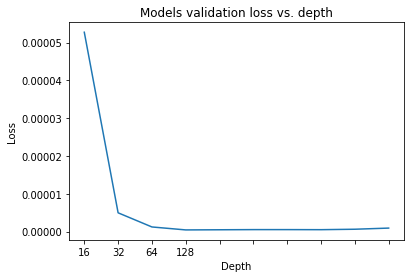

In [12]:
modelsLoss = []
modelsEpochs = []
for i in range(1,11):
    numOfLayers = 1
    numOfNeurons = i 
    [model, validatoinLoss, numOfEpochs] = trainLSTM(numOfLayers, numOfNeurons)
    modelsLoss.append(validatoinLoss)# = [modelsLoss,validatoinLoss]
    modelsEpochs.append(numOfEpochs)

plt.plot(modelsLoss)
plt.title('Models validation loss vs. depth')
plt.ylabel('Loss')
plt.xlabel('Depth')
plt.xticks(np.arange(10),['1','2','3','4','5','6','7','8','9','10'])
plt.show()

As you can see below, the loss is decreasing dramatically when we get from 1 to 4 neurons and then becomes flat with a slight rise in the end. As we cannot say for sure that it will increase after 10 neurons we tried to increase the number of neurons in our next test.

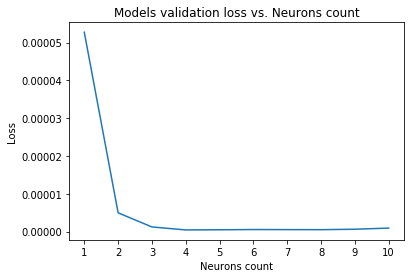

In [20]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. Neurons count')
plt.ylabel('Loss')
plt.xlabel('Neurons count')
plt.xticks(np.arange(10),['1','2','3','4','5','6','7','8','9','10'])
#plt.legend(['validation'], loc='upper left')
plt.show()

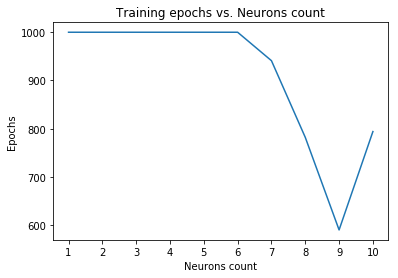

In [22]:
plt.plot(modelsEpochs)
#plt.plot(history.history['val_loss'])
plt.title('Training epochs vs. Neurons count')
plt.ylabel('Epochs')
plt.xlabel('Neurons count')
plt.xticks(np.arange(10),['1','2','3','4','5','6','7','8','9','10'])
#plt.legend(['validation'], loc='upper left')
plt.show()

#### More Neurons: 
Here we tried neurons count 10,20 ... 50 to make sure is the loss is worse with more neurons.

In [16]:
modelsLoss = []
modelsEpochs = []
for i in range(1,6):
    
    numOfLayers = 1
    numOfNeurons = i * 10 #np.power(2,i)
    #[best_model,loss_history] = trainLSTM(numOfLayers, numOfNeurons)
    [model, validatoinLoss, numOfEpochs,_] = trainLSTM(numOfLayers, numOfNeurons)
    modelsLoss.append(validatoinLoss)# = [modelsLoss,validatoinLoss]
    modelsEpochs.append(numOfEpochs)
    #K.clear_session()
    #del best_model
    #gc.collect()

Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100, 10)           480       
_________________________________________________________________
dense_14 (Dense)             (None, 100, 1)            11        
_________________________________________________________________
activation_14 (Activation)   (None, 100, 1)            0         
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.1204 - val_loss: 0.1165
Epoch 2/1000
900/900 [==============================] - 1s 761us/step - loss: 0.1141 - val_loss: 0.1107
Epoch 3/1000
900/900 [==============================] - 1s 767us/step - loss: 0.1087 - val_loss: 0.1061
Epoch 4/1000
900/900 [==============

900/900 [==============================] - 1s 740us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 149/1000
900/900 [==============================] - 1s 747us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 150/1000
900/900 [==============================] - 1s 757us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 151/1000
900/900 [==============================] - 1s 761us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 152/1000
900/900 [==============================] - 1s 768us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 153/1000
900/900 [==============================] - 1s 764us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 154/1000
900/900 [==============================] - 1s 749us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 155/1000
900/900 [==============================] - 1s 770us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 156/1000
900/900 [==============================] - 1s 750us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 157/1000
900/900 [==============================] - 1s 

Epoch 293/1000
900/900 [==============================] - 1s 762us/step - loss: 1.4505e-04 - val_loss: 3.8159e-05
Epoch 294/1000
900/900 [==============================] - 1s 770us/step - loss: 1.4378e-04 - val_loss: 3.7251e-05
Epoch 295/1000
900/900 [==============================] - 1s 786us/step - loss: 1.4259e-04 - val_loss: 3.6450e-05
Epoch 296/1000
900/900 [==============================] - 1s 754us/step - loss: 1.4135e-04 - val_loss: 3.5642e-05
Epoch 297/1000
900/900 [==============================] - 1s 767us/step - loss: 1.4014e-04 - val_loss: 3.4833e-05
Epoch 298/1000
900/900 [==============================] - 1s 776us/step - loss: 1.3896e-04 - val_loss: 3.4022e-05
Epoch 299/1000
900/900 [==============================] - 1s 779us/step - loss: 1.3780e-04 - val_loss: 3.3221e-05
Epoch 300/1000
900/900 [==============================] - 1s 738us/step - loss: 1.3670e-04 - val_loss: 3.2499e-05
Epoch 301/1000
900/900 [==============================] - 1s 767us/step - loss: 1.3561e-

Epoch 365/1000
900/900 [==============================] - 1s 760us/step - loss: 8.7955e-05 - val_loss: 1.1365e-05
Epoch 366/1000
900/900 [==============================] - 1s 762us/step - loss: 8.7409e-05 - val_loss: 1.1237e-05
Epoch 367/1000
900/900 [==============================] - 1s 760us/step - loss: 8.6881e-05 - val_loss: 1.1121e-05
Epoch 368/1000
900/900 [==============================] - 1s 749us/step - loss: 8.6343e-05 - val_loss: 1.0982e-05
Epoch 369/1000
900/900 [==============================] - 1s 781us/step - loss: 8.5846e-05 - val_loss: 1.0871e-05
Epoch 370/1000
900/900 [==============================] - 1s 772us/step - loss: 8.5303e-05 - val_loss: 1.0746e-05
Epoch 371/1000
900/900 [==============================] - 1s 776us/step - loss: 8.4790e-05 - val_loss: 1.0623e-05
Epoch 372/1000
900/900 [==============================] - 1s 771us/step - loss: 8.4267e-05 - val_loss: 1.0503e-05
Epoch 373/1000
900/900 [==============================] - 1s 786us/step - loss: 8.3789e-

Epoch 508/1000
900/900 [==============================] - 1s 747us/step - loss: 3.8888e-05 - val_loss: 4.2282e-06
Epoch 509/1000
900/900 [==============================] - 1s 762us/step - loss: 3.8671e-05 - val_loss: 4.2086e-06
Epoch 510/1000
900/900 [==============================] - 1s 749us/step - loss: 3.8475e-05 - val_loss: 4.1969e-06
Epoch 511/1000
900/900 [==============================] - 1s 765us/step - loss: 3.8255e-05 - val_loss: 4.1775e-06
Epoch 512/1000
900/900 [==============================] - 1s 756us/step - loss: 3.8058e-05 - val_loss: 4.1675e-06
Epoch 513/1000
900/900 [==============================] - 1s 759us/step - loss: 3.7855e-05 - val_loss: 4.1505e-06
Epoch 514/1000
900/900 [==============================] - 1s 739us/step - loss: 3.7654e-05 - val_loss: 4.1397e-06
Epoch 515/1000
900/900 [==============================] - 1s 752us/step - loss: 3.7453e-05 - val_loss: 4.1202e-06
Epoch 516/1000
900/900 [==============================] - 1s 750us/step - loss: 3.7246e-

Epoch 580/1000
900/900 [==============================] - 1s 759us/step - loss: 2.6616e-05 - val_loss: 3.3572e-06
Epoch 581/1000
900/900 [==============================] - 1s 767us/step - loss: 2.6483e-05 - val_loss: 3.3507e-06
Epoch 582/1000
900/900 [==============================] - 1s 757us/step - loss: 2.6337e-05 - val_loss: 3.3484e-06
Epoch 583/1000
900/900 [==============================] - 1s 745us/step - loss: 2.6211e-05 - val_loss: 3.3244e-06
Epoch 584/1000
900/900 [==============================] - 1s 755us/step - loss: 2.6068e-05 - val_loss: 3.3138e-06
Epoch 585/1000
900/900 [==============================] - 1s 766us/step - loss: 2.5938e-05 - val_loss: 3.3127e-06
Epoch 586/1000
900/900 [==============================] - 1s 764us/step - loss: 2.5821e-05 - val_loss: 3.3098e-06
Epoch 587/1000
900/900 [==============================] - 1s 750us/step - loss: 2.5685e-05 - val_loss: 3.3178e-06
Epoch 588/1000
900/900 [==============================] - 1s 767us/step - loss: 2.5552e-

Epoch 652/1000
900/900 [==============================] - 1s 767us/step - loss: 1.8462e-05 - val_loss: 2.7025e-06
Epoch 653/1000
900/900 [==============================] - 1s 744us/step - loss: 1.8380e-05 - val_loss: 2.6969e-06
Epoch 654/1000
900/900 [==============================] - 1s 737us/step - loss: 1.8312e-05 - val_loss: 2.7125e-06
Epoch 655/1000
900/900 [==============================] - 1s 745us/step - loss: 1.8210e-05 - val_loss: 2.7034e-06
Epoch 656/1000
900/900 [==============================] - 1s 764us/step - loss: 1.8113e-05 - val_loss: 2.6783e-06
Epoch 657/1000
900/900 [==============================] - 1s 756us/step - loss: 1.8029e-05 - val_loss: 2.6843e-06
Epoch 658/1000
900/900 [==============================] - 1s 756us/step - loss: 1.7955e-05 - val_loss: 2.6619e-06
Epoch 659/1000
900/900 [==============================] - 1s 767us/step - loss: 1.7860e-05 - val_loss: 2.6829e-06
Epoch 660/1000
900/900 [==============================] - 1s 755us/step - loss: 1.7802e-

Epoch 724/1000
900/900 [==============================] - 1s 768us/step - loss: 1.3145e-05 - val_loss: 2.1820e-06
Epoch 725/1000
900/900 [==============================] - 1s 757us/step - loss: 1.3087e-05 - val_loss: 2.1520e-06
Epoch 726/1000
900/900 [==============================] - 1s 785us/step - loss: 1.3021e-05 - val_loss: 2.1611e-06
Epoch 727/1000
900/900 [==============================] - 1s 785us/step - loss: 1.2960e-05 - val_loss: 2.1270e-06
Epoch 728/1000
900/900 [==============================] - 1s 787us/step - loss: 1.2885e-05 - val_loss: 2.0946e-06
Epoch 729/1000
900/900 [==============================] - 1s 769us/step - loss: 1.2834e-05 - val_loss: 2.0927e-06
Epoch 730/1000
900/900 [==============================] - 1s 781us/step - loss: 1.2766e-05 - val_loss: 2.0878e-06
Epoch 731/1000
900/900 [==============================] - 1s 783us/step - loss: 1.2710e-05 - val_loss: 2.1416e-06
Epoch 732/1000
900/900 [==============================] - 1s 785us/step - loss: 1.2663e-

Epoch 796/1000
900/900 [==============================] - 1s 770us/step - loss: 9.5287e-06 - val_loss: 1.7095e-06
Epoch 797/1000
900/900 [==============================] - 1s 768us/step - loss: 9.4722e-06 - val_loss: 1.5866e-06
Epoch 798/1000
900/900 [==============================] - 1s 770us/step - loss: 9.3905e-06 - val_loss: 1.7227e-06
Epoch 799/1000
900/900 [==============================] - 1s 768us/step - loss: 9.4207e-06 - val_loss: 1.6080e-06
Epoch 800/1000
900/900 [==============================] - 1s 766us/step - loss: 9.2669e-06 - val_loss: 1.5677e-06
Epoch 801/1000
900/900 [==============================] - 1s 764us/step - loss: 9.2162e-06 - val_loss: 1.5581e-06
Epoch 802/1000
900/900 [==============================] - 1s 772us/step - loss: 9.1856e-06 - val_loss: 1.6019e-06
Epoch 803/1000
900/900 [==============================] - 1s 759us/step - loss: 9.3408e-06 - val_loss: 1.9554e-06
Epoch 804/1000
900/900 [==============================] - 1s 760us/step - loss: 9.3426e-

Epoch 868/1000
900/900 [==============================] - 1s 754us/step - loss: 7.0091e-06 - val_loss: 1.2304e-06
Epoch 869/1000
900/900 [==============================] - 1s 766us/step - loss: 6.8996e-06 - val_loss: 1.1849e-06
Epoch 870/1000
900/900 [==============================] - 1s 768us/step - loss: 6.8485e-06 - val_loss: 1.2141e-06
Epoch 871/1000
900/900 [==============================] - 1s 761us/step - loss: 6.8468e-06 - val_loss: 1.1658e-06
Epoch 872/1000
900/900 [==============================] - 1s 767us/step - loss: 6.8037e-06 - val_loss: 1.2323e-06
Epoch 873/1000
900/900 [==============================] - 1s 805us/step - loss: 6.8867e-06 - val_loss: 1.2749e-06
Epoch 874/1000
900/900 [==============================] - 1s 865us/step - loss: 6.7592e-06 - val_loss: 1.1765e-06
Epoch 875/1000
900/900 [==============================] - 1s 842us/step - loss: 6.7451e-06 - val_loss: 1.1996e-06
Epoch 876/1000
900/900 [==============================] - 1s 814us/step - loss: 6.7312e-

900/900 [==============================] - 1s 769us/step - loss: 0.0785 - val_loss: 0.0774
Epoch 5/1000
900/900 [==============================] - 1s 755us/step - loss: 0.0765 - val_loss: 0.0752
Epoch 6/1000
900/900 [==============================] - 1s 750us/step - loss: 0.0741 - val_loss: 0.0727
Epoch 7/1000
900/900 [==============================] - 1s 744us/step - loss: 0.0717 - val_loss: 0.0703
Epoch 8/1000
900/900 [==============================] - 1s 763us/step - loss: 0.0693 - val_loss: 0.0679
Epoch 9/1000
900/900 [==============================] - 1s 762us/step - loss: 0.0669 - val_loss: 0.0654
Epoch 10/1000
900/900 [==============================] - 1s 770us/step - loss: 0.0643 - val_loss: 0.0627
Epoch 11/1000
900/900 [==============================] - 1s 779us/step - loss: 0.0616 - val_loss: 0.0599
Epoch 12/1000
900/900 [==============================] - 1s 782us/step - loss: 0.0587 - val_loss: 0.0569
Epoch 13/1000
900/900 [==============================] - 1s 782us/step - l

900/900 [==============================] - 1s 782us/step - loss: 1.8294e-04 - val_loss: 8.4144e-05
Epoch 156/1000
900/900 [==============================] - 1s 779us/step - loss: 1.8150e-04 - val_loss: 8.3239e-05
Epoch 157/1000
900/900 [==============================] - 1s 737us/step - loss: 1.7938e-04 - val_loss: 7.8347e-05
Epoch 158/1000
900/900 [==============================] - 1s 767us/step - loss: 1.7271e-04 - val_loss: 6.9104e-05
Epoch 159/1000
900/900 [==============================] - 1s 749us/step - loss: 1.6605e-04 - val_loss: 6.6829e-05
Epoch 160/1000
900/900 [==============================] - 1s 759us/step - loss: 1.6417e-04 - val_loss: 6.2369e-05
Epoch 161/1000
900/900 [==============================] - 1s 765us/step - loss: 1.5952e-04 - val_loss: 5.8598e-05
Epoch 162/1000
900/900 [==============================] - 1s 761us/step - loss: 1.5698e-04 - val_loss: 5.6250e-05
Epoch 163/1000
900/900 [==============================] - 1s 767us/step - loss: 1.5402e-04 - val_loss: 

Epoch 227/1000
900/900 [==============================] - 1s 792us/step - loss: 9.1340e-05 - val_loss: 5.9830e-06
Epoch 228/1000
900/900 [==============================] - 1s 765us/step - loss: 9.0867e-05 - val_loss: 5.8683e-06
Epoch 229/1000
900/900 [==============================] - 1s 770us/step - loss: 9.0051e-05 - val_loss: 5.1557e-06
Epoch 230/1000
900/900 [==============================] - 1s 776us/step - loss: 8.9244e-05 - val_loss: 5.1666e-06
Epoch 231/1000
900/900 [==============================] - 1s 764us/step - loss: 8.8991e-05 - val_loss: 5.3232e-06
Epoch 232/1000
900/900 [==============================] - 1s 773us/step - loss: 8.9034e-05 - val_loss: 6.0283e-06
Epoch 233/1000
900/900 [==============================] - 1s 776us/step - loss: 8.9443e-05 - val_loss: 7.7654e-06
Epoch 234/1000
900/900 [==============================] - 1s 760us/step - loss: 9.3210e-05 - val_loss: 1.7263e-05
Epoch 235/1000
900/900 [==============================] - 1s 769us/step - loss: 1.0368e-

Epoch 113/1000
900/900 [==============================] - 1s 771us/step - loss: 6.8669e-04 - val_loss: 6.1034e-04
Epoch 114/1000
900/900 [==============================] - 1s 766us/step - loss: 6.6542e-04 - val_loss: 5.8887e-04
Epoch 115/1000
900/900 [==============================] - 1s 786us/step - loss: 6.4554e-04 - val_loss: 5.6844e-04
Epoch 116/1000
900/900 [==============================] - 1s 768us/step - loss: 6.2774e-04 - val_loss: 5.4974e-04
Epoch 117/1000
900/900 [==============================] - 1s 782us/step - loss: 6.1088e-04 - val_loss: 5.3367e-04
Epoch 118/1000
900/900 [==============================] - 1s 766us/step - loss: 6.0174e-04 - val_loss: 5.3857e-04
Epoch 119/1000
900/900 [==============================] - 1s 788us/step - loss: 6.3362e-04 - val_loss: 5.8256e-04
Epoch 120/1000
900/900 [==============================] - 1s 755us/step - loss: 5.9591e-04 - val_loss: 4.9753e-04
Epoch 121/1000
900/900 [==============================] - 1s 762us/step - loss: 5.6379e-

Epoch 185/1000
900/900 [==============================] - 1s 768us/step - loss: 1.3570e-04 - val_loss: 2.9111e-05
Epoch 186/1000
900/900 [==============================] - 1s 778us/step - loss: 1.3337e-04 - val_loss: 2.7657e-05
Epoch 187/1000
900/900 [==============================] - 1s 778us/step - loss: 1.3299e-04 - val_loss: 2.7608e-05
Epoch 188/1000
900/900 [==============================] - 1s 797us/step - loss: 1.3099e-04 - val_loss: 2.5522e-05
Epoch 189/1000
900/900 [==============================] - 1s 798us/step - loss: 1.3044e-04 - val_loss: 2.6463e-05
Epoch 190/1000
900/900 [==============================] - 1s 783us/step - loss: 1.3168e-04 - val_loss: 2.6970e-05
Epoch 191/1000
900/900 [==============================] - 1s 796us/step - loss: 1.2949e-04 - val_loss: 2.3238e-05
Epoch 192/1000
900/900 [==============================] - 1s 770us/step - loss: 1.2628e-04 - val_loss: 2.1866e-05
Epoch 193/1000
900/900 [==============================] - 1s 789us/step - loss: 1.2570e-

Epoch 257/1000
900/900 [==============================] - 1s 789us/step - loss: 8.5509e-05 - val_loss: 9.0202e-06
Epoch 258/1000
900/900 [==============================] - 1s 779us/step - loss: 8.7927e-05 - val_loss: 9.2314e-06
Epoch 259/1000
900/900 [==============================] - 1s 767us/step - loss: 8.4285e-05 - val_loss: 5.7204e-06
Epoch 260/1000
900/900 [==============================] - 1s 762us/step - loss: 8.3370e-05 - val_loss: 7.9724e-06
Epoch 261/1000
900/900 [==============================] - 1s 778us/step - loss: 8.4361e-05 - val_loss: 6.4387e-06
Epoch 262/1000
900/900 [==============================] - 1s 790us/step - loss: 8.1764e-05 - val_loss: 5.5215e-06
Epoch 263/1000
900/900 [==============================] - 1s 760us/step - loss: 8.1345e-05 - val_loss: 5.8706e-06
Epoch 264/1000
900/900 [==============================] - 1s 783us/step - loss: 8.0923e-05 - val_loss: 5.4237e-06
Epoch 265/1000
900/900 [==============================] - 1s 806us/step - loss: 8.0135e-

900/900 [==============================] - 1s 754us/step - loss: 6.2540e-04 - val_loss: 5.7061e-04
Epoch 111/1000
900/900 [==============================] - 1s 775us/step - loss: 6.0361e-04 - val_loss: 5.3232e-04
Epoch 112/1000
900/900 [==============================] - 1s 786us/step - loss: 5.8230e-04 - val_loss: 5.1434e-04
Epoch 113/1000
900/900 [==============================] - 1s 768us/step - loss: 5.6314e-04 - val_loss: 5.0454e-04
Epoch 114/1000
900/900 [==============================] - 1s 781us/step - loss: 5.4869e-04 - val_loss: 4.7710e-04
Epoch 115/1000
900/900 [==============================] - 1s 756us/step - loss: 5.2844e-04 - val_loss: 4.6345e-04
Epoch 116/1000
900/900 [==============================] - 1s 788us/step - loss: 5.1357e-04 - val_loss: 4.4341e-04
Epoch 117/1000
900/900 [==============================] - 1s 777us/step - loss: 4.9869e-04 - val_loss: 4.3476e-04
Epoch 118/1000
900/900 [==============================] - 1s 782us/step - loss: 4.8359e-04 - val_loss: 

Epoch 182/1000
900/900 [==============================] - 1s 776us/step - loss: 1.0501e-04 - val_loss: 3.1825e-05
Epoch 183/1000
900/900 [==============================] - 1s 779us/step - loss: 1.1240e-04 - val_loss: 4.4207e-05
Epoch 184/1000
900/900 [==============================] - 1s 779us/step - loss: 1.2606e-04 - val_loss: 5.9664e-05
Epoch 185/1000
900/900 [==============================] - 1s 769us/step - loss: 1.3004e-04 - val_loss: 4.1495e-05
Epoch 186/1000
900/900 [==============================] - 1s 812us/step - loss: 1.0678e-04 - val_loss: 2.4398e-05
Epoch 187/1000
900/900 [==============================] - 1s 752us/step - loss: 1.0121e-04 - val_loss: 2.8930e-05
Epoch 188/1000
900/900 [==============================] - 1s 785us/step - loss: 1.0237e-04 - val_loss: 2.5099e-05
Epoch 189/1000
900/900 [==============================] - 1s 801us/step - loss: 9.7551e-05 - val_loss: 2.2458e-05
Epoch 190/1000
900/900 [==============================] - 1s 781us/step - loss: 9.6587e-

Epoch 254/1000
900/900 [==============================] - 1s 777us/step - loss: 6.7354e-05 - val_loss: 1.4945e-05
Epoch 255/1000
900/900 [==============================] - 1s 782us/step - loss: 6.6028e-05 - val_loss: 9.5706e-06
Epoch 256/1000
900/900 [==============================] - 1s 770us/step - loss: 6.0859e-05 - val_loss: 6.2750e-06
Epoch 257/1000
900/900 [==============================] - 1s 771us/step - loss: 5.8584e-05 - val_loss: 5.8293e-06
Epoch 258/1000
900/900 [==============================] - 1s 756us/step - loss: 5.8066e-05 - val_loss: 5.9000e-06
Epoch 259/1000
900/900 [==============================] - 1s 776us/step - loss: 5.7736e-05 - val_loss: 5.7166e-06
Epoch 260/1000
900/900 [==============================] - 1s 781us/step - loss: 5.7343e-05 - val_loss: 5.9884e-06
Epoch 261/1000
900/900 [==============================] - 1s 773us/step - loss: 5.7815e-05 - val_loss: 7.0581e-06
Epoch 262/1000
900/900 [==============================] - 1s 798us/step - loss: 6.0694e-

Epoch 326/1000
900/900 [==============================] - 1s 783us/step - loss: 3.7256e-05 - val_loss: 2.6903e-06
Epoch 327/1000
900/900 [==============================] - 1s 778us/step - loss: 3.7142e-05 - val_loss: 3.0400e-06
Epoch 328/1000
900/900 [==============================] - 1s 769us/step - loss: 3.7334e-05 - val_loss: 3.7109e-06
Epoch 329/1000
900/900 [==============================] - 1s 772us/step - loss: 3.8848e-05 - val_loss: 8.1218e-06
Epoch 330/1000
900/900 [==============================] - 1s 767us/step - loss: 5.2367e-05 - val_loss: 5.2868e-05
Epoch 331/1000
900/900 [==============================] - 1s 772us/step - loss: 1.5646e-04 - val_loss: 2.3328e-04
Epoch 332/1000
900/900 [==============================] - 1s 800us/step - loss: 1.6693e-04 - val_loss: 1.1322e-05
Epoch 333/1000
900/900 [==============================] - 1s 780us/step - loss: 8.9877e-05 - val_loss: 9.5378e-06
Epoch 334/1000
900/900 [==============================] - 1s 780us/step - loss: 5.9288e-

900/900 [==============================] - 1s 765us/step - loss: 3.2847e-04 - val_loss: 2.2224e-04
Epoch 135/1000
900/900 [==============================] - 1s 772us/step - loss: 3.2243e-04 - val_loss: 1.9500e-04
Epoch 136/1000
900/900 [==============================] - 1s 779us/step - loss: 3.0117e-04 - val_loss: 1.9762e-04
Epoch 137/1000
900/900 [==============================] - 1s 783us/step - loss: 2.8837e-04 - val_loss: 1.8720e-04
Epoch 138/1000
900/900 [==============================] - 1s 778us/step - loss: 2.8043e-04 - val_loss: 1.6805e-04
Epoch 139/1000
900/900 [==============================] - 1s 781us/step - loss: 2.6885e-04 - val_loss: 1.5955e-04
Epoch 140/1000
900/900 [==============================] - 1s 767us/step - loss: 2.6054e-04 - val_loss: 1.5354e-04
Epoch 141/1000
900/900 [==============================] - 1s 783us/step - loss: 2.5208e-04 - val_loss: 1.4543e-04
Epoch 142/1000
900/900 [==============================] - 1s 775us/step - loss: 2.4541e-04 - val_loss: 

Epoch 206/1000
900/900 [==============================] - 1s 785us/step - loss: 1.0084e-04 - val_loss: 8.9871e-06
Epoch 207/1000
900/900 [==============================] - 1s 786us/step - loss: 9.8944e-05 - val_loss: 9.0995e-06
Epoch 208/1000
900/900 [==============================] - 1s 781us/step - loss: 9.8232e-05 - val_loss: 8.7411e-06
Epoch 209/1000
900/900 [==============================] - 1s 781us/step - loss: 9.7844e-05 - val_loss: 8.2774e-06
Epoch 210/1000
900/900 [==============================] - 1s 765us/step - loss: 9.7263e-05 - val_loss: 1.0467e-05
Epoch 211/1000
900/900 [==============================] - 1s 760us/step - loss: 9.8018e-05 - val_loss: 8.3879e-06
Epoch 212/1000
900/900 [==============================] - 1s 803us/step - loss: 9.5725e-05 - val_loss: 9.0335e-06
Epoch 213/1000
900/900 [==============================] - 1s 757us/step - loss: 9.8404e-05 - val_loss: 1.5401e-05
Epoch 214/1000
900/900 [==============================] - 1s 772us/step - loss: 1.0391e-

As you can see in the figure below, more neurons cause worse results. Hence we picked the best number of neurons from the range below 10, in which the best was 4 neurons.

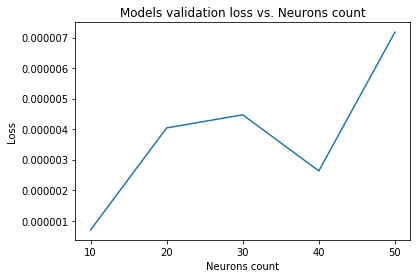

In [19]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. Neurons count')
plt.ylabel('Loss')
plt.xlabel('Neurons count')
plt.xticks(np.arange(5),['10','20','30','40','50'])
#plt.legend(['validation'], loc='upper left')
plt.show()

### Tuning Depth
In next step we try to pick the best Depth for LSTM layers from the range 1 to 5.

In [23]:
modelsLoss = []
modelsEpochs = []
for i in range(1,6):
    numOfLayers = i
    numOfNeurons = 4
    [model, validatoinLoss, numOfEpochs,_] = trainLSTM(numOfLayers, numOfNeurons)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100, 4)            96        
_________________________________________________________________
dense_19 (Dense)             (None, 100, 1)            5         
_________________________________________________________________
activation_19 (Activation)   (None, 100, 1)            0         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 2s 3ms/step - loss: 0.1042 - val_loss: 0.1025
Epoch 2/1000
900/900 [==============================] - 1s 764us/step - loss: 0.1014 - val_loss: 0.0999
Epoch 3/1000
900/900 [==============================] - 1s 783us/step - loss: 0.0990 - val_loss: 0.0979
Epoch 4/1000
900/900 [==============

900/900 [==============================] - 1s 766us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 149/1000
900/900 [==============================] - 1s 769us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 150/1000
900/900 [==============================] - 1s 758us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 151/1000
900/900 [==============================] - 1s 758us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 152/1000
900/900 [==============================] - 1s 780us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 153/1000
900/900 [==============================] - 1s 752us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 154/1000
900/900 [==============================] - 1s 760us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 155/1000
900/900 [==============================] - 1s 777us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 156/1000
900/900 [==============================] - 1s 776us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 157/1000
900/900 [==============================] - 1s 

Epoch 221/1000
900/900 [==============================] - 1s 752us/step - loss: 5.4689e-04 - val_loss: 5.2881e-04
Epoch 222/1000
900/900 [==============================] - 1s 765us/step - loss: 5.4161e-04 - val_loss: 5.2334e-04
Epoch 223/1000
900/900 [==============================] - 1s 759us/step - loss: 5.3642e-04 - val_loss: 5.1791e-04
Epoch 224/1000
900/900 [==============================] - 1s 775us/step - loss: 5.3125e-04 - val_loss: 5.1248e-04
Epoch 225/1000
900/900 [==============================] - 1s 759us/step - loss: 5.2612e-04 - val_loss: 5.0711e-04
Epoch 226/1000
900/900 [==============================] - 1s 788us/step - loss: 5.2104e-04 - val_loss: 5.0178e-04
Epoch 227/1000
900/900 [==============================] - 1s 770us/step - loss: 5.1596e-04 - val_loss: 4.9647e-04
Epoch 228/1000
900/900 [==============================] - 1s 791us/step - loss: 5.1093e-04 - val_loss: 4.9120e-04
Epoch 229/1000
900/900 [==============================] - 1s 786us/step - loss: 5.0598e-

Epoch 293/1000
900/900 [==============================] - 1s 778us/step - loss: 2.3198e-04 - val_loss: 1.9337e-04
Epoch 294/1000
900/900 [==============================] - 1s 772us/step - loss: 2.2882e-04 - val_loss: 1.8997e-04
Epoch 295/1000
900/900 [==============================] - 1s 795us/step - loss: 2.2569e-04 - val_loss: 1.8661e-04
Epoch 296/1000
900/900 [==============================] - 1s 760us/step - loss: 2.2259e-04 - val_loss: 1.8330e-04
Epoch 297/1000
900/900 [==============================] - 1s 772us/step - loss: 2.1954e-04 - val_loss: 1.8002e-04
Epoch 298/1000
900/900 [==============================] - 1s 783us/step - loss: 2.1653e-04 - val_loss: 1.7679e-04
Epoch 299/1000
900/900 [==============================] - 1s 754us/step - loss: 2.1355e-04 - val_loss: 1.7359e-04
Epoch 300/1000
900/900 [==============================] - 1s 758us/step - loss: 2.1061e-04 - val_loss: 1.7044e-04
Epoch 301/1000
900/900 [==============================] - 1s 765us/step - loss: 2.0771e-

Epoch 365/1000
900/900 [==============================] - 1s 776us/step - loss: 9.4423e-05 - val_loss: 4.7855e-05
Epoch 366/1000
900/900 [==============================] - 1s 796us/step - loss: 9.3572e-05 - val_loss: 4.6994e-05
Epoch 367/1000
900/900 [==============================] - 1s 795us/step - loss: 9.2731e-05 - val_loss: 4.6157e-05
Epoch 368/1000
900/900 [==============================] - 1s 777us/step - loss: 9.1910e-05 - val_loss: 4.5347e-05
Epoch 369/1000
900/900 [==============================] - 1s 814us/step - loss: 9.1105e-05 - val_loss: 4.4560e-05
Epoch 370/1000
900/900 [==============================] - 1s 803us/step - loss: 9.0317e-05 - val_loss: 4.3771e-05
Epoch 371/1000
900/900 [==============================] - 1s 791us/step - loss: 8.9544e-05 - val_loss: 4.3001e-05
Epoch 372/1000
900/900 [==============================] - 1s 782us/step - loss: 8.8781e-05 - val_loss: 4.2259e-05
Epoch 373/1000
900/900 [==============================] - 1s 776us/step - loss: 8.8039e-

Epoch 437/1000
900/900 [==============================] - 1s 770us/step - loss: 5.8278e-05 - val_loss: 1.6301e-05
Epoch 438/1000
900/900 [==============================] - 1s 750us/step - loss: 5.7974e-05 - val_loss: 1.6110e-05
Epoch 439/1000
900/900 [==============================] - 1s 771us/step - loss: 5.7687e-05 - val_loss: 1.5907e-05
Epoch 440/1000
900/900 [==============================] - 1s 777us/step - loss: 5.7400e-05 - val_loss: 1.5737e-05
Epoch 441/1000
900/900 [==============================] - 1s 775us/step - loss: 5.7109e-05 - val_loss: 1.5574e-05
Epoch 442/1000
900/900 [==============================] - 1s 778us/step - loss: 5.6817e-05 - val_loss: 1.5387e-05
Epoch 443/1000
900/900 [==============================] - 1s 761us/step - loss: 5.6534e-05 - val_loss: 1.5208e-05
Epoch 444/1000
900/900 [==============================] - 1s 777us/step - loss: 5.6247e-05 - val_loss: 1.5031e-05
Epoch 445/1000
900/900 [==============================] - 1s 781us/step - loss: 5.5973e-

Epoch 509/1000
900/900 [==============================] - 1s 790us/step - loss: 4.2112e-05 - val_loss: 8.4072e-06
Epoch 510/1000
900/900 [==============================] - ETA: 0s - loss: 4.0624e-0 - 1s 782us/step - loss: 4.1943e-05 - val_loss: 8.3379e-06
Epoch 511/1000
900/900 [==============================] - 1s 779us/step - loss: 4.1772e-05 - val_loss: 8.2828e-06
Epoch 512/1000
900/900 [==============================] - 1s 798us/step - loss: 4.1589e-05 - val_loss: 8.2310e-06
Epoch 513/1000
900/900 [==============================] - 1s 789us/step - loss: 4.1418e-05 - val_loss: 8.1553e-06
Epoch 514/1000
900/900 [==============================] - 1s 790us/step - loss: 4.1253e-05 - val_loss: 8.1016e-06
Epoch 515/1000
900/900 [==============================] - 1s 771us/step - loss: 4.1083e-05 - val_loss: 8.0584e-06
Epoch 516/1000
900/900 [==============================] - 1s 772us/step - loss: 4.0901e-05 - val_loss: 7.9940e-06
Epoch 517/1000
900/900 [==============================] - 1s

Epoch 652/1000
900/900 [==============================] - 1s 778us/step - loss: 2.3035e-05 - val_loss: 3.5763e-06
Epoch 653/1000
900/900 [==============================] - 1s 770us/step - loss: 2.2938e-05 - val_loss: 3.5577e-06
Epoch 654/1000
900/900 [==============================] - 1s 759us/step - loss: 2.2839e-05 - val_loss: 3.5451e-06
Epoch 655/1000
900/900 [==============================] - 1s 748us/step - loss: 2.2737e-05 - val_loss: 3.5301e-06
Epoch 656/1000
900/900 [==============================] - 1s 764us/step - loss: 2.2631e-05 - val_loss: 3.5112e-06
Epoch 657/1000
900/900 [==============================] - 1s 772us/step - loss: 2.2532e-05 - val_loss: 3.4948e-06
Epoch 658/1000
900/900 [==============================] - 1s 764us/step - loss: 2.2432e-05 - val_loss: 3.4785e-06
Epoch 659/1000
900/900 [==============================] - 1s 744us/step - loss: 2.2331e-05 - val_loss: 3.4604e-06
Epoch 660/1000
900/900 [==============================] - 1s 788us/step - loss: 2.2231e-

Epoch 724/1000
900/900 [==============================] - 1s 796us/step - loss: 1.6508e-05 - val_loss: 2.5167e-06
Epoch 725/1000
900/900 [==============================] - 1s 775us/step - loss: 1.6430e-05 - val_loss: 2.5097e-06
Epoch 726/1000
900/900 [==============================] - 1s 771us/step - loss: 1.6349e-05 - val_loss: 2.4971e-06
Epoch 727/1000
900/900 [==============================] - 1s 752us/step - loss: 1.6268e-05 - val_loss: 2.4814e-06
Epoch 728/1000
900/900 [==============================] - 1s 777us/step - loss: 1.6191e-05 - val_loss: 2.4682e-06
Epoch 729/1000
900/900 [==============================] - 1s 783us/step - loss: 1.6109e-05 - val_loss: 2.4525e-06
Epoch 730/1000
900/900 [==============================] - 1s 783us/step - loss: 1.6034e-05 - val_loss: 2.4426e-06
Epoch 731/1000
900/900 [==============================] - 1s 792us/step - loss: 1.5956e-05 - val_loss: 2.4304e-06
Epoch 732/1000
900/900 [==============================] - 1s 785us/step - loss: 1.5880e-

Epoch 796/1000
900/900 [==============================] - 1s 765us/step - loss: 1.1513e-05 - val_loss: 1.8167e-06
Epoch 797/1000
900/900 [==============================] - 1s 770us/step - loss: 1.1452e-05 - val_loss: 1.8054e-06
Epoch 798/1000
900/900 [==============================] - 1s 767us/step - loss: 1.1392e-05 - val_loss: 1.7965e-06
Epoch 799/1000
900/900 [==============================] - 1s 762us/step - loss: 1.1334e-05 - val_loss: 1.7908e-06
Epoch 800/1000
900/900 [==============================] - 1s 755us/step - loss: 1.1281e-05 - val_loss: 1.7902e-06
Epoch 801/1000
900/900 [==============================] - 1s 761us/step - loss: 1.1222e-05 - val_loss: 1.7810e-06
Epoch 802/1000
900/900 [==============================] - 1s 773us/step - loss: 1.1162e-05 - val_loss: 1.7698e-06
Epoch 803/1000
900/900 [==============================] - 1s 762us/step - loss: 1.1106e-05 - val_loss: 1.7654e-06
Epoch 804/1000
900/900 [==============================] - 1s 762us/step - loss: 1.1048e-

Epoch 868/1000
900/900 [==============================] - 1s 776us/step - loss: 7.8842e-06 - val_loss: 1.3394e-06
Epoch 869/1000
900/900 [==============================] - 1s 761us/step - loss: 7.8431e-06 - val_loss: 1.3353e-06
Epoch 870/1000
900/900 [==============================] - 1s 775us/step - loss: 7.7978e-06 - val_loss: 1.3278e-06
Epoch 871/1000
900/900 [==============================] - 1s 776us/step - loss: 7.7551e-06 - val_loss: 1.3203e-06
Epoch 872/1000
900/900 [==============================] - 1s 771us/step - loss: 7.7136e-06 - val_loss: 1.3172e-06
Epoch 873/1000
900/900 [==============================] - 1s 748us/step - loss: 7.6750e-06 - val_loss: 1.3147e-06
Epoch 874/1000
900/900 [==============================] - 1s 785us/step - loss: 7.6303e-06 - val_loss: 1.3071e-06
Epoch 875/1000
900/900 [==============================] - 1s 769us/step - loss: 7.5889e-06 - val_loss: 1.3006e-06
Epoch 876/1000
900/900 [==============================] - 1s 780us/step - loss: 7.5480e-

Epoch 940/1000
900/900 [==============================] - 1s 762us/step - loss: 5.3085e-06 - val_loss: 9.5393e-07
Epoch 941/1000
900/900 [==============================] - 1s 773us/step - loss: 5.2807e-06 - val_loss: 9.5136e-07
Epoch 942/1000
900/900 [==============================] - 1s 767us/step - loss: 5.2514e-06 - val_loss: 9.4504e-07
Epoch 943/1000
900/900 [==============================] - 1s 769us/step - loss: 5.2208e-06 - val_loss: 9.4115e-07
Epoch 944/1000
900/900 [==============================] - 1s 771us/step - loss: 5.1934e-06 - val_loss: 9.3559e-07
Epoch 945/1000
900/900 [==============================] - 1s 776us/step - loss: 5.1636e-06 - val_loss: 9.2917e-07
Epoch 946/1000
900/900 [==============================] - 1s 768us/step - loss: 5.1355e-06 - val_loss: 9.2272e-07
Epoch 947/1000
900/900 [==============================] - 1s 757us/step - loss: 5.1082e-06 - val_loss: 9.1991e-07
Epoch 948/1000
900/900 [==============================] - 1s 767us/step - loss: 5.0800e-

900/900 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 84/1000
900/900 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 85/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 86/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 87/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 88/1000
900/900 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 89/1000
900/900 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 90/1000
900/900 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 91/1000
900/900 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 92/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0014 - v

900/900 [==============================] - 1s 2ms/step - loss: 2.3648e-04 - val_loss: 1.8751e-04
Epoch 159/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.3067e-04 - val_loss: 1.8109e-04
Epoch 160/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2505e-04 - val_loss: 1.7491e-04
Epoch 161/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.1963e-04 - val_loss: 1.6893e-04
Epoch 162/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.1440e-04 - val_loss: 1.6314e-04
Epoch 163/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.0928e-04 - val_loss: 1.5758e-04
Epoch 164/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.0439e-04 - val_loss: 1.5218e-04
Epoch 165/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.9968e-04 - val_loss: 1.4699e-04
Epoch 166/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.9508e-04 - val_loss: 1.4200e-04
Epoch 1

900/900 [==============================] - 1s 2ms/step - loss: 5.1427e-05 - val_loss: 1.1215e-05
Epoch 305/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.1130e-05 - val_loss: 1.1121e-05
Epoch 306/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.0865e-05 - val_loss: 1.1006e-05
Epoch 307/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.0581e-05 - val_loss: 1.0903e-05
Epoch 308/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.0313e-05 - val_loss: 1.0819e-05
Epoch 309/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.0035e-05 - val_loss: 1.0742e-05
Epoch 310/1000
900/900 [==============================] - 1s 2ms/step - loss: 4.9763e-05 - val_loss: 1.0631e-05
Epoch 311/1000
900/900 [==============================] - 1s 2ms/step - loss: 4.9480e-05 - val_loss: 1.0547e-05
Epoch 312/1000
900/900 [==============================] - 1s 2ms/step - loss: 4.9207e-05 - val_loss: 1.0477e-05
Epoch 3

900/900 [==============================] - 1s 2ms/step - loss: 2.3335e-05 - val_loss: 4.0149e-06
Epoch 451/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.3203e-05 - val_loss: 3.9971e-06
Epoch 452/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.3073e-05 - val_loss: 3.9690e-06
Epoch 453/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2953e-05 - val_loss: 3.9427e-06
Epoch 454/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2823e-05 - val_loss: 3.9095e-06
Epoch 455/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2696e-05 - val_loss: 3.8801e-06
Epoch 456/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2574e-05 - val_loss: 3.8515e-06
Epoch 457/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2448e-05 - val_loss: 3.8296e-06
Epoch 458/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2330e-05 - val_loss: 3.8127e-06
Epoch 4

900/900 [==============================] - 1s 2ms/step - loss: 1.0611e-05 - val_loss: 1.6934e-06
Epoch 597/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.0558e-05 - val_loss: 1.7052e-06
Epoch 598/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.0503e-05 - val_loss: 1.6774e-06
Epoch 599/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.0449e-05 - val_loss: 1.6715e-06
Epoch 600/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.0401e-05 - val_loss: 1.6631e-06
Epoch 601/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.0342e-05 - val_loss: 1.6597e-06
Epoch 602/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.0289e-05 - val_loss: 1.6390e-06
Epoch 603/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.0240e-05 - val_loss: 1.6288e-06
Epoch 604/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.0186e-05 - val_loss: 1.6343e-06
Epoch 6

900/900 [==============================] - 1s 2ms/step - loss: 5.4315e-06 - val_loss: 7.7898e-07
Epoch 743/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.4110e-06 - val_loss: 7.7448e-07
Epoch 744/1000
900/900 [==============================] - 1s 1ms/step - loss: 5.3895e-06 - val_loss: 7.7077e-07
Epoch 745/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.3704e-06 - val_loss: 7.6900e-07
Epoch 746/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.3518e-06 - val_loss: 7.7258e-07
Epoch 747/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.3290e-06 - val_loss: 7.6156e-07
Epoch 748/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.3088e-06 - val_loss: 7.5866e-07
Epoch 749/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.2893e-06 - val_loss: 7.6723e-07
Epoch 750/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.2741e-06 - val_loss: 7.5977e-07
Epoch 7

900/900 [==============================] - 1s 2ms/step - loss: 3.3216e-06 - val_loss: 4.0653e-07
Epoch 889/1000
900/900 [==============================] - 1s 2ms/step - loss: 3.3058e-06 - val_loss: 4.4847e-07
Epoch 890/1000
900/900 [==============================] - 1s 2ms/step - loss: 3.2917e-06 - val_loss: 4.0240e-07
Epoch 891/1000
900/900 [==============================] - 1s 2ms/step - loss: 3.2672e-06 - val_loss: 4.2245e-07
Epoch 892/1000
900/900 [==============================] - 1s 2ms/step - loss: 3.2599e-06 - val_loss: 4.0119e-07
Epoch 893/1000
900/900 [==============================] - 1s 2ms/step - loss: 3.2501e-06 - val_loss: 4.1638e-07
Epoch 894/1000
900/900 [==============================] - 1s 2ms/step - loss: 3.2562e-06 - val_loss: 4.3897e-07
Epoch 895/1000
900/900 [==============================] - 1s 2ms/step - loss: 3.2444e-06 - val_loss: 3.9936e-07
Epoch 896/1000
900/900 [==============================] - 1s 2ms/step - loss: 3.2128e-06 - val_loss: 3.9241e-07
Epoch 8

900/900 [==============================] - 2s 2ms/step - loss: 0.0896 - val_loss: 0.0896
Epoch 28/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0895 - val_loss: 0.0895
Epoch 29/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0894 - val_loss: 0.0893
Epoch 30/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0892 - val_loss: 0.0891
Epoch 31/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0890 - val_loss: 0.0889
Epoch 32/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0888 - val_loss: 0.0887
Epoch 33/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0885 - val_loss: 0.0884
Epoch 34/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0882 - val_loss: 0.0880
Epoch 35/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0878 - val_loss: 0.0876
Epoch 36/1000
900/900 [==============================] - 2s 2ms/step - loss: 0.0874 - v

Epoch 180/1000
900/900 [==============================] - 2s 2ms/step - loss: 3.0466e-04 - val_loss: 6.6165e-05
Epoch 181/1000
900/900 [==============================] - 2s 2ms/step - loss: 3.0119e-04 - val_loss: 6.4697e-05
Epoch 182/1000
900/900 [==============================] - 2s 2ms/step - loss: 2.9814e-04 - val_loss: 6.3144e-05
Epoch 183/1000
900/900 [==============================] - 2s 2ms/step - loss: 2.9517e-04 - val_loss: 6.2150e-05
Epoch 184/1000
900/900 [==============================] - 2s 2ms/step - loss: 2.9192e-04 - val_loss: 6.1131e-05
Epoch 185/1000
900/900 [==============================] - 2s 2ms/step - loss: 2.8899e-04 - val_loss: 5.9656e-05
Epoch 186/1000
900/900 [==============================] - 2s 2ms/step - loss: 2.8584e-04 - val_loss: 5.8825e-05
Epoch 187/1000
900/900 [==============================] - 2s 2ms/step - loss: 2.8277e-04 - val_loss: 5.7475e-05
Epoch 188/1000
900/900 [==============================] - 2s 2ms/step - loss: 2.7986e-04 - val_loss: 5.6

900/900 [==============================] - 2s 2ms/step - loss: 8.0254e-05 - val_loss: 1.2635e-05
Epoch 327/1000
900/900 [==============================] - 2s 2ms/step - loss: 7.9523e-05 - val_loss: 1.2452e-05
Epoch 328/1000
900/900 [==============================] - 2s 2ms/step - loss: 7.8836e-05 - val_loss: 1.2363e-05
Epoch 329/1000
900/900 [==============================] - 2s 2ms/step - loss: 7.8124e-05 - val_loss: 1.2225e-05
Epoch 330/1000
900/900 [==============================] - 2s 2ms/step - loss: 7.7484e-05 - val_loss: 1.2258e-05
Epoch 331/1000
900/900 [==============================] - 2s 2ms/step - loss: 7.6712e-05 - val_loss: 1.2056e-05
Epoch 332/1000
900/900 [==============================] - 2s 2ms/step - loss: 7.6050e-05 - val_loss: 1.1991e-05
Epoch 333/1000
900/900 [==============================] - 2s 2ms/step - loss: 7.5335e-05 - val_loss: 1.1846e-05
Epoch 334/1000
900/900 [==============================] - 2s 2ms/step - loss: 7.4677e-05 - val_loss: 1.1747e-05
Epoch 3

900/900 [==============================] - 2s 2ms/step - loss: 1.9981e-05 - val_loss: 4.1529e-06
Epoch 473/1000
900/900 [==============================] - 2s 2ms/step - loss: 1.9834e-05 - val_loss: 4.1669e-06
Epoch 474/1000
900/900 [==============================] - 2s 2ms/step - loss: 1.9629e-05 - val_loss: 4.1791e-06
Epoch 475/1000
900/900 [==============================] - 2s 2ms/step - loss: 1.9428e-05 - val_loss: 4.0799e-06
Epoch 476/1000
900/900 [==============================] - 2s 2ms/step - loss: 1.9262e-05 - val_loss: 4.0641e-06
Epoch 477/1000
900/900 [==============================] - 2s 2ms/step - loss: 1.9062e-05 - val_loss: 4.0097e-06
Epoch 478/1000
900/900 [==============================] - 2s 2ms/step - loss: 1.8852e-05 - val_loss: 3.9662e-06
Epoch 479/1000
900/900 [==============================] - 2s 2ms/step - loss: 1.8664e-05 - val_loss: 3.9559e-06
Epoch 480/1000
900/900 [==============================] - 2s 2ms/step - loss: 1.8510e-05 - val_loss: 3.8904e-06
Epoch 4

900/900 [==============================] - 2s 2ms/step - loss: 5.9288e-06 - val_loss: 1.3806e-06
Epoch 619/1000
900/900 [==============================] - 2s 2ms/step - loss: 5.9435e-06 - val_loss: 1.5688e-06
Epoch 620/1000
900/900 [==============================] - 2s 2ms/step - loss: 6.1773e-06 - val_loss: 1.6943e-06
Epoch 621/1000
900/900 [==============================] - 2s 2ms/step - loss: 5.9732e-06 - val_loss: 1.3084e-06
Epoch 622/1000
900/900 [==============================] - 2s 2ms/step - loss: 5.7689e-06 - val_loss: 1.3993e-06
Epoch 623/1000
900/900 [==============================] - 2s 2ms/step - loss: 5.8055e-06 - val_loss: 1.3152e-06
Epoch 624/1000
900/900 [==============================] - 2s 2ms/step - loss: 5.7127e-06 - val_loss: 1.4281e-06
Epoch 625/1000
900/900 [==============================] - 2s 2ms/step - loss: 5.8175e-06 - val_loss: 1.3524e-06
Epoch 626/1000
900/900 [==============================] - 2s 2ms/step - loss: 5.6536e-06 - val_loss: 1.3434e-06
Epoch 6

Epoch 43/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0880 - val_loss: 0.0878
Epoch 44/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0876 - val_loss: 0.0873
Epoch 45/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0871 - val_loss: 0.0867
Epoch 46/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0864 - val_loss: 0.0859
Epoch 47/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0855 - val_loss: 0.0850
Epoch 48/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0845 - val_loss: 0.0838
Epoch 49/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0833 - val_loss: 0.0825
Epoch 50/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0819 - val_loss: 0.0809
Epoch 51/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0803 - val_loss: 0.0792
Epoch 52/1000
900/900 [==============================] - 3s 3ms/step - lo

Epoch 201/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 202/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 203/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 204/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 205/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 206/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 207/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 208/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 209/1000
900/900 [==============================] - 3s 3ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 210/1000
900/900 [==============================] - 3s 3ms

900/900 [==============================] - 3s 3ms/step - loss: 3.0259e-04 - val_loss: 1.3329e-05
Epoch 351/1000
900/900 [==============================] - 3s 3ms/step - loss: 2.9933e-04 - val_loss: 1.3060e-05
Epoch 352/1000
900/900 [==============================] - 3s 3ms/step - loss: 2.9625e-04 - val_loss: 1.2879e-05
Epoch 353/1000
900/900 [==============================] - 3s 3ms/step - loss: 2.9302e-04 - val_loss: 1.2891e-05
Epoch 354/1000
900/900 [==============================] - 3s 3ms/step - loss: 2.9010e-04 - val_loss: 1.2527e-05
Epoch 355/1000
900/900 [==============================] - 3s 3ms/step - loss: 2.8688e-04 - val_loss: 1.2338e-05
Epoch 356/1000
900/900 [==============================] - 3s 3ms/step - loss: 2.8410e-04 - val_loss: 1.2168e-05
Epoch 357/1000
900/900 [==============================] - 3s 3ms/step - loss: 2.8103e-04 - val_loss: 1.1987e-05
Epoch 358/1000
900/900 [==============================] - 3s 3ms/step - loss: 2.7801e-04 - val_loss: 1.1802e-05
Epoch 3

900/900 [==============================] - 3s 3ms/step - loss: 8.3010e-05 - val_loss: 2.8069e-06
Epoch 497/1000
900/900 [==============================] - 3s 3ms/step - loss: 8.2462e-05 - val_loss: 2.7671e-06
Epoch 498/1000
900/900 [==============================] - 3s 3ms/step - loss: 8.1870e-05 - val_loss: 2.7517e-06
Epoch 499/1000
900/900 [==============================] - 3s 3ms/step - loss: 8.1300e-05 - val_loss: 2.7476e-06
Epoch 500/1000
900/900 [==============================] - 3s 3ms/step - loss: 8.0765e-05 - val_loss: 2.7274e-06
Epoch 501/1000
900/900 [==============================] - 3s 3ms/step - loss: 8.0219e-05 - val_loss: 2.7364e-06
Epoch 502/1000
900/900 [==============================] - 3s 3ms/step - loss: 7.9644e-05 - val_loss: 2.7016e-06
Epoch 503/1000
900/900 [==============================] - 3s 3ms/step - loss: 7.9103e-05 - val_loss: 2.6799e-06
Epoch 504/1000
900/900 [==============================] - 3s 3ms/step - loss: 7.8553e-05 - val_loss: 2.6619e-06
Epoch 5

900/900 [==============================] - 3s 3ms/step - loss: 3.5694e-05 - val_loss: 1.8433e-06
Epoch 643/1000
900/900 [==============================] - 3s 3ms/step - loss: 3.5522e-05 - val_loss: 1.8250e-06
Epoch 644/1000
900/900 [==============================] - 3s 3ms/step - loss: 3.5349e-05 - val_loss: 1.8293e-06
Epoch 645/1000
900/900 [==============================] - 3s 3ms/step - loss: 3.5189e-05 - val_loss: 1.9060e-06
Epoch 646/1000
900/900 [==============================] - 3s 3ms/step - loss: 3.5045e-05 - val_loss: 1.9124e-06
Epoch 647/1000
900/900 [==============================] - 3s 3ms/step - loss: 3.4873e-05 - val_loss: 1.9610e-06
Epoch 648/1000
900/900 [==============================] - 3s 3ms/step - loss: 3.4700e-05 - val_loss: 1.8340e-06
Epoch 649/1000
900/900 [==============================] - 3s 3ms/step - loss: 3.4511e-05 - val_loss: 1.8474e-06
Epoch 650/1000
900/900 [==============================] - 3s 3ms/step - loss: 3.4331e-05 - val_loss: 1.8046e-06
Epoch 6

900/900 [==============================] - 3s 3ms/step - loss: 1.9765e-05 - val_loss: 1.8063e-06
Epoch 00788: early stopping
Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 100, 4)            96        
_________________________________________________________________
lstm_30 (LSTM)               (None, 100, 4)            144       
_________________________________________________________________
lstm_31 (LSTM)               (None, 100, 4)            144       
_________________________________________________________________
lstm_32 (LSTM)               (None, 100, 4)            144       
_________________________________________________________________
lstm_33 (LSTM)               (None, 100, 4)            144       
_________________________________________________________________
dense_23 (Dense)             (None, 100, 1)            5         
_

900/900 [==============================] - 4s 4ms/step - loss: 0.0469 - val_loss: 0.0461
Epoch 146/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0465 - val_loss: 0.0456
Epoch 147/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0460 - val_loss: 0.0451
Epoch 148/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0455 - val_loss: 0.0447
Epoch 149/1000
900/900 [==============================] - 3s 4ms/step - loss: 0.0451 - val_loss: 0.0441
Epoch 150/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0446 - val_loss: 0.0436
Epoch 151/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0441 - val_loss: 0.0431
Epoch 152/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0436 - val_loss: 0.0426
Epoch 153/1000
900/900 [==============================] - 3s 4ms/step - loss: 0.0430 - val_loss: 0.0420
Epoch 154/1000
900/900 [==============================] - 3s 4ms/step - loss: 0

Epoch 224/1000
900/900 [==============================] - 3s 4ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 225/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 226/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 227/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 228/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 229/1000
900/900 [==============================] - 3s 4ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 230/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 231/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 232/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 233/1000
900/900 [==============================] - 4s 4ms

Epoch 303/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 304/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 305/1000
900/900 [==============================] - 3s 4ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 306/1000
900/900 [==============================] - 3s 4ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 307/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 308/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 309/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 310/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 311/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 312/1000
900/900 [==============================] - 4s 4ms

Epoch 382/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 383/1000
900/900 [==============================] - 3s 4ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 384/1000
900/900 [==============================] - 3s 4ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 385/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 386/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 387/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 388/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 389/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 390/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 391/1000
900/900 [==============================] - 4s 4ms

Epoch 458/1000
900/900 [==============================] - 3s 4ms/step - loss: 6.9598e-04 - val_loss: 2.9066e-04
Epoch 459/1000
900/900 [==============================] - 4s 4ms/step - loss: 6.8267e-04 - val_loss: 2.8236e-04
Epoch 460/1000
900/900 [==============================] - 4s 4ms/step - loss: 6.7074e-04 - val_loss: 2.7620e-04
Epoch 461/1000
900/900 [==============================] - 3s 4ms/step - loss: 6.5899e-04 - val_loss: 2.6813e-04
Epoch 462/1000
900/900 [==============================] - 4s 4ms/step - loss: 6.4704e-04 - val_loss: 2.6518e-04
Epoch 463/1000
900/900 [==============================] - 3s 4ms/step - loss: 6.3717e-04 - val_loss: 2.5502e-04
Epoch 464/1000
900/900 [==============================] - 3s 4ms/step - loss: 6.2433e-04 - val_loss: 2.5108e-04
Epoch 465/1000
900/900 [==============================] - 3s 4ms/step - loss: 6.1401e-04 - val_loss: 2.4233e-04
Epoch 466/1000
900/900 [==============================] - 3s 4ms/step - loss: 6.0219e-04 - val_loss: 2.3

900/900 [==============================] - 3s 4ms/step - loss: 1.1332e-04 - val_loss: 2.4584e-05
Epoch 605/1000
900/900 [==============================] - 4s 4ms/step - loss: 1.1097e-04 - val_loss: 2.4523e-05
Epoch 606/1000
900/900 [==============================] - 4s 4ms/step - loss: 1.0797e-04 - val_loss: 2.3342e-05
Epoch 607/1000
900/900 [==============================] - 4s 4ms/step - loss: 1.0685e-04 - val_loss: 2.3806e-05
Epoch 608/1000
900/900 [==============================] - 3s 4ms/step - loss: 1.0634e-04 - val_loss: 2.3282e-05
Epoch 609/1000
900/900 [==============================] - 4s 4ms/step - loss: 1.0551e-04 - val_loss: 2.2896e-05
Epoch 610/1000
900/900 [==============================] - 4s 4ms/step - loss: 1.0482e-04 - val_loss: 2.3254e-05
Epoch 611/1000
900/900 [==============================] - 4s 4ms/step - loss: 1.0453e-04 - val_loss: 2.4311e-05
Epoch 612/1000
900/900 [==============================] - 3s 4ms/step - loss: 1.0445e-04 - val_loss: 2.3519e-05
Epoch 6

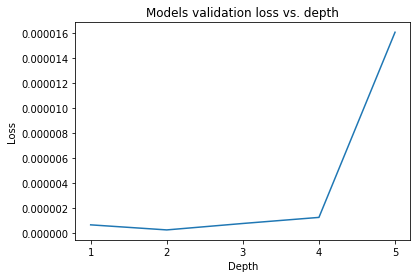

In [24]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. depth')
plt.ylabel('Loss')
plt.xlabel('Depth')
plt.xticks(np.arange(5), [1,2,3,4,5])
#plt.legend(['validation'], loc='upper left')
plt.show()

As you can see in the figure above, we had the best performance with 2 LSTM layers.

### Final LSTM training

Finally, we train the final LSTM architecture with 2 LSTM layers each with 4 neurons. 

In [28]:
numOfLayers = 2
numOfNeurons = 4 #np.power(2,i)
#[best_model,loss_history] = trainLSTM(numOfLayers, numOfNeurons)
[model, validatoinLoss, numOfEpochs, history] = trainLSTM(numOfLayers, numOfNeurons)


Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 100, 4)            96        
_________________________________________________________________
lstm_39 (LSTM)               (None, 100, 4)            144       
_________________________________________________________________
dense_26 (Dense)             (None, 100, 1)            5         
_________________________________________________________________
activation_26 (Activation)   (None, 100, 1)            0         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 5s 5ms/step - loss: 0.0937 - val_loss: 0.0932
Epoch 2/1000
900/900 [==============================] - 1s 2ms/step - loss: 0.0932 - val_loss: 0.0932
Epoch 3/10

900/900 [==============================] - 1s 2ms/step - loss: 1.8700e-04 - val_loss: 1.9328e-04
Epoch 146/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.8380e-04 - val_loss: 1.8992e-04
Epoch 147/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.8067e-04 - val_loss: 1.8662e-04
Epoch 148/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.7760e-04 - val_loss: 1.8339e-04
Epoch 149/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.7461e-04 - val_loss: 1.8021e-04
Epoch 150/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.7165e-04 - val_loss: 1.7710e-04
Epoch 151/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.6876e-04 - val_loss: 1.7405e-04
Epoch 152/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.6594e-04 - val_loss: 1.7105e-04
Epoch 153/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.6316e-04 - val_loss: 1.6811e-04
Epoch 1

900/900 [==============================] - 1s 2ms/step - loss: 2.3567e-05 - val_loss: 2.1090e-05
Epoch 292/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.3301e-05 - val_loss: 2.0818e-05
Epoch 293/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.3038e-05 - val_loss: 2.0547e-05
Epoch 294/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2780e-05 - val_loss: 2.0281e-05
Epoch 295/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2525e-05 - val_loss: 2.0018e-05
Epoch 296/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2274e-05 - val_loss: 1.9760e-05
Epoch 297/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.2026e-05 - val_loss: 1.9505e-05
Epoch 298/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.1782e-05 - val_loss: 1.9255e-05
Epoch 299/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.1541e-05 - val_loss: 1.9010e-05
Epoch 3

900/900 [==============================] - 1s 2ms/step - loss: 6.3164e-06 - val_loss: 4.0680e-06
Epoch 438/1000
900/900 [==============================] - 1s 2ms/step - loss: 6.2714e-06 - val_loss: 4.0275e-06
Epoch 439/1000
900/900 [==============================] - 1s 2ms/step - loss: 6.2266e-06 - val_loss: 3.9891e-06
Epoch 440/1000
900/900 [==============================] - 1s 2ms/step - loss: 6.1824e-06 - val_loss: 3.9509e-06
Epoch 441/1000
900/900 [==============================] - 1s 2ms/step - loss: 6.1388e-06 - val_loss: 3.9104e-06
Epoch 442/1000
900/900 [==============================] - 1s 2ms/step - loss: 6.0950e-06 - val_loss: 3.8728e-06
Epoch 443/1000
900/900 [==============================] - 1s 2ms/step - loss: 6.0520e-06 - val_loss: 3.8366e-06
Epoch 444/1000
900/900 [==============================] - 1s 2ms/step - loss: 6.0093e-06 - val_loss: 3.7988e-06
Epoch 445/1000
900/900 [==============================] - 1s 2ms/step - loss: 5.9672e-06 - val_loss: 3.7621e-06
Epoch 4

900/900 [==============================] - 1s 2ms/step - loss: 2.5555e-06 - val_loss: 1.0825e-06
Epoch 584/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.5417e-06 - val_loss: 1.0732e-06
Epoch 585/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.5284e-06 - val_loss: 1.0646e-06
Epoch 586/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.5154e-06 - val_loss: 1.0554e-06
Epoch 587/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.5032e-06 - val_loss: 1.0476e-06
Epoch 588/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.4903e-06 - val_loss: 1.0396e-06
Epoch 589/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.4769e-06 - val_loss: 1.0309e-06
Epoch 590/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.4639e-06 - val_loss: 1.0219e-06
Epoch 591/1000
900/900 [==============================] - 1s 2ms/step - loss: 2.4509e-06 - val_loss: 1.0155e-06
Epoch 5

900/900 [==============================] - 1s 2ms/step - loss: 1.3422e-06 - val_loss: 4.6026e-07
Epoch 730/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.3370e-06 - val_loss: 4.5788e-07
Epoch 731/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.3322e-06 - val_loss: 4.5614e-07
Epoch 732/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.3277e-06 - val_loss: 4.5559e-07
Epoch 733/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.3229e-06 - val_loss: 4.5486e-07
Epoch 734/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.3179e-06 - val_loss: 4.5266e-07
Epoch 735/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.3132e-06 - val_loss: 4.5127e-07
Epoch 736/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.3084e-06 - val_loss: 4.4943e-07
Epoch 737/1000
900/900 [==============================] - 1s 2ms/step - loss: 1.3039e-06 - val_loss: 4.4832e-07
Epoch 7

900/900 [==============================] - 1s 2ms/step - loss: 8.1940e-07 - val_loss: 3.2859e-07
Epoch 876/1000
900/900 [==============================] - 1s 2ms/step - loss: 8.1686e-07 - val_loss: 3.2901e-07
Epoch 877/1000
900/900 [==============================] - 1s 2ms/step - loss: 8.1410e-07 - val_loss: 3.2761e-07
Epoch 878/1000
900/900 [==============================] - 1s 2ms/step - loss: 8.1131e-07 - val_loss: 3.2632e-07
Epoch 879/1000
900/900 [==============================] - 1s 2ms/step - loss: 8.0865e-07 - val_loss: 3.2580e-07
Epoch 880/1000
900/900 [==============================] - 1s 2ms/step - loss: 8.0572e-07 - val_loss: 3.2457e-07
Epoch 881/1000
900/900 [==============================] - 1s 2ms/step - loss: 8.0304e-07 - val_loss: 3.2442e-07
Epoch 882/1000
900/900 [==============================] - 1s 2ms/step - loss: 8.0028e-07 - val_loss: 3.2323e-07
Epoch 883/1000
900/900 [==============================] - 1s 2ms/step - loss: 7.9765e-07 - val_loss: 3.2297e-07
Epoch 8

### Final LSTM evaluation

Precision is:  1.0
Recall is:  1.0


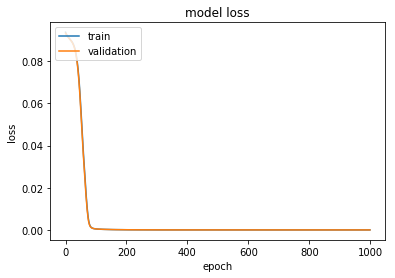

In [29]:
predicted = model.predict(LSTMTest_data)
mse = (np.square(LSTMTest_data - predicted)).mean(axis=1)
mse = mse.reshape(testDataSize)
reshaped_test_labels = test_labels.reshape(testDataSize)
mse_label = np.vstack((mse, reshaped_test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
lstmPrecision = precision
lstmRecall = recall
print("precision is: ", precision)
print("Recall is: ", precision)
show_curve(history)

### Auto-encoder
Next architecture we want to use is the Auto-Encoder. Again we first defined a function to use in tuning.

In [24]:
def trainAutoencoder(numOfHiddenLayersInEncoder, NeuronsCountInFirstLayer, printSummary = 1, vrbs = 1, return_best = 0):
    
    print('Training model.')

    model = Sequential()
    
    #NeuronsCountInFirstLayer = 64
    model.add(Dense(NeuronsCountInFirstLayer, input_shape=(sequenceLen,), activation='relu'))
    for i in range(1,numOfHiddenLayersInEncoder):
        model.add(Dense(int(NeuronsCountInFirstLayer/np.power(2,i)), activation="relu"))
        
    for j in range(1,numOfHiddenLayersInEncoder):    
        model.add(Dense(int(NeuronsCountInFirstLayer/np.power(2,(numOfHiddenLayersInEncoder - j - 1))), activation="relu"))
        
    model.add(Dense(100, activation="linear"))

    if(printSummary == True):
            model.summary()

    model.compile(optimizer='adam',
        loss='mean_squared_error',
    )
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
    callbacksArray = [es]
    if(return_best):
        mc = ModelCheckpoint('best_Autoencoder.h5', monitor='val_loss', mode='min')
        callbacksArray = [es, mc]

    history=model.fit(training_data, training_data,
                        batch_size=128,
                        shuffle=True,
                        epochs=1000, # Change this to at least 20 for final run
                        validation_split=0.1,
                        callbacks=callbacksArray,
                        verbose = vrbs
                        )
    
    if(return_best):
        best_model = load_model('best_Autoencoder.h5')
        
    returnModel = model
    if(return_best):
        returnModel = best_model
    return [returnModel,min(history.history['val_loss']),len(history.history['val_loss']),history]

### Fully Connected Auto-encoder depth tuning
In this part we try to tune the Auto-Encoder depth. We used 1,3,5 and 7 hidden layers to find out which works the best.

In [73]:
modelsLoss = []
modelsEpochs = []
for i in range(1,5):
    numOfLayers = i
    numOfNeurons = 4
    [model, validatoinLoss, numOfEpochs,_] = trainAutoencoder(numOfLayers, numOfNeurons)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 64)                6464      
_________________________________________________________________
dense_179 (Dense)            (None, 100)               6500      
Total params: 12,964
Trainable params: 12,964
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.1287 - val_loss: 0.1118
Epoch 2/1000
900/900 [==============================] - 0s 34us/step - loss: 0.1054 - val_loss: 0.0956
Epoch 3/1000
900/900 [==============================] - 0s 35us/step - loss: 0.0927 - val_loss: 0.0853
Epoch 4/1000
900/900 [==============================] - 0s 38us/step - loss: 0.0839 - val_loss: 0.0773
Epoch 5/1000
900/900 [==============================] - 0s 38

900/900 [==============================] - 0s 34us/step - loss: 0.0016 - val_loss: 7.8286e-04
Epoch 151/1000
900/900 [==============================] - 0s 37us/step - loss: 0.0015 - val_loss: 7.5667e-04
Epoch 152/1000
900/900 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 7.8582e-04
Epoch 153/1000
900/900 [==============================] - 0s 33us/step - loss: 0.0015 - val_loss: 7.5919e-04
Epoch 154/1000
900/900 [==============================] - 0s 34us/step - loss: 0.0015 - val_loss: 7.3667e-04
Epoch 155/1000
900/900 [==============================] - 0s 34us/step - loss: 0.0015 - val_loss: 7.5719e-04
Epoch 156/1000
900/900 [==============================] - 0s 34us/step - loss: 0.0015 - val_loss: 7.4843e-04
Epoch 157/1000
900/900 [==============================] - 0s 34us/step - loss: 0.0015 - val_loss: 7.5255e-04
Epoch 158/1000
900/900 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 7.5174e-04
Epoch 159/1000
900/900 [==========

Epoch 82/1000
900/900 [==============================] - 0s 42us/step - loss: 0.0085 - val_loss: 0.0068
Epoch 83/1000
900/900 [==============================] - 0s 40us/step - loss: 0.0084 - val_loss: 0.0066
Epoch 84/1000
900/900 [==============================] - 0s 42us/step - loss: 0.0083 - val_loss: 0.0066
Epoch 85/1000
900/900 [==============================] - 0s 45us/step - loss: 0.0082 - val_loss: 0.0066
Epoch 86/1000
900/900 [==============================] - 0s 41us/step - loss: 0.0083 - val_loss: 0.0068
Epoch 87/1000
900/900 [==============================] - 0s 42us/step - loss: 0.0082 - val_loss: 0.0064
Epoch 88/1000
900/900 [==============================] - 0s 42us/step - loss: 0.0081 - val_loss: 0.0064
Epoch 89/1000
900/900 [==============================] - 0s 43us/step - loss: 0.0080 - val_loss: 0.0062
Epoch 90/1000
900/900 [==============================] - 0s 41us/step - loss: 0.0079 - val_loss: 0.0062
Epoch 91/1000
900/900 [==============================] - 0s 42us

Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.0991 - val_loss: 0.0934
Epoch 2/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0909 - val_loss: 0.0830
Epoch 3/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0806 - val_loss: 0.0718
Epoch 4/1000
900/900 [==============================] - 0s 52us/step - loss: 0.0729 - val_loss: 0.0678
Epoch 5/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0694 - val_loss: 0.0662
Epoch 6/1000
900/900 [==============================] - 0s 48us/step - loss: 0.0676 - val_loss: 0.0652
Epoch 7/1000
900/900 [==============================] - 0s 50us/step - loss: 0.0664 - val_loss: 0.0643
Epoch 8/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0653 - val_loss: 0.0630
Epoch 9/1000
900/900 [==============================] - 0s 45us/step - loss: 0.0638 - val_loss: 0.0613
Epoch 10/1000
900/900 [=====

900/900 [==============================] - 0s 50us/step - loss: 0.0165 - val_loss: 0.0148
Epoch 158/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0163 - val_loss: 0.0147
Epoch 159/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0162 - val_loss: 0.0147
Epoch 160/1000
900/900 [==============================] - 0s 48us/step - loss: 0.0162 - val_loss: 0.0144
Epoch 161/1000
900/900 [==============================] - 0s 48us/step - loss: 0.0161 - val_loss: 0.0145
Epoch 162/1000
900/900 [==============================] - 0s 45us/step - loss: 0.0159 - val_loss: 0.0143
Epoch 163/1000
900/900 [==============================] - 0s 48us/step - loss: 0.0160 - val_loss: 0.0142
Epoch 164/1000
900/900 [==============================] - 0s 47us/step - loss: 0.0159 - val_loss: 0.0141
Epoch 165/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0159 - val_loss: 0.0143
Epoch 166/1000
900/900 [==============================] - 0s 49us/step

Epoch 313/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0095 - val_loss: 0.0079
Epoch 314/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0094 - val_loss: 0.0079
Epoch 315/1000
900/900 [==============================] - 0s 47us/step - loss: 0.0095 - val_loss: 0.0080
Epoch 316/1000
900/900 [==============================] - 0s 45us/step - loss: 0.0094 - val_loss: 0.0079
Epoch 317/1000
900/900 [==============================] - 0s 48us/step - loss: 0.0095 - val_loss: 0.0079
Epoch 318/1000
900/900 [==============================] - 0s 47us/step - loss: 0.0094 - val_loss: 0.0079
Epoch 319/1000
900/900 [==============================] - 0s 48us/step - loss: 0.0094 - val_loss: 0.0078
Epoch 320/1000
900/900 [==============================] - 0s 47us/step - loss: 0.0093 - val_loss: 0.0076
Epoch 321/1000
900/900 [==============================] - 0s 49us/step - loss: 0.0092 - val_loss: 0.0075
Epoch 322/1000
900/900 [==============================]

900/900 [==============================] - 0s 55us/step - loss: 0.0319 - val_loss: 0.0319
Epoch 124/1000
900/900 [==============================] - 0s 57us/step - loss: 0.0318 - val_loss: 0.0315
Epoch 125/1000
900/900 [==============================] - 0s 53us/step - loss: 0.0317 - val_loss: 0.0315
Epoch 126/1000
900/900 [==============================] - 0s 54us/step - loss: 0.0317 - val_loss: 0.0313
Epoch 127/1000
900/900 [==============================] - 0s 54us/step - loss: 0.0316 - val_loss: 0.0313
Epoch 128/1000
900/900 [==============================] - 0s 51us/step - loss: 0.0313 - val_loss: 0.0313
Epoch 129/1000
900/900 [==============================] - 0s 51us/step - loss: 0.0314 - val_loss: 0.0311
Epoch 130/1000
900/900 [==============================] - 0s 51us/step - loss: 0.0313 - val_loss: 0.0311
Epoch 131/1000
900/900 [==============================] - 0s 52us/step - loss: 0.0312 - val_loss: 0.0313
Epoch 132/1000
900/900 [==============================] - 0s 54us/step

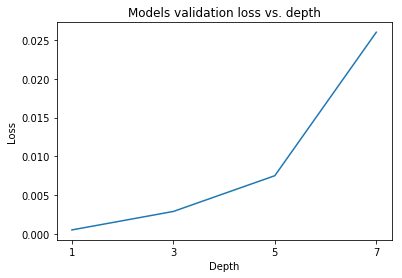

In [74]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. depth')
plt.ylabel('Loss')
plt.xlabel('Depth')
plt.xticks(np.arange(4), [1,3,5,7])
#plt.legend(['validation'], loc='upper left')
plt.show()

According to the figure above, it seems that the simplest model with just one hidden layer has the best performance.

### Final Auto-Encoder learning

In [75]:
numOfHiddenLayers = 1
numOfNeurons = 64
[model, validatoinLoss, numOfEpochs, history] = trainAutoencoder(numOfHiddenLayers, numOfNeurons, return_best = 1)

Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 64)                6464      
_________________________________________________________________
dense_199 (Dense)            (None, 100)               6500      
Total params: 12,964
Trainable params: 12,964
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 4s 4ms/step - loss: 0.1347 - val_loss: 0.1152
Epoch 2/1000
900/900 [==============================] - 0s 40us/step - loss: 0.1091 - val_loss: 0.0974
Epoch 3/1000
900/900 [==============================] - 0s 37us/step - loss: 0.0946 - val_loss: 0.0861
Epoch 4/1000
900/900 [==============================] - 0s 38us/step - loss: 0.0847 - val_loss: 0.0776
Epoch 5/1000
900/900 [==============================] - 0s 37

900/900 [==============================] - 0s 39us/step - loss: 0.0017 - val_loss: 9.0066e-04
Epoch 151/1000
900/900 [==============================] - 0s 40us/step - loss: 0.0017 - val_loss: 0.0010
Epoch 152/1000
900/900 [==============================] - 0s 39us/step - loss: 0.0018 - val_loss: 0.0010
Epoch 153/1000
900/900 [==============================] - 0s 40us/step - loss: 0.0017 - val_loss: 8.9974e-04
Epoch 154/1000
900/900 [==============================] - 0s 38us/step - loss: 0.0016 - val_loss: 8.5964e-04
Epoch 155/1000
900/900 [==============================] - 0s 37us/step - loss: 0.0016 - val_loss: 8.1979e-04
Epoch 156/1000
900/900 [==============================] - 0s 38us/step - loss: 0.0016 - val_loss: 8.1243e-04
Epoch 157/1000
900/900 [==============================] - 0s 39us/step - loss: 0.0016 - val_loss: 8.5076e-04
Epoch 158/1000
900/900 [==============================] - 0s 38us/step - loss: 0.0016 - val_loss: 8.2482e-04
Epoch 159/1000
900/900 [==================

### Final Auto-encoder evaluation

Precision is:  0.78
Recall is:  0.78


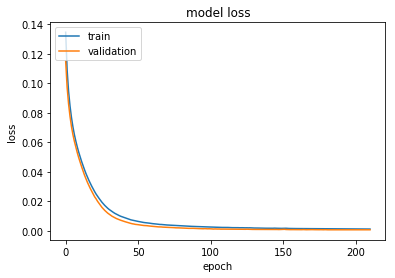

In [76]:
predicted = model.predict(test_data)
mse = (np.square(test_data - predicted)).mean(axis=1)
mse = mse.reshape(testDataSize)
reshaped_test_labels = test_labels.reshape(testDataSize)
mse_label = np.vstack((mse, reshaped_test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
autoencoderPrecision = precision
autoencoderRecall = recall
print("Precision is: ", precision)
print("Recall is: ", precision)
show_curve(history)

### 1-D Convolutional Network

In [3]:
def train1DConv(numOfHiddenLayersInEncoder, FiltersCountInFirstLayer = 32, printSummary = 1, vrbs = 1, return_best = 0, filterSize = 3):
    numOfHiddenLayersInEncoder = numOfHiddenLayersInEncoder + 1
    model = Sequential()    
    poolingSize = 2
    numOfFiltersInEncoder = [FiltersCountInFirstLayer]
    paddedSequenceLen = 128
    encoderLayersFilterSizes = [paddedSequenceLen]
    model.add(ZeroPadding1D(14,input_shape=(sequenceLen,1)))
    model.add(Conv1D(int(FiltersCountInFirstLayer), filterSize, activation='relu', padding = 'same'))
    for i in range(1,numOfHiddenLayersInEncoder):
        model.add(MaxPooling1D(poolingSize, padding='same'))
        model.add(Conv1D(int(FiltersCountInFirstLayer*np.power(2,i)), filterSize, activation='relu', padding = 'same'))
        encoderLayersFilterSizes.append(int(np.ceil(paddedSequenceLen/np.power(2,i))))
        numOfFiltersInEncoder.append(int(FiltersCountInFirstLayer*np.power(2,i)))
    model.add(Flatten())
    model.add(Reshape((encoderLayersFilterSizes[-1], numOfFiltersInEncoder[-1])))
    for j in range(1,numOfHiddenLayersInEncoder):    
        model.add(Conv1D(numOfFiltersInEncoder[-j], filterSize, activation='relu', padding = 'same'))
        model.add(UpSampling1D(poolingSize))

    model.add(Conv1D(numOfFiltersInEncoder[0], filterSize, activation='relu', padding='same'))
    model.add(Conv1D(1, filterSize, activation='linear', padding='same'))
    model.add(Cropping1D(14))
    model.summary()

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  )

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
    callbacksArray = [es]
    if(return_best):
        mc = ModelCheckpoint('best_1DConv.h5', monitor='val_loss', mode='min')
        callbacksArray = [es, mc]

    history=model.fit(LSTMTraining_data, LSTMTraining_data,
                        batch_size=128,
                        epochs=1000, 
                        shuffle=True,
                        validation_split=0.1,
                        callbacks=callbacksArray,
                        )
    if(return_best):
        best_model = load_model('best_1DConv.h5')
        
    returnModel = model
    if(return_best):
        returnModel = best_model
    return [returnModel,min(history.history['val_loss']),len(history.history['val_loss']),history]

### 1-D Convolutional Network Depth tune

In [289]:
modelsLoss = []
modelsEpochs = []
for i in range(1,6):
    numOfLayers = i
    filtersCountInFirstLayer = 32
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_60 (ZeroPaddi (None, 128, 1)            0         
_________________________________________________________________
conv1d_654 (Conv1D)          (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_336 (MaxPoolin (None, 64, 32)            0         
_________________________________________________________________
conv1d_655 (Conv1D)          (None, 64, 64)            6208      
_________________________________________________________________
flatten_114 (Flatten)        (None, 4096)              0         
_________________________________________________________________
reshape_94 (Reshape)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_656 (Conv1D)          (None, 64, 64)            12352     
__________

Epoch 16/1000
900/900 [==============================] - 0s 156us/step - loss: 1.8121e-05 - val_loss: 1.1678e-05
Epoch 17/1000
900/900 [==============================] - 0s 153us/step - loss: 1.6840e-05 - val_loss: 1.1964e-05
Epoch 18/1000
900/900 [==============================] - 0s 156us/step - loss: 1.5061e-05 - val_loss: 1.0595e-05
Epoch 19/1000
900/900 [==============================] - 0s 157us/step - loss: 1.3565e-05 - val_loss: 9.2459e-06
Epoch 20/1000
900/900 [==============================] - 0s 155us/step - loss: 1.5017e-05 - val_loss: 1.4724e-05
Epoch 21/1000
900/900 [==============================] - 0s 155us/step - loss: 1.8374e-05 - val_loss: 1.1191e-05
Epoch 22/1000
900/900 [==============================] - 0s 154us/step - loss: 1.2503e-05 - val_loss: 6.9706e-06
Epoch 23/1000
900/900 [==============================] - 0s 156us/step - loss: 1.1143e-05 - val_loss: 2.0299e-05
Epoch 24/1000
900/900 [==============================] - 0s 156us/step - loss: 1.0809e-04 - val_

Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 7s 8ms/step - loss: 0.0921 - val_loss: 0.0885
Epoch 2/1000
900/900 [==============================] - 0s 245us/step - loss: 0.0854 - val_loss: 0.0747
Epoch 3/1000
900/900 [==============================] - 0s 229us/step - loss: 0.0666 - val_loss: 0.0569
Epoch 4/1000
900/900 [==============================] - 0s 213us/step - loss: 0.0533 - val_loss: 0.0475
Epoch 5/1000
900/900 [==============================] - 0s 215us/step - loss: 0.0440 - val_loss: 0.0357
Epoch 6/1000
900/900 [==============================] - 0s 214us/step - loss: 0.0298 - val_loss: 0.0189
Epoch 7/1000
900/900 [==============================] - 0s 213us/step - loss: 0.0138 - val_loss: 0.0071
Epoch 8/1000
900/900 [==============================] - 0s 212us/step - loss: 0.0057 - val_loss: 0.0038
Epoch 9/1000
900/900 [==============================] - 0s 211us/step - loss: 0.0033 - val_loss: 0.0022
Epoch 10/1000
900/90

Epoch 74/1000
900/900 [==============================] - 0s 216us/step - loss: 7.3670e-05 - val_loss: 2.0442e-05
Epoch 75/1000
900/900 [==============================] - 0s 218us/step - loss: 3.0204e-05 - val_loss: 2.8556e-05
Epoch 76/1000
900/900 [==============================] - 0s 212us/step - loss: 1.7947e-05 - val_loss: 1.1730e-05
Epoch 77/1000
900/900 [==============================] - 0s 214us/step - loss: 1.0856e-05 - val_loss: 7.2811e-06
Epoch 78/1000
900/900 [==============================] - 0s 219us/step - loss: 8.3146e-06 - val_loss: 8.8894e-06
Epoch 79/1000
900/900 [==============================] - 0s 216us/step - loss: 8.4584e-06 - val_loss: 7.9803e-06
Epoch 80/1000
900/900 [==============================] - 0s 212us/step - loss: 7.6429e-06 - val_loss: 8.1525e-06
Epoch 81/1000
900/900 [==============================] - 0s 213us/step - loss: 8.4730e-06 - val_loss: 8.0005e-06
Epoch 82/1000
900/900 [==============================] - 0s 217us/step - loss: 9.7013e-06 - val_

900/900 [==============================] - 0s 319us/step - loss: 6.7120e-05 - val_loss: 4.6444e-05
Epoch 96/1000
900/900 [==============================] - 0s 318us/step - loss: 4.4713e-05 - val_loss: 3.5712e-05
Epoch 97/1000
900/900 [==============================] - 0s 318us/step - loss: 2.6953e-05 - val_loss: 2.4827e-05
Epoch 98/1000
900/900 [==============================] - 0s 323us/step - loss: 2.1382e-05 - val_loss: 2.9282e-05
Epoch 99/1000
900/900 [==============================] - 0s 318us/step - loss: 2.4159e-05 - val_loss: 5.1704e-05
Epoch 100/1000
900/900 [==============================] - 0s 319us/step - loss: 4.8111e-05 - val_loss: 2.6212e-05
Epoch 101/1000
900/900 [==============================] - 0s 319us/step - loss: 8.0910e-05 - val_loss: 6.4322e-05
Epoch 102/1000
900/900 [==============================] - 0s 319us/step - loss: 4.9866e-05 - val_loss: 4.3519e-05
Epoch 103/1000
900/900 [==============================] - 0s 319us/step - loss: 3.7137e-05 - val_loss: 3.16

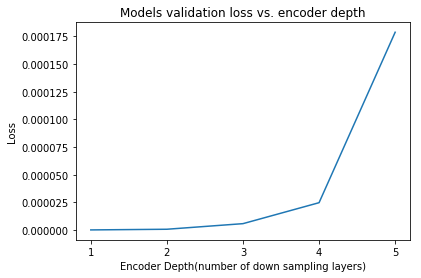

In [293]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. encoder depth')
plt.ylabel('Loss')
plt.xlabel('Encoder Depth(number of down sampling layers)')
plt.xticks(np.arange(5), [1,2,3,4,5])
#plt.legend(['validation'], loc='upper left')
plt.show()

### 1-D Convolutional Network filter size tuning

In [296]:
modelsLoss = []
modelsEpochs = []
for i in range(3,10,2):
    numOfLayers = 1
    filtersCountInFirstLayer = 32
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer, filterSize = i)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_65 (ZeroPaddi (None, 128, 1)            0         
_________________________________________________________________
conv1d_699 (Conv1D)          (None, 128, 32)           128       
_________________________________________________________________
max_pooling1d_351 (MaxPoolin (None, 64, 32)            0         
_________________________________________________________________
conv1d_700 (Conv1D)          (None, 64, 64)            6208      
_________________________________________________________________
flatten_119 (Flatten)        (None, 4096)              0         
_________________________________________________________________
reshape_99 (Reshape)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_701 (Conv1D)          (None, 64, 64)            12352     
__________

Epoch 58/1000
900/900 [==============================] - 0s 113us/step - loss: 3.3281e-07 - val_loss: 2.4280e-07
Epoch 59/1000
900/900 [==============================] - 0s 115us/step - loss: 3.1768e-07 - val_loss: 2.3218e-07
Epoch 60/1000
900/900 [==============================] - 0s 113us/step - loss: 3.0707e-07 - val_loss: 2.2376e-07
Epoch 61/1000
900/900 [==============================] - 0s 115us/step - loss: 2.9938e-07 - val_loss: 2.1642e-07
Epoch 62/1000
900/900 [==============================] - 0s 112us/step - loss: 2.8900e-07 - val_loss: 2.1424e-07
Epoch 63/1000
900/900 [==============================] - 0s 113us/step - loss: 2.8547e-07 - val_loss: 1.9962e-07
Epoch 64/1000
900/900 [==============================] - 0s 115us/step - loss: 2.7158e-07 - val_loss: 1.9033e-07
Epoch 65/1000
900/900 [==============================] - 0s 115us/step - loss: 2.6112e-07 - val_loss: 1.7940e-07
Epoch 66/1000
900/900 [==============================] - 0s 111us/step - loss: 2.5241e-07 - val_

Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 8s 9ms/step - loss: 0.0766 - val_loss: 0.0418
Epoch 2/1000
900/900 [==============================] - 0s 140us/step - loss: 0.0329 - val_loss: 0.0220
Epoch 3/1000
900/900 [==============================] - 0s 135us/step - loss: 0.0177 - val_loss: 0.0114
Epoch 4/1000
900/900 [==============================] - 0s 134us/step - loss: 0.0085 - val_loss: 0.0046
Epoch 5/1000
900/900 [==============================] - 0s 131us/step - loss: 0.0031 - val_loss: 0.0011
Epoch 6/1000
900/900 [==============================] - 0s 125us/step - loss: 6.6384e-04 - val_loss: 3.5564e-04
Epoch 7/1000
900/900 [==============================] - 0s 125us/step - loss: 2.7270e-04 - val_loss: 1.3942e-04
Epoch 8/1000
900/900 [==============================] - 0s 124us/step - loss: 1.0781e-04 - val_loss: 6.8555e-05
Epoch 9/1000
900/900 [==============================] - 0s 125us/step - loss: 5.5951e-05 - val_loss:

900/900 [==============================] - 0s 132us/step - loss: 2.9259e-05 - val_loss: 1.9453e-05
Epoch 46/1000
900/900 [==============================] - 0s 134us/step - loss: 1.4492e-05 - val_loss: 1.2710e-05
Epoch 47/1000
900/900 [==============================] - 0s 132us/step - loss: 7.6682e-06 - val_loss: 7.3060e-06
Epoch 48/1000
900/900 [==============================] - 0s 133us/step - loss: 4.9578e-06 - val_loss: 3.8787e-06
Epoch 49/1000
900/900 [==============================] - 0s 131us/step - loss: 3.9398e-06 - val_loss: 3.7222e-06
Epoch 50/1000
900/900 [==============================] - 0s 131us/step - loss: 3.1309e-06 - val_loss: 3.7625e-06
Epoch 51/1000
900/900 [==============================] - 0s 130us/step - loss: 4.3665e-06 - val_loss: 2.5355e-06
Epoch 52/1000
900/900 [==============================] - 0s 130us/step - loss: 2.5637e-06 - val_loss: 2.0814e-06
Epoch 53/1000
900/900 [==============================] - 0s 129us/step - loss: 5.8442e-06 - val_loss: 2.4243e-

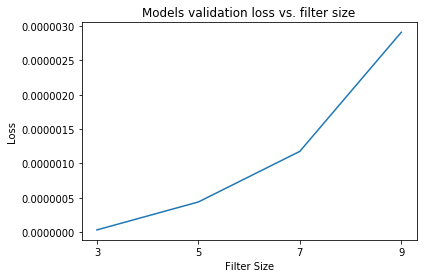

In [297]:
plt.plot(modelsLoss)
plt.title('Models validation loss vs. filter size')
plt.ylabel('Loss')
plt.xlabel('Filter Size')
plt.xticks(np.arange(4), [3,5,7,9])
plt.show()

### 1-D Convolutional Network first layer filter count tuning


In [8]:
modelsLoss = []
modelsEpochs = []
for i in range(1,10):
    numOfLayers = 1
    filtersCountInFirstLayer = np.power(2,i)
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer, filterSize = i)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_1 (ZeroPaddin (None, 128, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 2)            4         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 2)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 4)             12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 4)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 4)             20        
__________

Epoch 82/1000
900/900 [==============================] - 0s 49us/step - loss: 1.6297e-11 - val_loss: 1.4347e-11
Epoch 83/1000
900/900 [==============================] - 0s 49us/step - loss: 1.3692e-11 - val_loss: 1.2126e-11
Epoch 84/1000
900/900 [==============================] - 0s 47us/step - loss: 1.1427e-11 - val_loss: 1.0148e-11
Epoch 85/1000
900/900 [==============================] - 0s 50us/step - loss: 9.5515e-12 - val_loss: 8.3216e-12
Epoch 86/1000
900/900 [==============================] - 0s 49us/step - loss: 7.9678e-12 - val_loss: 7.0236e-12
Epoch 87/1000
900/900 [==============================] - 0s 48us/step - loss: 6.6254e-12 - val_loss: 5.8492e-12
Epoch 88/1000
900/900 [==============================] - 0s 49us/step - loss: 5.5339e-12 - val_loss: 4.8916e-12
Epoch 89/1000
900/900 [==============================] - 0s 49us/step - loss: 4.5825e-12 - val_loss: 4.0269e-12
Epoch 90/1000
900/900 [==============================] - 0s 50us/step - loss: 3.7879e-12 - val_loss: 3.3

900/900 [==============================] - 0s 54us/step - loss: 0.0422 - val_loss: 0.0386
Epoch 7/1000
900/900 [==============================] - 0s 55us/step - loss: 0.0369 - val_loss: 0.0338
Epoch 8/1000
900/900 [==============================] - 0s 53us/step - loss: 0.0316 - val_loss: 0.0280
Epoch 9/1000
900/900 [==============================] - 0s 52us/step - loss: 0.0255 - val_loss: 0.0219
Epoch 10/1000
900/900 [==============================] - 0s 53us/step - loss: 0.0195 - val_loss: 0.0162
Epoch 11/1000
900/900 [==============================] - 0s 53us/step - loss: 0.0143 - val_loss: 0.0115
Epoch 12/1000
900/900 [==============================] - 0s 54us/step - loss: 0.0098 - val_loss: 0.0074
Epoch 13/1000
900/900 [==============================] - 0s 53us/step - loss: 0.0060 - val_loss: 0.0041
Epoch 14/1000
900/900 [==============================] - 0s 53us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 15/1000
900/900 [==============================] - 0s 52us/step - loss: 0.0

Epoch 80/1000
900/900 [==============================] - 0s 52us/step - loss: 4.5802e-07 - val_loss: 4.3021e-07
Epoch 81/1000
900/900 [==============================] - 0s 52us/step - loss: 4.4100e-07 - val_loss: 4.1729e-07
Epoch 82/1000
900/900 [==============================] - 0s 53us/step - loss: 4.2708e-07 - val_loss: 4.0210e-07
Epoch 83/1000
900/900 [==============================] - 0s 53us/step - loss: 4.1019e-07 - val_loss: 3.8865e-07
Epoch 84/1000
900/900 [==============================] - 0s 52us/step - loss: 3.9679e-07 - val_loss: 3.7355e-07
Epoch 85/1000
900/900 [==============================] - 0s 51us/step - loss: 3.8190e-07 - val_loss: 3.5948e-07
Epoch 86/1000
900/900 [==============================] - 0s 52us/step - loss: 3.7035e-07 - val_loss: 3.4969e-07
Epoch 87/1000
900/900 [==============================] - 0s 50us/step - loss: 3.5588e-07 - val_loss: 3.3924e-07
Epoch 88/1000
900/900 [==============================] - 0s 53us/step - loss: 3.4614e-07 - val_loss: 3.2

900/900 [==============================] - 0s 53us/step - loss: 7.8242e-09 - val_loss: 8.1203e-09
Epoch 225/1000
900/900 [==============================] - 0s 51us/step - loss: 7.8367e-09 - val_loss: 7.2276e-09
Epoch 226/1000
900/900 [==============================] - 0s 52us/step - loss: 7.4295e-09 - val_loss: 6.9735e-09
Epoch 227/1000
900/900 [==============================] - 0s 52us/step - loss: 7.1768e-09 - val_loss: 7.0120e-09
Epoch 228/1000
900/900 [==============================] - 0s 53us/step - loss: 7.1818e-09 - val_loss: 6.6172e-09
Epoch 229/1000
900/900 [==============================] - 0s 50us/step - loss: 6.8518e-09 - val_loss: 6.9437e-09
Epoch 230/1000
900/900 [==============================] - 0s 53us/step - loss: 6.8268e-09 - val_loss: 6.7813e-09
Epoch 231/1000
900/900 [==============================] - 0s 51us/step - loss: 6.8337e-09 - val_loss: 6.5410e-09
Epoch 232/1000
900/900 [==============================] - 0s 53us/step - loss: 6.5023e-09 - val_loss: 6.0624e-0

900/900 [==============================] - 0s 52us/step - loss: 1.6011e-10 - val_loss: 1.5298e-10
Epoch 369/1000
900/900 [==============================] - 0s 54us/step - loss: 1.7196e-10 - val_loss: 1.4816e-10
Epoch 370/1000
900/900 [==============================] - 0s 51us/step - loss: 1.7715e-10 - val_loss: 1.5012e-10
Epoch 371/1000
900/900 [==============================] - 0s 52us/step - loss: 2.3419e-10 - val_loss: 4.4219e-10
Epoch 372/1000
900/900 [==============================] - 0s 52us/step - loss: 4.5123e-10 - val_loss: 4.1900e-10
Epoch 373/1000
900/900 [==============================] - 0s 53us/step - loss: 3.8154e-10 - val_loss: 5.3207e-10
Epoch 374/1000
900/900 [==============================] - 0s 53us/step - loss: 5.4545e-10 - val_loss: 7.1035e-10
Epoch 375/1000
900/900 [==============================] - 0s 52us/step - loss: 7.1264e-10 - val_loss: 7.4106e-10
Epoch 376/1000
900/900 [==============================] - 0s 52us/step - loss: 6.2946e-10 - val_loss: 1.1404e-0

Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 1s 2ms/step - loss: 0.0764 - val_loss: 0.0463
Epoch 2/1000
900/900 [==============================] - 0s 88us/step - loss: 0.0365 - val_loss: 0.0242
Epoch 3/1000
900/900 [==============================] - 0s 89us/step - loss: 0.0186 - val_loss: 0.0106
Epoch 4/1000
900/900 [==============================] - 0s 90us/step - loss: 0.0067 - val_loss: 0.0017
Epoch 5/1000
900/900 [==============================] - 0s 90us/step - loss: 9.2883e-04 - val_loss: 7.5094e-04
Epoch 6/1000
900/900 [==============================] - 0s 90us/step - loss: 4.7772e-04 - val_loss: 1.4233e-04
Epoch 7/1000
900/900 [==============================] - 0s 92us/step - loss: 1.7294e-04 - val_loss: 1.1444e-04
Epoch 8/1000
900/900 [==============================] - 0s 90us/step - loss: 7.8229e-05 - val_loss: 6.5695e-05
Epoch 9/1000
900/900 [==============================] - 0s 91us/step - loss: 5.1987e-05 - val_loss:

900/900 [==============================] - 0s 88us/step - loss: 1.8587e-06 - val_loss: 6.0105e-07
Epoch 75/1000
900/900 [==============================] - 0s 88us/step - loss: 4.8086e-07 - val_loss: 6.0318e-07
Epoch 76/1000
900/900 [==============================] - 0s 89us/step - loss: 4.4371e-07 - val_loss: 3.3793e-07
Epoch 77/1000
900/900 [==============================] - 0s 89us/step - loss: 3.6934e-07 - val_loss: 5.1893e-07
Epoch 78/1000
900/900 [==============================] - 0s 88us/step - loss: 2.5803e-06 - val_loss: 1.7364e-05
Epoch 79/1000
900/900 [==============================] - 0s 89us/step - loss: 2.7600e-05 - val_loss: 6.1948e-06
Epoch 80/1000
900/900 [==============================] - 0s 88us/step - loss: 9.1988e-06 - val_loss: 7.9031e-06
Epoch 81/1000
900/900 [==============================] - 0s 91us/step - loss: 3.7032e-06 - val_loss: 2.4645e-06
Epoch 82/1000
900/900 [==============================] - 0s 88us/step - loss: 1.9420e-06 - val_loss: 3.7801e-07
Epoch 

900/900 [==============================] - 0s 369us/step - loss: 6.3948e-07 - val_loss: 3.5558e-07
Epoch 28/1000
900/900 [==============================] - 0s 373us/step - loss: 5.7803e-07 - val_loss: 3.4186e-07
Epoch 29/1000
900/900 [==============================] - 0s 370us/step - loss: 5.1738e-07 - val_loss: 3.2043e-07
Epoch 30/1000
900/900 [==============================] - 0s 370us/step - loss: 4.6752e-07 - val_loss: 3.1602e-07
Epoch 31/1000
900/900 [==============================] - 0s 373us/step - loss: 4.3275e-07 - val_loss: 2.8831e-07
Epoch 32/1000
900/900 [==============================] - 0s 371us/step - loss: 4.1377e-07 - val_loss: 3.1939e-07
Epoch 33/1000
900/900 [==============================] - 0s 370us/step - loss: 3.9679e-07 - val_loss: 2.6312e-07
Epoch 34/1000
900/900 [==============================] - 0s 373us/step - loss: 3.6808e-07 - val_loss: 2.9382e-07
Epoch 35/1000
900/900 [==============================] - 0s 372us/step - loss: 3.7810e-07 - val_loss: 2.4524e-

900/900 [==============================] - 4s 4ms/step - loss: 1.9824e-06 - val_loss: 1.1755e-06
Epoch 49/1000
900/900 [==============================] - 4s 4ms/step - loss: 1.7613e-06 - val_loss: 1.9185e-06
Epoch 50/1000
900/900 [==============================] - 4s 4ms/step - loss: 1.0879e-06 - val_loss: 5.3801e-07
Epoch 00050: early stopping


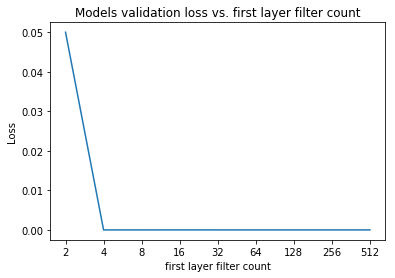

In [9]:
plt.plot(modelsLoss)
plt.title('Models validation loss vs. first layer filter count')
plt.ylabel('Loss')
plt.xlabel('first layer filter count')
plt.xticks(np.arange(9), [2,4,8,16,32,64,128,256,512])
plt.show()

First, I tried different filter counts ranged from 2 to 512 (powers of 2). As you can see in figure above, using filter size 2 is not enough and results in the worst performance. As the different between other filter counts is not clear here, I plotted range 4 to 512 in the next figure.

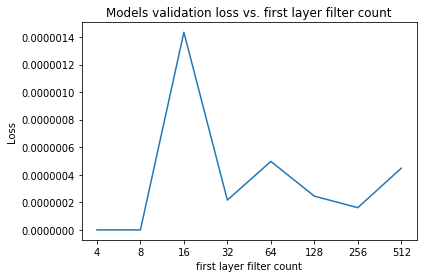

In [17]:
plt.plot(modelsLoss[1:])
plt.title('Models validation loss vs. first layer filter count')
plt.ylabel('Loss')
plt.xlabel('first layer filter count')
plt.xticks(np.arange(8), [4,8,16,32,64,128,256,512])
plt.show()

###### Plot in more detail:
As it is shown in figure above, we have the best performance in filter sizes 4 and 8. Although there is fluctuations in larger sizes results, all of them have worse performance (due lack of memory I could not try filter sizes more than 512. However, this does not seems to be a decsending trend). 

### Final 1D Convolutional Network learning
Now it is time to train our final model using the parameters that we found before:

In [18]:
numOfLayers = 1
filtersCountInFirstLayer = 4
[model, validatoinLoss, numOfEpochs, history] = train1DConv(numOfLayers, filtersCountInFirstLayer, filterSize = i)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_10 (ZeroPaddi (None, 128, 1)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 128, 4)            40        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 64, 4)             0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 64, 8)             296       
_________________________________________________________________
flatten_10 (Flatten)         (None, 512)               0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 64, 8)             0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 64, 8)             584       
__________

Epoch 132/1000
900/900 [==============================] - 0s 52us/step - loss: 5.4688e-05 - val_loss: 5.4770e-05
Epoch 133/1000
900/900 [==============================] - 0s 51us/step - loss: 5.4605e-05 - val_loss: 5.1741e-05
Epoch 134/1000
900/900 [==============================] - 0s 52us/step - loss: 5.2785e-05 - val_loss: 4.8781e-05
Epoch 135/1000
900/900 [==============================] - 0s 51us/step - loss: 5.1240e-05 - val_loss: 4.7370e-05
Epoch 136/1000
900/900 [==============================] - 0s 51us/step - loss: 5.0009e-05 - val_loss: 4.6949e-05
Epoch 137/1000
900/900 [==============================] - 0s 50us/step - loss: 4.9465e-05 - val_loss: 4.6262e-05
Epoch 138/1000
900/900 [==============================] - 0s 50us/step - loss: 4.8754e-05 - val_loss: 4.6347e-05
Epoch 139/1000
900/900 [==============================] - 0s 52us/step - loss: 4.8507e-05 - val_loss: 4.7105e-05
Epoch 140/1000
900/900 [==============================] - 0s 52us/step - loss: 4.8530e-05 - val_

900/900 [==============================] - 0s 57us/step - loss: 1.5011e-05 - val_loss: 1.2901e-05
Epoch 277/1000
900/900 [==============================] - 0s 55us/step - loss: 1.4768e-05 - val_loss: 1.2497e-05
Epoch 278/1000
900/900 [==============================] - 0s 55us/step - loss: 1.3777e-05 - val_loss: 1.2670e-05
Epoch 279/1000
900/900 [==============================] - 0s 53us/step - loss: 1.3835e-05 - val_loss: 1.2025e-05
Epoch 280/1000
900/900 [==============================] - 0s 53us/step - loss: 1.3496e-05 - val_loss: 1.2242e-05
Epoch 281/1000
900/900 [==============================] - 0s 53us/step - loss: 1.3382e-05 - val_loss: 1.1933e-05
Epoch 282/1000
900/900 [==============================] - 0s 52us/step - loss: 1.3259e-05 - val_loss: 1.1599e-05
Epoch 283/1000
900/900 [==============================] - 0s 51us/step - loss: 1.3061e-05 - val_loss: 1.2675e-05
Epoch 284/1000
900/900 [==============================] - 0s 51us/step - loss: 1.3635e-05 - val_loss: 1.1689e-0

900/900 [==============================] - 0s 51us/step - loss: 6.0827e-06 - val_loss: 6.1444e-06
Epoch 421/1000
900/900 [==============================] - 0s 52us/step - loss: 6.3998e-06 - val_loss: 5.6201e-06
Epoch 422/1000
900/900 [==============================] - 0s 52us/step - loss: 6.2026e-06 - val_loss: 5.4240e-06
Epoch 00422: early stopping


### 1-D Convolutional Network Final evaluation

Precision is:  1.0
Recall is:  1.0


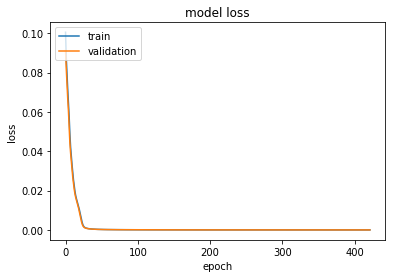

In [19]:
predicted = model.predict(LSTMTest_data)
mse = (np.square(LSTMTest_data - predicted)).mean(axis=1)
mse = mse.reshape(testDataSize)
reshaped_test_labels = test_labels.reshape(testDataSize)
mse_label = np.vstack((mse, reshaped_test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
convPrecision = precision
convRecall = recall
print("Precision is: ", precision)
print("Recall is: ", precision)
#history.history['loss']
show_curve(history)

### Conclusion

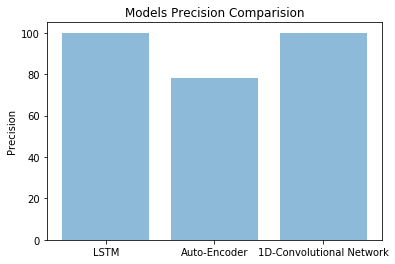

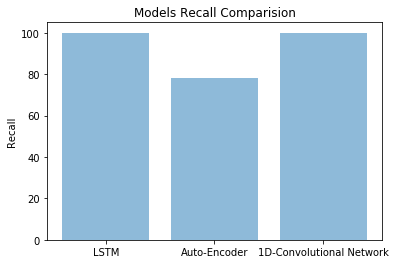

In [33]:
objects = ('LSTM', 'Auto-Encoder', '1D-Convolutional Network')
y_pos = np.arange(len(objects))
performance = [lstmPrecision,autoencoderPrecision,convPrecision]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Precision')
plt.title('Models Precision Comparision')
 
plt.show()

objects = ('LSTM', 'Auto-Encoder', '1D-Convolutional Network')
y_pos = np.arange(len(objects))
performance = [lstmRecall,autoencoderRecall,convRecall]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Recall')
plt.title('Models Recall Comparision')
 
plt.show()

As you can see in images above, both LSTM and one dimensional convolutional network have a great performance on detecting anomalies in our dataset. However, this does not say that these models are outperforming Auto-Encoder in anomaly detection and all the results are espesific to this dataset. Because we are just using a relatively simple synthetic dataset with one feature consisting of 0s and 1s. In real world there are more complex patterns which might be harder to learn. For future works, we should try these models (of course after tuning them well) on different datasets. Other thing that we should mention here is that, there are more parameters to tune in each of these architectures, like number of Dense layers in LSTM network, Or different optimizers in Auto-Encoder that we could not test all of them due lack of time but in more complex tasks it might be necessary to do that.

### References
<ol>
    <li>
      O. Gorokhov, M. Petrovskiy, and I. Mashechkin, "Convolutional neural networks for unsupervised anomaly detection in text data," in International Conference on Intelligent Data Engineering and Automated Learning, 2017, pp. 500-507.  
    </li>
    <li>
      D. Kwon, K. Natarajan, S. C. Suh, H. Kim, and J. Kim, "An empirical study on network anomaly detection using convolutional neural networks," in 2018 IEEE 38th International Conference on Distributed Computing Systems (ICDCS), 2018, pp. 1595-1598. 
    </li>
    <li>
      D. Sovilja, P. Budnaraina, S. Sanner, G. Salmonb, and M. Raob, "A Comparative Evaluation of Unsupervised Deep Learning Techniques for Intrusion Detection in Sequential Data Streams." 
    </li>
</ol>